# Notes
* This notebook has implementations of `Backprop` with binary spike feature vectors obtained from the `SPIKEFLOW`. Here, we will use tf.data API. Here the shape of the inputs is `[None, n_input]` instead of `[n_input, None]`. We had to do this because nested elements in `from_tensor_slices` must have the same dimension in 0th rank [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). Everytime an iterator `iter = dataset.make_initializable_iterator()` gets initialized, the dataset is randomly shuffled so we need not shuffle again, [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). We also use `z_3 = tf.floor(z_3)`. Surrogate gradients with one step is used. (one sided)

* Here, error in the hidden layer, $\delta^{2}$ is implemented as:
$ \delta^{2} = W^{3T}\delta^{(3)}\odot\sigma^{'}(z^{(2)}) \tag{1}$
* $\sigma^{'}(z^{(2)})$ is approximated with a surrogate. (See section 6)
* It also takes care of catastrophic forgetting by using synaptic intelligence.
* He initialization without AR1 gives lesser final accuracy than Trunc init because in He the gradients don't suffer from dimnishing.
* Here the weight importances are calculated in the every epoch in the disjoint case and last epoch in the 10% data stored case.
* Here each task has a size of 4 classes except for the last task which has 3 classes.
## References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
* [TF memory leaks when  assigning in loop](https://github.com/tensorflow/tensorflow/issues/4151)
   

In [1]:
import os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline
import h5py, pickle
from keras.utils.np_utils import to_categorical 
import numpy as np
import pandas as pd
import DATA_Loader
import seaborn as sb
import theano, random, sys, time
from sklearn.utils import shuffle

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
tf

1.14.0


<module 'tensorflow' from '/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

# Hide code

In [ ]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Plots
* FOR PRETTY IEEE PLOTS mpl.rcParams['figure.figsize'] = 4.5,2.5, all fonts 9-12

## Large

In [3]:
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25
mpl.rcParams['font.size'] = 22

## Small

In [4]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 4.5,2.75
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

# Load data

In [5]:
filename = '../../spiking_networks/emnist_train_pool1_acc_cont_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_train_images = hf['pool1_spike_features'][:].astype(np.float32)
#@@emnist_train_images[np.where(emnist_train_images>=1)] = 1

filehandle = open('../../spiking_networks/emnist_train_y.pkl','rb')
emnist_train_labels = pickle.load(filehandle).astype(np.float32).tolist()
filehandle.close()
emnist_train_labels = np.array(emnist_train_labels)
print('Total train features:{}'.format(emnist_train_images.shape[0]))

#### LOAD TEST IMAGES AND LABELS
filename = '../../spiking_networks/emnist_test_pool1_acc_cont_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_test_images = hf['pool1_spike_features'][:].astype(np.float32)
#@@emnist_test_images[np.where(emnist_test_images>=1)] = 1
print('Total test features:{}'.format(emnist_test_images.shape[0]))

filehandle = open('../../spiking_networks/emnist_test_y.pkl','rb')
emnist_test_labels = pickle.load(filehandle).astype(np.float32)
filehandle.close()
emnist_test_labels = np.array(emnist_test_labels)

#### LOAD TRAIN AND VALIDATION DATA AND LABELS
train_images = emnist_train_images
train_labels = emnist_train_labels
train_labels = np.array(train_labels)
test_images = emnist_test_images
test_labels = emnist_test_labels
num_classes=47

Total train features:112799
Total test features:18800


In [6]:
train_images.max()

12.0

In [7]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}

In [8]:
BATCH_SIZE = 10
#### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TRAIN DATA
def extract_class_data(start=0, stop=1):
    set1_locs = np.where((train_labels>=start) & (train_labels<=stop))[0]
    train_labels_set1 = to_categorical(train_labels[set1_locs], num_classes=num_classes)
    train_images_set1 = train_images[set1_locs,:]
    n_images = len(train_images_set1)

    #### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TEST DATA
    set1_locs = np.where((test_labels>=start) & (test_labels<=stop))[0]
    test_labels_set1 = to_categorical(test_labels[set1_locs], num_classes=num_classes)
    test_images_set1 = test_images[set1_locs,:]
    print('Test features:{}'.format(test_images_set1.shape))
    print('Length of test labels:{}'.format(test_labels_set1.shape[0]))
    test_data_set1 = (test_images_set1, test_labels_set1)
    


    train_images_set1 = train_images_set1[int(0.09*n_images):]
    train_labels_set1 = train_labels_set1[int(0.09*n_images):]
    print('Train features:{}'.format(train_images_set1.shape))
    print('Length of train labels:{}'.format(train_labels_set1.shape[0]))
    train_data_set1 = (train_images_set1, train_labels_set1)

    valid_labels_set1 = train_labels_set1[0:int(0.09*n_images)]
    valid_images_set1 = train_images_set1[0:int(0.09*n_images)]
    print('Valid features:{}'.format(valid_images_set1.shape))
    print('Length of valid labels:{}'.format(valid_labels_set1.shape[0]))
    valid_data_set1 = (valid_images_set1, valid_labels_set1)
    
    n_train_set1 = train_labels_set1.shape[0]
    n_test_set1 = test_labels_set1.shape[0]
    n_valid_set1 = valid_labels_set1.shape[0]

    return train_data_set1, valid_data_set1, test_data_set1

# Start a session

In [9]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess= tf.InteractiveSession(config=config)
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

# Setup the network

In [10]:
n_input = 3630
n_middle = 1500
n_out = 47
batch_size = tf.placeholder(tf.int64, name='batch_size') 
gradient_gate = tf.placeholder(tf.float32, name='gradient_gate') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

drop_out = tf.placeholder(tf.float32)
tau = tf.placeholder(tf.float32)
set1_mask = tf.placeholder(tf.float32, [n_out], name='mask')
eta = tf.placeholder(tf.float32)
n_tot = tf.placeholder(tf.float32)
lmbda = tf.placeholder(tf.float32, name='lambda')
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(2.0/(n_input))
    
    w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    #w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    w_2_update_placeholder = tf.placeholder(w_2.dtype, shape=w_2.get_shape(),name='update_w2')
    w_2_update_op = w_2.assign(w_2_update_placeholder)
    tf.summary.histogram('w_2', w_2)
    
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    b_2_update_placeholder = tf.placeholder(b_2.dtype, shape=b_2.get_shape(),name='update_b2')
    b_2_update_op = b_2.assign(b_2_update_placeholder)
    tf.summary.histogram('b_2', b_2)
    
    
    w2_grad_accum = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32),name='w2_grad_accum')
    w2_grad_accum_update_placeholder=tf.placeholder(w2_grad_accum.dtype, shape=w2_grad_accum.get_shape(),
                                            name='update_w2_grad_accum')
    w2_grad_accum_update_op = w2_grad_accum.assign(w2_grad_accum_update_placeholder)
    
    
    b2_grad_accum = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='b2_grad_accum')
    b2_grad_accum_update_placeholder=tf.placeholder(b2_grad_accum.dtype,shape=b2_grad_accum.get_shape(),
                                            name='update_b2_grad_accum')
    b2_grad_accum_update_op = b2_grad_accum.assign(b2_grad_accum_update_placeholder)
    
    
    big_omeg_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='omeg_w2')
    tf.summary.histogram('big_omeg_w2', big_omeg_w2)
    big_omeg_w2_update_placeholder = tf.placeholder(big_omeg_w2.dtype, shape=big_omeg_w2.get_shape(),
                                                    name='update_big_omeg_w2')
    big_omeg_w2_update_op = big_omeg_w2.assign(big_omeg_w2_update_placeholder)
    
    
    big_omeg_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='omeg_b2')
    tf.summary.histogram('big_omeg_b2', big_omeg_b2)
    big_omeg_b2_update_placeholder = tf.placeholder(big_omeg_b2.dtype, shape=big_omeg_b2.get_shape(),
                                                    name='update_big_omeg_b2')
    big_omeg_b2_update_op = big_omeg_b2.assign(big_omeg_b2_update_placeholder)
    
    
    star_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='star_w2')
    star_w2_update_placeholder = tf.placeholder(star_w2.dtype, shape=star_w2.get_shape(),
                                                name='update_star_w2')
    star_w2_update_op = star_w2.assign(star_w2_update_placeholder)
    
    
    star_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='star_b2')
    star_b2_update_placeholder = tf.placeholder(star_b2.dtype, shape=star_b2.get_shape(),
                                                name='update_star_b2')
    star_b2_update_op = star_b2.assign(star_b2_update_placeholder)
with tf.name_scope('op_lyr_w_b'):
    
    low = -tf.math.sqrt(2.0/(n_middle))
    high = tf.math.sqrt(2.0/(n_middle))
    #w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,10],minval=low,maxval=high), name = 'W_3')
    #w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    w_3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32),name = 'W_3')
    tf.summary.histogram('w_3', w_3)
    w_3_update_placeholder = tf.placeholder(w_3.dtype, shape=w_3.get_shape(),name='update_w3')
    w_3_update_op = w_3.assign(w_3_update_placeholder)
    
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)
    b_3_update_placeholder = tf.placeholder(b_3.dtype, shape=b_3.get_shape(),name='update_b3')
    b_3_update_op = b_3.assign(b_3_update_placeholder)
    
    w3_grad_accum = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='w3_grad_accum')
    b3_grad_accum = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='b3_grad_accum')
    
    big_omeg_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='omeg_w3')
    tf.summary.histogram('big_omeg_w3', big_omeg_w3)
    big_omeg_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='omeg_b3')
    tf.summary.histogram('big_omeg_b3', big_omeg_b3)
    
    star_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='star_w3')
    star_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='star_b3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def spkPrime1(x):
    l1_bound_higher = tf.greater_equal(x,-0/4)
    r1_bound_lesser = tf.less_equal(x,tau/4) 
    grad_one = tf.where(tf.logical_and(l1_bound_higher,r1_bound_lesser), tf.ones_like(x), tf.zeros_like(x))
    return grad_one

def firstLyrSpks(x):
    return tf.where(tf.greater_equal(x,1.0), tf.ones_like(x), 
                        tf.zeros_like(x))

    
with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    a_2 = ReLU(z_2)
    #@@a_2 = spkNeuron(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    #@@z_3 = tf.floor(z_3)
    #z_3 = tf.subtract(tf.reduce_max(z_3),z_3, name = 'inhibition')
    tf.summary.histogram('z_3', z_3)
    a_3 = tf.cast(tf.nn.softmax(z_3,axis=1), tf.float32)
    a_3 = tf.multiply(a_3, set1_mask, name='masking')
    tf.summary.histogram('a_3', a_3)
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    #a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),
                          name = 'cost_calc')#WORKS
        ##COMMENT BELOW LINES IF YOU WANT quadratic
    #@dc_da = tf.multiply(-tf.subtract(labels,a_3, name = 'y_minus_a_3'), mask)
    #@cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    #@d_z_3 = tf.multiply(-tf.subtract(labels,a_3, name = 'delta3'), mask, name='masking')
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = tf.expand_dims(tf.reduce_mean(d_z_3, axis=[0]), axis=0)
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(a_2),d_z_3), 
                        name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), ReLUprime(z_2),
                        name = 'delta2')
    #@@d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), spkPrime1(z_2),
    #@@                    name = 'delta2')
    #d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = tf.expand_dims(tf.reduce_mean(d_z_2, axis=[0]), axis=0)
    d_b_2 = tf.multiply(gradient_gate, d_b_2, name='gradient_gating_b2')
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(features),d_z_2), 
                        name='delta_w2')
    d_w_2 = tf.multiply(gradient_gate, d_w_2, name='gradient_gating_w2')
    tf.summary.histogram('d_w_2', d_w_2)
    
omega_step=[tf.assign(w2_grad_accum,
                      tf.add(w2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot, tf.square(d_w_2))),
                     name='update_omeg_w2'),
            tf.assign(b2_grad_accum,
                      tf.add(b2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot,tf.square(d_b_2))),
                     name='update_omeg_b2')
]

step = [tf.assign(w_2,
                  tf.subtract(w_2, (eta*d_w_2+big_omeg_w2*(w_2-star_w2))),name='update_w_2'),
        tf.assign(b_2,
                  tf.subtract(b_2,(eta*d_b_2+big_omeg_b2*(b_2-star_b2))),name='update_b_2'),
        
        tf.assign(w_3,
                  tf.subtract(w_3, (eta*d_w_3+big_omeg_w3*(w_3-star_w3))),name='update_w_3'),
        tf.assign(b_3,
                  tf.subtract(b_3,(eta*d_b_3+big_omeg_b3*(b_3-star_b3))),name='update_b_3')    
]
with tf.name_scope('acc_calc'):
    predictions = tf.argmax(a_3, 1)
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)
    
    #test_accuracy_summary = tf.summary.scalar('test_accuracy', acct_res)
    
init_op = tf.global_variables_initializer()

# Init the writer with three best $\lambda$s

In [11]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/emnist/continual_learning/3sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_emnist_ar1_final_v6', sess.graph)

# Generate $\lambda$s

In [12]:
np.random.seed(100)
n_lmbdas = 7
a = np.random.uniform(low=0.0, high=200, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e5
a = a[np.argsort(a)]
#a= a[-3:]
print(a)
print(type(a))
n_reps = 6
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[108.68098836  55.67387702  84.90351815 168.95522646   0.94377124
  24.31382416 134.14981695]
()
[   94377.12381945  2431382.41566228  5567387.70187592  8490351.81498266
 10868098.83581931 13414981.69453557 16895522.64639807]
<type 'numpy.ndarray'>
([0, 94377.1238194513, 2431382.4156622845, 5567387.701875923, 8490351.814982662, 10868098.83581931, 13414981.694535572, 16895522.64639807, 0, 94377.1238194513, 2431382.4156622845, 5567387.701875923, 8490351.814982662, 10868098.83581931, 13414981.694535572, 16895522.64639807, 0, 94377.1238194513, 2431382.4156622845, 5567387.701875923, 8490351.814982662, 10868098.83581931, 13414981.694535572, 16895522.64639807, 0, 94377.1238194513, 2431382.4156622845, 5567387.701875923, 8490351.814982662, 10868098.83581931, 13414981.694535572, 16895522.64639807, 0, 94377.1238194513, 2431382.4156622845, 5567387.701875923, 8490351.814982662, 10868098.83581931, 13414981.694535572, 16895522.64639807, 0, 94377.1238194513, 2431382.4156622845, 5567387.701875923, 8490

# Generate random weights

In [13]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(48, 48)


In [14]:
n_lmbdas

8

In [15]:
np.array_equal(np_weights[0], np_weights[7])

True

In [16]:
np.array_equal(np_weights[0], np_weights[8])

False

In [17]:
np.array_equal(np_weights[8], np_weights[10])

True

# Splitting the dataset into tasks

In [18]:
print(labels_map)

task_splits = np.array_split(np.arange(num_classes), num_classes/4-1)

task_splits = [(item.tolist()[0], item.tolist()[-1]) for item in task_splits]
task_splits



{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


[(0, 4),
 (5, 9),
 (10, 14),
 (15, 19),
 (20, 24),
 (25, 29),
 (30, 34),
 (35, 38),
 (39, 42),
 (43, 46)]

# Commence training

In [19]:
START_TIME = time.time()
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
all_prev_task_test_accs = []
all_prev_task_test_activs = []
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    frac_old_train_images = []
    frac_old_train_labels = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = np.array_split(range(num_classes), int(num_classes/2))
    sets = [tuple(item.tolist()) for item in sets]
    sets = [(0, 9), (10, 35), (36, 46)]
    sets = task_splits
    test_labels_set = []
    prev_task_test_accs = []
    prev_task_test_activs = []
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 20
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==epochs-1):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            if(i==epochs-1):   
                                summary,_,_ = sess.run([merged,step, omega_step], 
                                                     feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                                  set1_mask:set_mask_val,eta:0.001,
                                                                  lmbda:lmbdas[l],n_tot:train_total,
                                                                 gradient_gate:1})
                            else:
                                summary,_, = sess.run([merged,step], 
                                                     feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                                  set1_mask:set_mask_val,eta:0.001,
                                                                  lmbda:lmbdas[l],n_tot:train_total,
                                                                 gradient_gate:1})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            if(i==epochs-1):
                                sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                         tau:0.5,set1_mask:set_mask_val,
                                                                         eta:0.001,lmbda:lmbdas[l],
                                                                         n_tot:train_total,
                                                                         gradient_gate:1})
                            else:
                                sess.run([step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total,
                                                            gradient_gate:1})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
        
        old_test_data.append(test_data_set)
        #######Method 3 ###########
        w3_set_rows = []
        offset=0
        #for item in w3_accum:
        #    w3_set_rows.append(item[:,offset:offset+2])
        #    offset+=2
        for v in range(len(w3_accum)):
            current_set = sets[v]
            w3_set_rows.append(w3_accum[v][:,offset:offset+(current_set[1]-current_set[0]+1)])
            offset+=current_set[1]-current_set[0]+1


        w3_set_row_avgs = [item.mean() for item in w3_set_rows]
        final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
        #final_w3 = np.concatenate(final_w3, axis=1)
        final_w3 = np.concatenate([item for item in final_w3]+[np.zeros((1500,n_out-offset))], axis=1)
        
        b3_set_rows = []
        offset=0
        #for item in b3_accum:
        #    b3_set_rows.append(item[:,offset:offset+2])
        #    offset+=2
        for v in range(len(b3_accum)):
            current_set = sets[v]
            b3_set_rows.append(b3_accum[v][:,offset:offset+(current_set[1]-current_set[0]+1)])
            offset+=current_set[1]-current_set[0]+1
            
        b3_set_row_avgs = [item.mean() for item in b3_set_rows]
        final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
        #final_b3 = np.concatenate(final_b3, axis=1)
        final_b3 = np.concatenate([item for item in final_b3]+[np.zeros((1,n_out-offset))], axis=1)
        
        #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
        #@@sess.run(set_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
        sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})
        
        for items in old_test_data:
            test_images_set, test_labels_set = items[0], items[1]
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, 
                                                  y:test_labels_set,
                                                  batch_size: len(test_images_set)})
            _,final_test_acc,final_test_activ = sess.run([predictions, acct_res, a_3],
                                      feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
            prev_task_test_accs.append(final_test_acc)
            prev_task_test_activs.append(final_test_activ)
            print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    all_prev_task_test_accs.append(prev_task_test_accs)
    all_prev_task_test_activs.append(prev_task_test_activs)
    #sys.exit()
    
train_writer.close()
print('Total time:{}'.format(time.time()-START_TIME))

Training with lmbda:0, 0
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0648179203272 and training accuracy:0.986263751984
validation cost:0.061288446188 and validation accuracy:0.98425924778
Training on :(0, 4)
training cost:0.0365205183625 and training accuracy:0.992582440376
validation cost:0.0333814546466 and validation accuracy:0.991666674614
Training on :(0, 4)
training cost:0.0237346682698 and training accuracy:0.996611714363
validation cost:0.0210521202534 and validation accuracy:0.996296286583
Training on :(0, 4)
training cost:0.

Training on :(10, 14)
training cost:0.00786042306572 and training accuracy:0.999908447266
validation cost:0.0103175137192 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00663398625329 and training accuracy:1.0
validation cost:0.00859808083624 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00571635086089 and training accuracy:1.0
validation cost:0.00732309091836 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00500571122393 and training accuracy:1.0
validation cost:0.00634915055707 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00444093486294 and training accuracy:1.0
validation cost:0.00558662600815 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00398208806291 and training accuracy:1.0
validation cost:0.0049757133238 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00360232894309 and training accuracy:1.0
validation cost:0.00447546923533 and validation accuracy:1.0
Training on

Training on :(20, 24)
training cost:0.00305030518211 and training accuracy:1.0
validation cost:0.00310526019894 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.002779397415 and training accuracy:1.0
validation cost:0.00286148907617 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00254914700054 and training accuracy:1.0
validation cost:0.00265189772472 and validation accuracy:1.0
Training on :(20, 24)
Time taken:276.300878048
Method 3 test accuracy:0.852999985218
Method 3 test accuracy:0.903500020504
Method 3 test accuracy:0.823000013828
Method 3 test accuracy:0.624499976635
Method 3 test accuracy:0.456499993801
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training co

Training on :(35, 38)
training cost:0.0651364848018 and training accuracy:0.982486248016
validation cost:0.0731259286404 and validation accuracy:0.981460034847
Training on :(35, 38)
training cost:0.0418757498264 and training accuracy:0.989354372025
validation cost:0.047043595463 and validation accuracy:0.987253785133
Training on :(35, 38)
training cost:0.0302139259875 and training accuracy:0.99324631691
validation cost:0.0334960818291 and validation accuracy:0.99188876152
Training on :(35, 38)
training cost:0.0225600712001 and training accuracy:0.995764672756
validation cost:0.0244130417705 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.0170029774308 and training accuracy:0.997481703758
validation cost:0.0180084947497 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0129824187607 and training accuracy:0.998855292797
validation cost:0.013756416738 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.010181

Training on :(43, 46)
training cost:0.0155851691961 and training accuracy:0.998511910439
validation cost:0.0178860221058 and validation accuracy:0.998842597008
Training on :(43, 46)
training cost:0.012249995023 and training accuracy:0.999542117119
validation cost:0.0139180161059 and validation accuracy:0.998842597008
Training on :(43, 46)
training cost:0.00985720101744 and training accuracy:0.999771058559
validation cost:0.0111189167947 and validation accuracy:0.998842597008
Training on :(43, 46)
training cost:0.00814046245068 and training accuracy:1.0
validation cost:0.00912799406797 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00688620982692 and training accuracy:1.0
validation cost:0.00768701499328 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00594577845186 and training accuracy:1.0
validation cost:0.00661448854953 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00522060040385 and training accuracy:1.0
validation cost:0.005

training cost:0.00303165381774 and training accuracy:1.0
validation cost:0.00342935859226 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00277894292958 and training accuracy:1.0
validation cost:0.00314019201323 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00256266165525 and training accuracy:1.0
validation cost:0.00289356010035 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00237546744756 and training accuracy:1.0
validation cost:0.0026803703513 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00221219612285 and training accuracy:1.0
validation cost:0.00249485508539 and validation accuracy:1.0
Training on :(5, 9)
Time taken:271.233091116
Method 3 test accuracy:0.940999984741
Method 3 test accuracy:0.955999970436
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000

Training on :(20, 24)
training cost:0.043725926429 and training accuracy:0.991208791733
validation cost:0.0549729503691 and validation accuracy:0.987037062645
Training on :(20, 24)
training cost:0.0310031939298 and training accuracy:0.995146512985
validation cost:0.0383147448301 and validation accuracy:0.992592573166
Training on :(20, 24)
training cost:0.0231968965381 and training accuracy:0.99642854929
validation cost:0.0282591935247 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0178871564567 and training accuracy:0.99761903286
validation cost:0.0212872345001 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.014100972563 and training accuracy:0.998717963696
validation cost:0.0161691233516 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0113052446395 and training accuracy:0.999084234238
validation cost:0.0123857008293 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.009223

Training on :(30, 34)
training cost:0.0169850382954 and training accuracy:0.998992681503
validation cost:0.016978783533 and validation accuracy:0.998148143291
Training on :(30, 34)
training cost:0.0143208010122 and training accuracy:0.999175846577
validation cost:0.0143259698525 and validation accuracy:0.998148143291
Training on :(30, 34)
training cost:0.012273574248 and training accuracy:0.999267399311
validation cost:0.0122723132372 and validation accuracy:0.998148143291
Training on :(30, 34)
training cost:0.0106613701209 and training accuracy:0.999633669853
validation cost:0.0106568764895 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.00936874654144 and training accuracy:0.999908447266
validation cost:0.00937378127128 and validation accuracy:1.0
Training on :(30, 34)
training cost:0.00831950269639 and training accuracy:0.999908447266
validation cost:0.00833513960242 and validation accuracy:1.0
Training on :(30, 34)
training cost:0.00745614431798 and tra

Training on :(39, 42)
training cost:0.0033296237234 and training accuracy:1.0
validation cost:0.00406849989668 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00305693480186 and training accuracy:1.0
validation cost:0.00372158712707 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00282331253402 and training accuracy:1.0
validation cost:0.0034249946475 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.0026212062221 and training accuracy:1.0
validation cost:0.00316947884858 and validation accuracy:1.0
Training on :(39, 42)
Time taken:217.795454025
Method 3 test accuracy:0.768999993801
Method 3 test accuracy:0.757000029087
Method 3 test accuracy:0.759500026703
Method 3 test accuracy:0.57849997282
Method 3 test accuracy:0.386999994516
Method 3 test accuracy:0.518499970436
Method 3 test accuracy:0.737500011921
Method 3 test accuracy:0.359375
Method 3 test accuracy:0.291875004768
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0752363726497 and training accuracy:0.984157502651
validation cost:0.0883417204022 and validation accuracy:0.979629635811
Training on :(5, 9)
training cost:0.042326271534 and training accuracy:0.992765545845
validation cost:0.0521146915853 and validation accuracy:0.988888859749
Training on :(5, 9)
training cost:0.0280004702508 and training accuracy:0.995970666409
validation cost:0.0350650772452 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0199287422001 and training accuracy:0.998260080814
validation cost:0.0249790363014 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0149524994195 and training accuracy:0.999358952045
validation cost:0.0186412110925 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.011682568118 and training accuracy:0.999633669853
validation co

Training on :(15, 19)
training cost:0.0125798629597 and training accuracy:0.999633669853
validation cost:0.0161660723388 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.0109815858305 and training accuracy:0.999908447266
validation cost:0.0139052076265 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00973423663527 and training accuracy:0.999908447266
validation cost:0.0121739162132 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00874248240143 and training accuracy:0.999908447266
validation cost:0.0108217932284 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00793943274766 and training accuracy:1.0
validation cost:0.00974494870752 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00727810198441 and training accuracy:1.0
validation cost:0.00886914972216 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00672539649531 and training accuracy:1.0
validation cost:0.00814480241388

Training on :(25, 29)
training cost:0.00425659166649 and training accuracy:1.0
validation cost:0.00463055307046 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00406790245324 and training accuracy:1.0
validation cost:0.00440576951951 and validation accuracy:1.0
Training on :(25, 29)
Time taken:273.662139177
Method 3 test accuracy:0.84399998188
Method 3 test accuracy:0.893000006676
Method 3 test accuracy:0.824000000954
Method 3 test accuracy:0.619499981403
Method 3 test accuracy:0.451000005007
Method 3 test accuracy:0.628499984741
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0


training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0701427683234 and training accuracy:0.982257306576
validation cost:0.0839968770742 and validation accuracy:0.975694417953
Training on :(39, 42)
training cost:0.048072040081 and training accuracy:0.989697813988
validation cost:0.0629077479243 and validation accuracy:0.983796298504
Training on :(39, 42)
training cost:0.0364123396575 and training accuracy:0.99244505167
validation cost:0.0493973828852 and validation accuracy:0.986111104488
Training on :(39, 42)
training cost:0.0291284993291 and training accuracy:0.994619965553
validation cost:0.0397319607437 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.024089705199 and training accuracy:0.995993614197
validation cost:0.0324980914593 and validation accuracy:0.989583313465
Training on :(39, 42)
training cost:0.0203313678503 and training accuracy:0.997138261795
va

Training on :(0, 4)
training cost:0.0165944229811 and training accuracy:0.998534798622
validation cost:0.0144818034023 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0121941203251 and training accuracy:0.999358952045
validation cost:0.010662808083 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0093383770436 and training accuracy:0.999542117119
validation cost:0.00829836912453 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00742981024086 and training accuracy:0.999908447266
validation cost:0.00674580596387 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00610721157864 and training accuracy:0.999908447266
validation cost:0.00564641179517 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00515504181385 and training accuracy:1.0
validation cost:0.00482049351558 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00444224802777 and training accuracy:1.0
validation cost:0.00417770119384 and validatio

Training on :(10, 14)
training cost:0.00491752708331 and training accuracy:1.0
validation cost:0.00617245770991 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00462391367182 and training accuracy:1.0
validation cost:0.00577947497368 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00436872430146 and training accuracy:1.0
validation cost:0.00544120837003 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00414536707103 and training accuracy:1.0
validation cost:0.00514642940834 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00394791550934 and training accuracy:1.0
validation cost:0.00488764001057 and validation accuracy:1.0
Training on :(10, 14)
Time taken:275.657047033
Method 3 test accuracy:0.916499972343
Method 3 test accuracy:0.927999973297
Method 3 test accuracy:0.865000009537
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0757009088993 and training accuracy:0.982326030731
validation cost:0.0817911848426 and validation accuracy:0.978703677654
Training on :(25, 29)
training cost:0.0486846156418 and training accuracy:0.99029302597
validation cost:0.0550039485097 and validation accuracy:0.987962961197
Training on :(25, 29)
training cost:0.0348936840892 and training accuracy:0.993498146534
validation cost:0.0398812517524 and validation accuracy:0.988888859749
Training on :(25, 29)
training cost:0.0265310648829 and training accuracy:0.995879113674
validation cost:0.0303591024131 and validation accuracy:0.990740716457
Training on :(25, 29)
training cost:0.0211362782866 and training accuracy:0.99761903286
validation cost:0.0241942908615 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.017504490912 and training accuracy:0.998351633549
va

Training on :(35, 38)
training cost:0.0252358950675 and training accuracy:0.996680378914
validation cost:0.0283928401768 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.022283282131 and training accuracy:0.997138261795
validation cost:0.0248665567487 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0199134461582 and training accuracy:0.997710645199
validation cost:0.0221256073564 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0179786197841 and training accuracy:0.998054027557
validation cost:0.0199580267072 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0163711439818 and training accuracy:0.998397409916
validation cost:0.0182051640004 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0150272976607 and training accuracy:0.998626351357
validation cost:0.0167552493513 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.013

Training on :(43, 46)
training cost:0.0296871270984 and training accuracy:0.994963347912
validation cost:0.0355049371719 and validation accuracy:0.99189811945
Training on :(43, 46)
training cost:0.0275410134345 and training accuracy:0.995764672756
validation cost:0.0327962972224 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0256498642266 and training accuracy:0.996565937996
validation cost:0.0304286200553 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0239684972912 and training accuracy:0.997023820877
validation cost:0.0283674225211 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0224824659526 and training accuracy:0.997252762318
validation cost:0.0265533663332 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0211422294378 and training accuracy:0.997596144676
validation cost:0.0249360539019 and validation accuracy:0.998842597008
Training on :(43, 46)
training cost:0.019

training cost:0.00342438253574 and training accuracy:1.0
validation cost:0.00380024546757 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00322723947465 and training accuracy:1.0
validation cost:0.0035752444528 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00305408611894 and training accuracy:1.0
validation cost:0.00337839475833 and validation accuracy:1.0
Training on :(5, 9)
Time taken:276.029017925
Method 3 test accuracy:0.948000013828
Method 3 test accuracy:0.946500003338
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.08

Training on :(20, 24)
training cost:0.0384909436107 and training accuracy:0.993956029415
validation cost:0.04616984725 and validation accuracy:0.991666674614
Training on :(20, 24)
training cost:0.0310857333243 and training accuracy:0.995695948601
validation cost:0.036897007376 and validation accuracy:0.993518531322
Training on :(20, 24)
training cost:0.0260105226189 and training accuracy:0.996611714363
validation cost:0.0306031536311 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0222885757685 and training accuracy:0.997161149979
validation cost:0.0259378142655 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0194441713393 and training accuracy:0.998168468475
validation cost:0.0222898870707 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0172218345106 and training accuracy:0.998534798622
validation cost:0.019396211952 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0154480

Training on :(30, 34)
training cost:0.0496124476194 and training accuracy:0.991117238998
validation cost:0.0483980737627 and validation accuracy:0.992592573166
Training on :(30, 34)
training cost:0.0452439412475 and training accuracy:0.993223428726
validation cost:0.0447978749871 and validation accuracy:0.993518531322
Training on :(30, 34)
training cost:0.0415790788829 and training accuracy:0.994230747223
validation cost:0.0417435690761 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0384968295693 and training accuracy:0.995146512985
validation cost:0.039158988744 and validation accuracy:0.995370388031
Training on :(30, 34)
training cost:0.0358659513295 and training accuracy:0.996336996555
validation cost:0.0369300954044 and validation accuracy:0.996296286583
Training on :(30, 34)
training cost:0.0336299724877 and training accuracy:0.997069597244
validation cost:0.0349767878652 and validation accuracy:0.99722224474
Training on :(30, 34)
training cost:0.0316

Training on :(39, 42)
training cost:0.0186384115368 and training accuracy:0.998168468475
validation cost:0.0240708012134 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0175025016069 and training accuracy:0.998397409916
validation cost:0.0225495975465 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0164920147508 and training accuracy:0.998740851879
validation cost:0.0211996473372 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0155876250938 and training accuracy:0.99919873476
validation cost:0.0199986621737 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0147737795487 and training accuracy:0.999656617641
validation cost:0.0189210046083 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0140369292349 and training accuracy:0.999771058559
validation cost:0.017953529954 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.0133680738509 a

Training on :(0, 4)
training cost:0.002161038341 and training accuracy:1.0
validation cost:0.00202873861417 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00200422620401 and training accuracy:1.0
validation cost:0.00187872804236 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00186699163169 and training accuracy:1.0
validation cost:0.00174744764809 and validation accuracy:1.0
Training on :(0, 4)
Time taken:275.497462988
Method 3 test accuracy:0.987999975681
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.075716137886 and traini

Training on :(15, 19)
training cost:0.0484774857759 and training accuracy:0.988278388977
validation cost:0.0621056184173 and validation accuracy:0.979629635811
Training on :(15, 19)
training cost:0.0396768972278 and training accuracy:0.991666674614
validation cost:0.0519775524735 and validation accuracy:0.98425924778
Training on :(15, 19)
training cost:0.0330934897065 and training accuracy:0.993772864342
validation cost:0.0440733879805 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0280652251095 and training accuracy:0.995329678059
validation cost:0.0376767776906 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0241786912084 and training accuracy:0.99761903286
validation cost:0.0324631780386 and validation accuracy:0.994444429874
Training on :(15, 19)
training cost:0.0211528092623 and training accuracy:0.998443245888
validation cost:0.0282082259655 and validation accuracy:0.996296286583
Training on :(15, 19)
training cost:0.0187

Training on :(25, 29)
training cost:0.0149215003476 and training accuracy:0.999175846577
validation cost:0.0170110203326 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0136826764792 and training accuracy:0.999358952045
validation cost:0.015587917529 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0126451738179 and training accuracy:0.999542117119
validation cost:0.0143939470872 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0117635317147 and training accuracy:0.999633669853
validation cost:0.0133776934817 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.011006125249 and training accuracy:0.999725282192
validation cost:0.0125035829842 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.010349072516 and training accuracy:0.999816834927
validation cost:0.0117438901216 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0097753

Training on :(35, 38)
training cost:0.0153024969622 and training accuracy:0.998511910439
validation cost:0.0168915726244 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0144212953746 and training accuracy:0.998626351357
validation cost:0.0159409418702 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0136322677135 and training accuracy:0.998740851879
validation cost:0.0150926783681 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0129242446274 and training accuracy:0.999084234238
validation cost:0.0143287200481 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0122854746878 and training accuracy:0.999542117119
validation cost:0.0136373369023 and validation accuracy:0.998841226101
Training on :(35, 38)
Time taken:217.586353064
Method 3 test accuracy:0.730499982834
Method 3 test accuracy:0.737500011921
Method 3 test accuracy:0.731999993324
Method 3 test accuracy:0.620999991894
M

Training on :(43, 46)
training cost:0.0221732594073 and training accuracy:0.997481703758
validation cost:0.0249864924699 and validation accuracy:0.998842597008
Training on :(43, 46)
Time taken:217.635257006
Method 3 test accuracy:0.71899998188
Method 3 test accuracy:0.692499995232
Method 3 test accuracy:0.717999994755
Method 3 test accuracy:0.589999973774
Method 3 test accuracy:0.455000013113
Method 3 test accuracy:0.711499989033
Method 3 test accuracy:0.707000017166
Method 3 test accuracy:0.489374995232
Method 3 test accuracy:0.476249992847
Method 3 test accuracy:0.503750026226
Training with lmbda:13414981.6945, 6
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training ac

Training on :(10, 14)
training cost:0.0255618523806 and training accuracy:0.997344315052
validation cost:0.0344232730567 and validation accuracy:0.993518531322
Training on :(10, 14)
training cost:0.0200556442142 and training accuracy:0.998901069164
validation cost:0.0271659046412 and validation accuracy:0.99722224474
Training on :(10, 14)
training cost:0.0163880791515 and training accuracy:0.999450564384
validation cost:0.0221966207027 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0138309691101 and training accuracy:0.999816834927
validation cost:0.0186503231525 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0119786569849 and training accuracy:0.999816834927
validation cost:0.0160570647568 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0105955190957 and training accuracy:0.999908447266
validation cost:0.0141065800563 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00953098013997 and training accuracy

Training on :(20, 24)
training cost:0.0148486513644 and training accuracy:0.998717963696
validation cost:0.0166845116764 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0138323912397 and training accuracy:0.998992681503
validation cost:0.015459115617 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0129543384537 and training accuracy:0.999175846577
validation cost:0.0144328456372 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0121913757175 and training accuracy:0.999450564384
validation cost:0.0135606313124 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0115249427035 and training accuracy:0.999542117119
validation cost:0.0128073198721 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0109345102683 and training accuracy:0.999725282192
validation cost:0.0121476873755 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0104149552062 

Training on :(30, 34)
training cost:0.0396538153291 and training accuracy:0.994871795177
validation cost:0.0404736325145 and validation accuracy:0.995370388031
Training on :(30, 34)
training cost:0.037907615304 and training accuracy:0.99523806572
validation cost:0.0389723703265 and validation accuracy:0.996296286583
Training on :(30, 34)
training cost:0.0363133512437 and training accuracy:0.995695948601
validation cost:0.037605818361 and validation accuracy:0.996296286583
Training on :(30, 34)
Time taken:275.968267202
Method 3 test accuracy:0.721000015736
Method 3 test accuracy:0.741500020027
Method 3 test accuracy:0.737999975681
Method 3 test accuracy:0.64099997282
Method 3 test accuracy:0.536000013351
Method 3 test accuracy:0.735000014305
Method 3 test accuracy:0.717000007629
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600


Method 3 test accuracy:0.727999985218
Method 3 test accuracy:0.600499987602
Method 3 test accuracy:0.52999997139
Method 3 test accuracy:0.706499993801
Method 3 test accuracy:0.706499993801
Method 3 test accuracy:0.511250019073
Method 3 test accuracy:0.509374976158
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.124436430633 and training accuracy:0.970810413361
validation cost:0.138313829899 and validation accuracy:0.96064811945
Training on :(43, 46)
training cost:0.092319406569 and training accuracy:0.979052186012
validation cost:0.105628363788 and validation ac

Training on :(5, 9)
training cost:0.0293089486659 and training accuracy:0.995879113674
validation cost:0.0364086441696 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0213289316744 and training accuracy:0.998076915741
validation cost:0.0264716148376 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0163824614137 and training accuracy:0.999358952045
validation cost:0.0201949067414 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0131094641984 and training accuracy:0.999633669853
validation cost:0.0159919299185 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0108109349385 and training accuracy:0.999633669853
validation cost:0.0129864690825 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0091296909377 and training accuracy:0.999725282192
validation cost:0.0107581848279 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00788237061352 a

Training on :(15, 19)
training cost:0.0187028907239 and training accuracy:0.999084234238
validation cost:0.0248346496373 and validation accuracy:0.99722224474
Training on :(15, 19)
training cost:0.0172148086131 and training accuracy:0.999267399311
validation cost:0.0227266773582 and validation accuracy:0.99722224474
Training on :(15, 19)
training cost:0.0159585084766 and training accuracy:0.999542117119
validation cost:0.020956646651 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.0148834018037 and training accuracy:0.999725282192
validation cost:0.019451752305 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0139576429501 and training accuracy:0.999725282192
validation cost:0.0181654728949 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0131542151794 and training accuracy:0.999908447266
validation cost:0.0170560628176 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.0124466288835 and

Training on :(25, 29)
training cost:0.0105722434819 and training accuracy:0.999725282192
validation cost:0.011964132078 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0100672515109 and training accuracy:0.999816834927
validation cost:0.011379705742 and validation accuracy:0.999074101448
Training on :(25, 29)
Time taken:275.384725809
Method 3 test accuracy:0.745500028133
Method 3 test accuracy:0.813499987125
Method 3 test accuracy:0.758000016212
Method 3 test accuracy:0.701499998569
Method 3 test accuracy:0.616999983788
Method 3 test accuracy:0.792500019073
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.8

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0939333215356 and training accuracy:0.978479862213
validation cost:0.102009363472 and validation accuracy:0.974537014961
Training on :(39, 42)
training cost:0.0689034387469 and training accuracy:0.984317779541
validation cost:0.0801763087511 and validation accuracy:0.978009283543
Training on :(39, 42)
training cost:0.0564045011997 and training accuracy:0.988095223904
validation cost:0.0681503638625 and validation accuracy:0.980324089527
Training on :(39, 42)
training cost:0.0482611656189 and training accuracy:0.990842461586
validation cost:0.0596699006855 and validation accuracy:0.986111104488
Training on :(39, 42)
training cost:0.0423677153885 and training accuracy:0.99164378643
validation cost:0.0531427785754 and validation accuracy:0.986111104488
Training on :(39, 42)
training cost:0.0378548838198 and training accuracy:0.992902934551
v

Training on :(0, 4)
training cost:0.0233146585524 and training accuracy:0.996153831482
validation cost:0.0221030861139 and validation accuracy:0.993518531322
Training on :(0, 4)
training cost:0.0164138730615 and training accuracy:0.997985363007
validation cost:0.0156665090472 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.0121312336996 and training accuracy:0.999267399311
validation cost:0.0116816377267 and validation accuracy:0.999074101448
Training on :(0, 4)
training cost:0.00932078622282 and training accuracy:0.999725282192
validation cost:0.0090473908931 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00741065386683 and training accuracy:0.999816834927
validation cost:0.00724208774045 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0060768336989 and training accuracy:1.0
validation cost:0.00596485892311 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00511700287461 and training accuracy:1.0
validation cost

Training on :(10, 14)
training cost:0.00364776118658 and training accuracy:1.0
validation cost:0.00455103581771 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00332176219672 and training accuracy:1.0
validation cost:0.0041246204637 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00304497941397 and training accuracy:1.0
validation cost:0.00376534368843 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00280743511394 and training accuracy:1.0
validation cost:0.00345961516723 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0026015941985 and training accuracy:1.0
validation cost:0.0031965484377 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00242161704227 and training accuracy:1.0
validation cost:0.00296780630015 and validation accuracy:1.0
Training on :(10, 14)
Time taken:275.745486021
Method 3 test accuracy:0.923500001431
Method 3 test accuracy:0.896499991417
Method 3 test accuracy:0.89050000906
Cur

Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0628599599004 and training accuracy:0.984706938267
validation cost:0.0714657232165 and validation accuracy:0.982407391071
Training on :(25, 29)
training cost:0.0390488952398 and training accuracy:0.991941392422
validation cost:0.0463699959219 and validation accuracy:0.987037062645
Training on :(25, 29)
training cost:0.0260681770742 and training accuracy:0.995695948601
validation cost:0.0313250795007 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.01835501194 and training accuracy:0.997435867786
validation cost:0.0220607575029 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0135924285278 and training accuracy:0.998717963696
validation cost:0.0164587665349 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0104801720008 and training accuracy:0.99899

Training on :(35, 38)
training cost:0.0094735333696 and training accuracy:0.999885559082
validation cost:0.0107855508104 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00773026049137 and training accuracy:1.0
validation cost:0.00892255268991 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00648186029866 and training accuracy:1.0
validation cost:0.00753468088806 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00555470678955 and training accuracy:1.0
validation cost:0.00647681578994 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00484307017177 and training accuracy:1.0
validation cost:0.00565204024315 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00428226683289 and training accuracy:1.0
validation cost:0.00499525200576 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00383008061908 and training accuracy:1.0
validation cost:0.00446322001517 and validation accuracy:1.0
Training on

Training on :(43, 46)
training cost:0.00445218896493 and training accuracy:1.0
validation cost:0.00481832074001 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00402036029845 and training accuracy:1.0
validation cost:0.00434138067067 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00366118410602 and training accuracy:1.0
validation cost:0.00394188938662 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00335774407722 and training accuracy:1.0
validation cost:0.00360420835204 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00309838959947 and training accuracy:1.0
validation cost:0.00331526133232 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00287436926737 and training accuracy:1.0
validation cost:0.00306587130763 and validation accuracy:1.0
Training on :(43, 46)
Time taken:219.537608147
Method 3 test accuracy:0.814999997616
Method 3 test accuracy:0.773999989033
Method 3 test accuracy:0.823000013828

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0804401263595 and training accuracy:0.979578733444
validation cost:0.0997626408935 and validation accuracy:0.969444453716
Training on :(10, 14)
training cost:0.047252625227 and training accuracy:0.99029302597
validation cost:0.0630121156573 and validation accuracy:0.983333349228
Training on :(10, 14)
training cost:0.0315652117133 and training accuracy:0.995054960251
validation cost:0.0437718331814 and validation accuracy:0.987037062645
Training on :(10, 14)
training cost:0.0221453383565 and training accuracy:0.99697804451
validation cost:0.0312259681523 and validation accuracy:0.992592573166
Training on :(10, 14)
training cost:0.0161645915359 and training accuracy:0.999084234238
validation cost:0.0227843355387 and validation accuracy:0.99722224474
Training on :(10, 14)
training cost:0.0123260384426 and training accuracy:0.999725282192
val

Training on :(20, 24)
training cost:0.00844910554588 and training accuracy:0.999725282192
validation cost:0.0081486729905 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00712134269997 and training accuracy:0.999816834927
validation cost:0.00685088988394 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00615565897897 and training accuracy:0.999908447266
validation cost:0.00590750435367 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00540223019198 and training accuracy:1.0
validation cost:0.00516839697957 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00478166574612 and training accuracy:1.0
validation cost:0.00456977589056 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00425830902532 and training accuracy:1.0
validation cost:0.00407531484962 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00382162863389 and training accuracy:1.0
validation cost:0.00366941466928 and validation a

Training on :(30, 34)
training cost:0.00626440346241 and training accuracy:1.0
validation cost:0.00521368719637 and validation accuracy:1.0
Training on :(30, 34)
training cost:0.0057227066718 and training accuracy:1.0
validation cost:0.0048028412275 and validation accuracy:1.0
Training on :(30, 34)
training cost:0.00526207033545 and training accuracy:1.0
validation cost:0.00445101596415 and validation accuracy:1.0
Training on :(30, 34)
Time taken:275.755233049
Method 3 test accuracy:0.841000020504
Method 3 test accuracy:0.801999986172
Method 3 test accuracy:0.804499983788
Method 3 test accuracy:0.529500007629
Method 3 test accuracy:0.391499996185
Method 3 test accuracy:0.497000008821
Method 3 test accuracy:0.678499996662
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Va

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.0812766626477 and training accuracy:0.978937745094
validation cost:0.0929743200541 and validation accuracy:0.969907402992
Training on :(43, 46)
training cost:0.0531686581671 and training accuracy:0.986034810543
validation cost:0.0599558204412 and validation accuracy:0.981481492519
Training on :(43, 46)
training cost:0.0385275073349 and training accuracy:0.990728020668
validation cost:0.0429487787187 and validation accuracy:0.986111104488
Training on :(43, 46)
training cost:0.0292015243322 and training accuracy:0.993360817432
validation cost:0.0320622362196 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0226740222424 and training accuracy:0.996222555637
validation cost:0.0245847534388 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0177846439183 and training accuracy:0.998282968998

Training on :(5, 9)
training cost:0.00768054788932 and training accuracy:0.999725282192
validation cost:0.00953399669379 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00651215482503 and training accuracy:0.999908447266
validation cost:0.00785772781819 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00563571369275 and training accuracy:1.0
validation cost:0.00666366191581 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0049595492892 and training accuracy:1.0
validation cost:0.00579513376579 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00442365230992 and training accuracy:1.0
validation cost:0.00513034919277 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00398991117254 and training accuracy:1.0
validation cost:0.00460574217141 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00363218714483 and training accuracy:1.0
validation cost:0.00417908420786 and validation accu

Training on :(15, 19)
training cost:0.00598897458985 and training accuracy:1.0
validation cost:0.00691232504323 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00562377599999 and training accuracy:1.0
validation cost:0.00647688098252 and validation accuracy:1.0
Training on :(15, 19)
Time taken:276.12084794
Method 3 test accuracy:0.896000027657
Method 3 test accuracy:0.883499979973
Method 3 test accuracy:0.851499974728
Method 3 test accuracy:0.582499980927
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0740907564759 and training accuracy:0.

Training on :(30, 34)
training cost:0.0970565602183 and training accuracy:0.970787525177
validation cost:0.0855618566275 and validation accuracy:0.970370352268
Training on :(30, 34)
training cost:0.0757421478629 and training accuracy:0.978571414948
validation cost:0.0659571364522 and validation accuracy:0.977777779102
Training on :(30, 34)
training cost:0.0595998056233 and training accuracy:0.98489010334
validation cost:0.051462456584 and validation accuracy:0.987962961197
Training on :(30, 34)
training cost:0.0474300943315 and training accuracy:0.989468872547
validation cost:0.0407621823251 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0385132804513 and training accuracy:0.993864476681
validation cost:0.0329628922045 and validation accuracy:0.99722224474
Training on :(30, 34)
training cost:0.0320591814816 and training accuracy:0.996153831482
validation cost:0.0272599086165 and validation accuracy:0.998148143291
Training on :(30, 34)
training cost:0.02739

Training on :(39, 42)
training cost:0.0135274697095 and training accuracy:0.99919873476
validation cost:0.0175940971822 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0121738137677 and training accuracy:0.999542117119
validation cost:0.0159141346812 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.0110833551735 and training accuracy:0.999542117119
validation cost:0.014585910365 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.0101884491742 and training accuracy:0.999771058559
validation cost:0.0135048488155 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00943857245147 and training accuracy:0.999771058559
validation cost:0.0126049537212 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00880232732743 and training accuracy:0.999771058559
validation cost:0.0118472361937 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.0082520134747 and training accuracy:0.999885559082
valida

training cost:0.00276487809606 and training accuracy:1.0
validation cost:0.00269995210692 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00251995469444 and training accuracy:1.0
validation cost:0.0024565467611 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00231213332154 and training accuracy:1.0
validation cost:0.00225001573563 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0021337508224 and training accuracy:1.0
validation cost:0.00207305233926 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00197908072732 and training accuracy:1.0
validation cost:0.0019198236987 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00184385769535 and training accuracy:1.0
validation cost:0.00178606912959 and validation accuracy:1.0
Training on :(0, 4)
Time taken:276.561421871
Method 3 test accuracy:0.989499986172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0

Training on :(15, 19)
training cost:0.0779830515385 and training accuracy:0.979029297829
validation cost:0.0926466062665 and validation accuracy:0.972222208977
Training on :(15, 19)
training cost:0.0582487992942 and training accuracy:0.985714256763
validation cost:0.0705043151975 and validation accuracy:0.977777779102
Training on :(15, 19)
training cost:0.0453131534159 and training accuracy:0.989377260208
validation cost:0.0558523200452 and validation accuracy:0.986111104488
Training on :(15, 19)
training cost:0.03612530604 and training accuracy:0.992490828037
validation cost:0.045093998313 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0293699167669 and training accuracy:0.994780242443
validation cost:0.0367796570063 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0243686810136 and training accuracy:0.996520161629
validation cost:0.0303596500307 and validation accuracy:0.993518531322
Training on :(15, 19)
training cost:0.02062

Training on :(25, 29)
training cost:0.0117019889876 and training accuracy:0.999725282192
validation cost:0.0140293641016 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0106239346787 and training accuracy:0.999816834927
validation cost:0.0127494810149 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00975446496159 and training accuracy:0.999908447266
validation cost:0.0117006869987 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00903920829296 and training accuracy:1.0
validation cost:0.0108282817528 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00843727309257 and training accuracy:1.0
validation cost:0.0100865801796 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00792422611266 and training accuracy:1.0
validation cost:0.00945306755602 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00747989676893 and training accuracy:1.0
validation cost:0.00890052225441 and validat

Training on :(35, 38)
training cost:0.0106404675171 and training accuracy:0.999885559082
validation cost:0.0125729711726 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0100474720821 and training accuracy:0.999885559082
validation cost:0.0119139645249 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00952198822051 and training accuracy:0.999885559082
validation cost:0.011323062703 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00905342306942 and training accuracy:0.999885559082
validation cost:0.0107907559723 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00863227900118 and training accuracy:0.999885559082
validation cost:0.0103096263483 and validation accuracy:1.0
Training on :(35, 38)
Time taken:217.517661095
Method 3 test accuracy:0.801500022411
Method 3 test accuracy:0.768000006676
Method 3 test accuracy:0.759000003338
Method 3 test accuracy:0.564499974251
Method 3 test accuracy:0.398999989033
Method 3 test ac

Training on :(43, 46)
training cost:0.0157999191433 and training accuracy:0.999656617641
validation cost:0.0179199557751 and validation accuracy:1.0
Training on :(43, 46)
Time taken:218.444360018
Method 3 test accuracy:0.79549998045
Method 3 test accuracy:0.746999979019
Method 3 test accuracy:0.752499997616
Method 3 test accuracy:0.54549998045
Method 3 test accuracy:0.351000010967
Method 3 test accuracy:0.540000021458
Method 3 test accuracy:0.695999979973
Method 3 test accuracy:0.386875003576
Method 3 test accuracy:0.447499990463
Method 3 test accuracy:0.461874991655
Training with lmbda:8490351.81498, 12
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20

training cost:0.0249666366726 and training accuracy:0.996703267097
validation cost:0.0349262692034 and validation accuracy:0.992592573166
Training on :(10, 14)
training cost:0.0190840493888 and training accuracy:0.998534798622
validation cost:0.0267556123435 and validation accuracy:0.994444429874
Training on :(10, 14)
training cost:0.015225992538 and training accuracy:0.999633669853
validation cost:0.0211711842567 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0126132983714 and training accuracy:0.999725282192
validation cost:0.0173024684191 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0107780909166 and training accuracy:0.999816834927
validation cost:0.0145481443033 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.00943802949041 and training accuracy:1.0
validation cost:0.0125356372446 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00842360034585 and training accuracy:1.0
valid

Training on :(20, 24)
training cost:0.0135657163337 and training accuracy:0.998992681503
validation cost:0.0134886512533 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0125681515783 and training accuracy:0.999358952045
validation cost:0.0124638881534 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0117137702182 and training accuracy:0.999450564384
validation cost:0.0116057433188 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0109795117751 and training accuracy:0.999633669853
validation cost:0.0108765782788 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.01034427993 and training accuracy:0.999725282192
validation cost:0.0102459490299 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00979349575937 and training accuracy:0.999816834927
validation cost:0.00969422142953 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00930972676724 and training accuracy:0.999816834927
valid

Training on :(30, 34)
training cost:0.0324406512082 and training accuracy:0.996153831482
validation cost:0.0287094935775 and validation accuracy:0.998148143291
Training on :(30, 34)
training cost:0.0309357699007 and training accuracy:0.99642854929
validation cost:0.0273302718997 and validation accuracy:0.998148143291
Training on :(30, 34)
Time taken:276.276767969
Method 3 test accuracy:0.805999994278
Method 3 test accuracy:0.776499986649
Method 3 test accuracy:0.771000027657
Method 3 test accuracy:0.563000023365
Method 3 test accuracy:0.436500012875
Method 3 test accuracy:0.663500010967
Method 3 test accuracy:0.68599998951
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and trainin

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.114691786468 and training accuracy:0.972527444363
validation cost:0.131376668811 and validation accuracy:0.958333313465
Training on :(43, 46)
training cost:0.0841329917312 and training accuracy:0.980082392693
validation cost:0.0956719368696 and validation accuracy:0.96875
Training on :(43, 46)
training cost:0.068913795054 and training accuracy:0.984432220459
validation cost:0.0776159241796 and validation accuracy:0.979166686535
Training on :(43, 46)
training cost:0.0589820109308 and training accuracy:0.987065017223
validation cost:0.0659245476127 and validation accuracy:0.983796298504
Training on :(43, 46)
training cost:0.0517706125975 and training accuracy:0.988667607307
validation cost:0.0575326755643 and validation accuracy:0.983796298504
Training on :(43, 46)
training cost:0.0462179481983 and training accuracy:0.990270137787
validatio

Training on :(5, 9)
training cost:0.0101499939337 and training accuracy:0.999725282192
validation cost:0.0127768656239 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0085490802303 and training accuracy:0.999725282192
validation cost:0.0105146626011 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00736663863063 and training accuracy:0.999908447266
validation cost:0.0088272690773 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00647356780246 and training accuracy:1.0
validation cost:0.00759987998754 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00578084867448 and training accuracy:1.0
validation cost:0.00670112436637 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00522890966386 and training accuracy:1.0
validation cost:0.00601127091795 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00477989856154 and training accuracy:1.0
validation cost:0.00546472286806 a

training cost:0.0119554484263 and training accuracy:0.999725282192
validation cost:0.0141619807109 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.011253722012 and training accuracy:0.999816834927
validation cost:0.01329249423 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.0106411986053 and training accuracy:0.999816834927
validation cost:0.0125325918198 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.0101012811065 and training accuracy:0.999908447266
validation cost:0.0118667585775 and validation accuracy:1.0
Training on :(15, 19)
Time taken:275.823413134
Method 3 test accuracy:0.896499991417
Method 3 test accuracy:0.882499992847
Method 3 test accuracy:0.833500027657
Method 3 test accuracy:0.638000011444
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(109

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.190143957734 and training accuracy:0.943223416805
validation cost:0.173872455955 and validation accuracy:0.949074089527
Training on :(30, 34)
training cost:0.15156185627 and training accuracy:0.956685006618
validation cost:0.136458098888 and validation accuracy:0.962962985039
Training on :(30, 34)
training cost:0.129991933703 and training accuracy:0.962820529938
validation cost:0.116136424243 and validation accuracy:0.964814841747
Training on :(30, 34)
training cost:0.114470660686 and training accuracy:0.96739923954
validation cost:0.101797170937 and validation accuracy:0.96851849556
Training on :(30, 34)
training cost:0.102255374193 and training accuracy:0.9706044

Training on :(39, 42)
training cost:0.0448852702975 and training accuracy:0.989468872547
validation cost:0.058204818517 and validation accuracy:0.979166686535
Training on :(39, 42)
training cost:0.0396646223962 and training accuracy:0.991071403027
validation cost:0.0518653541803 and validation accuracy:0.982638895512
Training on :(39, 42)
training cost:0.0356104150414 and training accuracy:0.99244505167
validation cost:0.046715375036 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.0322992093861 and training accuracy:0.993818700314
validation cost:0.0423985235393 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.0295131951571 and training accuracy:0.994505465031
validation cost:0.038728300482 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.0271301716566 and training accuracy:0.995535731316
validation cost:0.0355868376791 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.025067

Training on :(0, 4)
training cost:0.00741065386683 and training accuracy:0.999816834927
validation cost:0.00724208774045 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0060768336989 and training accuracy:1.0
validation cost:0.00596485892311 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00511700287461 and training accuracy:1.0
validation cost:0.00503067485988 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00440098810941 and training accuracy:1.0
validation cost:0.00432614935562 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00384879275225 and training accuracy:1.0
validation cost:0.00377841386944 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00341148977168 and training accuracy:1.0
validation cost:0.00334406993352 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0030571797397 and training accuracy:1.0
validation cost:0.0029909776058 and validation accuracy:1.0
Training on :(0, 4)
traini

Training on :(10, 14)
training cost:0.00565800070763 and training accuracy:1.0
validation cost:0.0070774583146 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00540766678751 and training accuracy:1.0
validation cost:0.00674008904025 and validation accuracy:1.0
Training on :(10, 14)
Time taken:276.971030951
Method 3 test accuracy:0.931999981403
Method 3 test accuracy:0.900499999523
Method 3 test accuracy:0.863499999046
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.118252485991 and training accuracy:0.968956053257
validation cost:0.13707651

training cost:0.0779058709741 and training accuracy:0.98369961977
validation cost:0.0832425057888 and validation accuracy:0.982407391071
Training on :(25, 29)
training cost:0.0535573996603 and training accuracy:0.989560425282
validation cost:0.0591388978064 and validation accuracy:0.987037062645
Training on :(25, 29)
training cost:0.0415350832045 and training accuracy:0.992124557495
validation cost:0.0466898456216 and validation accuracy:0.988888859749
Training on :(25, 29)
training cost:0.0339980497956 and training accuracy:0.994413912296
validation cost:0.0386423431337 and validation accuracy:0.988888859749
Training on :(25, 29)
training cost:0.0287856124341 and training accuracy:0.996062278748
validation cost:0.0330036506057 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.0249580685049 and training accuracy:0.997069597244
validation cost:0.0288613755256 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.0220326520503 and trainin

Training on :(35, 38)
training cost:0.0303386393934 and training accuracy:0.994505465031
validation cost:0.032980568707 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.0271100848913 and training accuracy:0.995650172234
validation cost:0.0294153429568 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0244791116565 and training accuracy:0.996336996555
validation cost:0.0265638120472 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0222894288599 and training accuracy:0.996909320354
validation cost:0.0242330059409 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0204382035881 and training accuracy:0.997825086117
validation cost:0.0222904514521 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0188546478748 and training accuracy:0.998168468475
validation cost:0.0206457767636 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.017

Training on :(43, 46)
training cost:0.0362652689219 and training accuracy:0.994047641754
validation cost:0.0392005480826 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0337993763387 and training accuracy:0.994963347912
validation cost:0.0364916026592 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0316316597164 and training accuracy:0.995306789875
validation cost:0.0341291986406 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0297074373811 and training accuracy:0.995993614197
validation cost:0.0320461019874 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0279838200659 and training accuracy:0.996222555637
validation cost:0.030190134421 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0264292713255 and training accuracy:0.996451437473
validation cost:0.0285234972835 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.025

training cost:0.00395829742774 and training accuracy:1.0
validation cost:0.00445406232029 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00374681106769 and training accuracy:1.0
validation cost:0.00420789560303 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00356018845923 and training accuracy:1.0
validation cost:0.00399202853441 and validation accuracy:1.0
Training on :(5, 9)
Time taken:275.406099081
Method 3 test accuracy:0.957499980927
Method 3 test accuracy:0.926999986172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0

training cost:0.0623707696795 and training accuracy:0.988553106785
validation cost:0.0722054615617 and validation accuracy:0.986111104488
Training on :(20, 24)
training cost:0.050126709044 and training accuracy:0.991391956806
validation cost:0.0574599355459 and validation accuracy:0.990740716457
Training on :(20, 24)
training cost:0.0423593223095 and training accuracy:0.992948710918
validation cost:0.0481790862978 and validation accuracy:0.991666674614
Training on :(20, 24)
training cost:0.0367907471955 and training accuracy:0.994505465031
validation cost:0.0414928235114 and validation accuracy:0.993518531322
Training on :(20, 24)
training cost:0.0325306467712 and training accuracy:0.995329678059
validation cost:0.0363159775734 and validation accuracy:0.993518531322
Training on :(20, 24)
training cost:0.0291320681572 and training accuracy:0.996062278748
validation cost:0.0321685113013 and validation accuracy:0.993518531322
Training on :(20, 24)
training cost:0.0263573955745 and trainin

Training on :(30, 34)
training cost:0.0968212336302 and training accuracy:0.973443210125
validation cost:0.0846324115992 and validation accuracy:0.975925922394
Training on :(30, 34)
training cost:0.0898961350322 and training accuracy:0.975641012192
validation cost:0.0784228220582 and validation accuracy:0.975925922394
Training on :(30, 34)
training cost:0.0838430896401 and training accuracy:0.977380931377
validation cost:0.073020324111 and validation accuracy:0.977777779102
Training on :(30, 34)
training cost:0.0785407423973 and training accuracy:0.979029297829
validation cost:0.068309314549 and validation accuracy:0.981481492519
Training on :(30, 34)
training cost:0.0738163813949 and training accuracy:0.980494499207
validation cost:0.064146310091 and validation accuracy:0.985185205936
Training on :(30, 34)
training cost:0.0696169883013 and training accuracy:0.98186814785
validation cost:0.0604455731809 and validation accuracy:0.987962961197
Training on :(30, 34)
training cost:0.065838

training cost:0.0253221727908 and training accuracy:0.996794879436
validation cost:0.0330155827105 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0236367620528 and training accuracy:0.997252762318
validation cost:0.0308531150222 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0221431106329 and training accuracy:0.997367203236
validation cost:0.0289553385228 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0208127014339 and training accuracy:0.997710645199
validation cost:0.0272797327489 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0196220204234 and training accuracy:0.998168468475
validation cost:0.0257906243205 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0185519177467 and training accuracy:0.998511910439
validation cost:0.0244595017284 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0175861753523 and traini

Training on :(0, 4)
training cost:0.00250720698386 and training accuracy:1.0
validation cost:0.002425464103 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00230149016716 and training accuracy:1.0
validation cost:0.00222453498282 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00212471885607 and training accuracy:1.0
validation cost:0.00205187546089 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00197135494091 and training accuracy:1.0
validation cost:0.00190164404921 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00183716765605 and training accuracy:1.0
validation cost:0.00177022232674 and validation accuracy:1.0
Training on :(0, 4)
Time taken:275.978744984
Method 3 test accuracy:0.990000009537
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10

Training on :(15, 19)
training cost:0.0562764257193 and training accuracy:0.984432220459
validation cost:0.0674542635679 and validation accuracy:0.979629635811
Training on :(15, 19)
training cost:0.0426201820374 and training accuracy:0.989194154739
validation cost:0.0528308227658 and validation accuracy:0.985185205936
Training on :(15, 19)
training cost:0.0325895026326 and training accuracy:0.993040263653
validation cost:0.0413878858089 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.025209095329 and training accuracy:0.995604395866
validation cost:0.0323593169451 and validation accuracy:0.995370388031
Training on :(15, 19)
training cost:0.0197988245636 and training accuracy:0.998076915741
validation cost:0.025285564363 and validation accuracy:0.996296286583
Training on :(15, 19)
training cost:0.0158617757261 and training accuracy:0.99880951643
validation cost:0.0199366752058 and validation accuracy:0.996296286583
Training on :(15, 19)
training cost:0.01300

training cost:0.00502802291885 and training accuracy:1.0
validation cost:0.00573558174074 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00438119564205 and training accuracy:1.0
validation cost:0.0049799750559 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00387260806747 and training accuracy:1.0
validation cost:0.00438342615962 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00346240377985 and training accuracy:1.0
validation cost:0.00390280969441 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00312516558915 and training accuracy:1.0
validation cost:0.00350894359872 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00284349964932 and training accuracy:1.0
validation cost:0.00318115320988 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00260517280549 and training accuracy:1.0
validation cost:0.00290519814007 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00240

Training on :(35, 38)
training cost:0.002526845783 and training accuracy:1.0
validation cost:0.00281073851511 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00235130195506 and training accuracy:1.0
validation cost:0.00261700060219 and validation accuracy:1.0
Training on :(35, 38)
Time taken:218.032469988
Method 3 test accuracy:0.832000017166
Method 3 test accuracy:0.746999979019
Method 3 test accuracy:0.788999974728
Method 3 test accuracy:0.563499987125
Method 3 test accuracy:0.377999991179
Method 3 test accuracy:0.491499990225
Method 3 test accuracy:0.73299998045
Method 3 test accuracy:0.389999985695
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training a

training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0645587816834 and training accuracy:0.985714256763
validation cost:0.0642194747925 and validation accuracy:0.981481492519
Training on :(0, 4)
training cost:0.0364198386669 and training accuracy:0.993681311607
validation cost:0.0359098501503 and validation accuracy:0.992592573166
Training on :(0, 4)
training cost:0.0237188227475 and training accuracy:0.996611714363
validation cost:0.0230250339955 and validation accuracy:0.995370388031
Training on :(0, 4)
training cost:0.0165302548558 and training accuracy:0.997893750668
validation cost:0.015737131238 and validation accuracy:0.996296286583
Training on :(0, 4)
training cost:0.0121207404882 and training accuracy:0.999084234238
validation cost:0.011401033029 and validation accuracy:0.999074101448
Training on :(0, 4)
training cost:0.00927482172847 and training accuracy:0.9997

Training on :(10, 14)
training cost:0.00509907351807 and training accuracy:1.0
validation cost:0.00592738669366 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00452219787985 and training accuracy:1.0
validation cost:0.0052391756326 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00405385997146 and training accuracy:1.0
validation cost:0.00468537351117 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.003666668199 and training accuracy:1.0
validation cost:0.00423075910658 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00334198353812 and training accuracy:1.0
validation cost:0.00385186797939 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00306621030904 and training accuracy:1.0
validation cost:0.003531584749 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0028293048963 and training accuracy:1.0
validation cost:0.00325742713176 and validation accuracy:1.0
Training on :(10, 14)
trai

Training on :(20, 24)
Time taken:275.121784925
Method 3 test accuracy:0.897499978542
Method 3 test accuracy:0.871500015259
Method 3 test accuracy:0.861500024796
Method 3 test accuracy:0.574500024319
Method 3 test accuracy:0.437999993563
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0731027945876 and training accuracy:0.982051253319
validation cost:0.0793817788363 and validation accuracy:0.978703677654
Training on :(25, 29)
training cost:0.0445955395699 and training accuracy:0.99029302597
validation cost:0.0507899336517 and validation accuracy:0.98796296119

Training on :(35, 38)
training cost:0.029530165717 and training accuracy:0.994047641754
validation cost:0.0343319028616 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.0214592609555 and training accuracy:0.995764672756
validation cost:0.0253442712128 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.0159250963479 and training accuracy:0.998282968998
validation cost:0.0189760234207 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0122157530859 and training accuracy:0.999084234238
validation cost:0.0144951920956 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.00971112772822 and training accuracy:0.999771058559
validation cost:0.0113579938188 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.00796942133456 and training accuracy:1.0
validation cost:0.00917691364884 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00671411352232 and tra

Training on :(43, 46)
training cost:0.00957029405981 and training accuracy:1.0
validation cost:0.0114949243143 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00804843287915 and training accuracy:1.0
validation cost:0.00951222144067 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00689756125212 and training accuracy:1.0
validation cost:0.00803351774812 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.0060103200376 and training accuracy:1.0
validation cost:0.00690672593191 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00531253777444 and training accuracy:1.0
validation cost:0.00603350205347 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00475239800289 and training accuracy:1.0
validation cost:0.00533956894651 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00429497426376 and training accuracy:1.0
validation cost:0.00478028599173 and validation accuracy:1.0
Training on :(43, 46)


Training on :(5, 9)
training cost:0.0026394079905 and training accuracy:1.0
validation cost:0.00300212553702 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00247700652108 and training accuracy:1.0
validation cost:0.00281605753116 and validation accuracy:1.0
Training on :(5, 9)
Time taken:275.140809059
Method 3 test accuracy:0.959999978542
Method 3 test accuracy:0.929000020027
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0786274299026 and training accuracy:0.982142865658
validation cost:0.0953843593597 and validation accuracy:0.97592592239

Training on :(20, 24)
training cost:0.0255923178047 and training accuracy:0.996794879436
validation cost:0.0310396552086 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0202376041561 and training accuracy:0.997252762318
validation cost:0.0233607180417 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0163417775184 and training accuracy:0.998076915741
validation cost:0.0178311876953 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.013510084711 and training accuracy:0.998717963696
validation cost:0.0141199845821 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0114676114172 and training accuracy:0.998992681503
validation cost:0.0117005864158 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00998012255877 and training accuracy:0.999175846577
validation cost:0.0100723151118 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00886801537126 and traini

Training on :(30, 34)
training cost:0.0197244714946 and training accuracy:0.999084234238
validation cost:0.0187325924635 and validation accuracy:0.998148143291
Training on :(30, 34)
training cost:0.0178062263876 and training accuracy:0.999450564384
validation cost:0.0168345011771 and validation accuracy:0.998148143291
Training on :(30, 34)
training cost:0.0162566956133 and training accuracy:0.999633669853
validation cost:0.0153161734343 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0149843841791 and training accuracy:0.999633669853
validation cost:0.0140857463703 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0139208501205 and training accuracy:0.999816834927
validation cost:0.0130591364577 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0130214961246 and training accuracy:0.999908447266
validation cost:0.0122074922547 and validation accuracy:1.0
Training on :(30, 34)
training cost:0.0122508816421

Training on :(39, 42)
training cost:0.00734045403078 and training accuracy:0.999885559082
validation cost:0.00918717868626 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00696109514683 and training accuracy:0.999885559082
validation cost:0.00872798170894 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00662207556888 and training accuracy:0.999885559082
validation cost:0.00831965450197 and validation accuracy:1.0
Training on :(39, 42)
Time taken:216.968249083
Method 3 test accuracy:0.825500011444
Method 3 test accuracy:0.730499982834
Method 3 test accuracy:0.773999989033
Method 3 test accuracy:0.576499998569
Method 3 test accuracy:0.368499994278
Method 3 test accuracy:0.501999974251
Method 3 test accuracy:0.71850001812
Method 3 test accuracy:0.383125007153
Method 3 test accuracy:0.338750004768
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Te

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0733189731836 and training accuracy:0.985164821148
validation cost:0.0870070531964 and validation accuracy:0.981481492519
Training on :(5, 9)
training cost:0.0408529862761 and training accuracy:0.993315041065
validation cost:0.0504376254976 and validation accuracy:0.989814817905
Training on :(5, 9)
training cost:0.0269568804651 and training accuracy:0.996245443821
validation cost:0.0336431860924 and validation accuracy:0.993518531322
Training on :(5, 9)
training cost:0.0192483961582 and training accuracy:0.998260080814
validation cost:0.0239328034222 and validation accuracy:0.99722224474
Training on :(5, 9)
training cost:0.0145527776331 and training accuracy:0.999450564384
validation cost:0.0178933981806 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0114809954539 and training accuracy:0.999633669853
validation c

Training on :(15, 19)
training cost:0.0149503620341 and training accuracy:0.999267399311
validation cost:0.0182172432542 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0132129518315 and training accuracy:0.999450564384
validation cost:0.0159741211683 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0118492487818 and training accuracy:0.999725282192
validation cost:0.0142284594476 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0107545228675 and training accuracy:0.999816834927
validation cost:0.0128344902769 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.00986225623637 and training accuracy:1.0
validation cost:0.0116971852258 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00912240333855 and training accuracy:1.0
validation cost:0.0107600437477 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00849906168878 and training accuracy:1.0
val

Training on :(25, 29)
training cost:0.00664538238198 and training accuracy:1.0
validation cost:0.00745053356513 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00633913464844 and training accuracy:1.0
validation cost:0.00709810387343 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00606546038762 and training accuracy:1.0
validation cost:0.00678243255243 and validation accuracy:1.0
Training on :(25, 29)
Time taken:275.680142879
Method 3 test accuracy:0.89099997282
Method 3 test accuracy:0.851499974728
Method 3 test accuracy:0.830999970436
Method 3 test accuracy:0.624000012875
Method 3 test accuracy:0.446000009775
Method 3 test accuracy:0.629000008106
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0769100561738 and training accuracy:0.981799423695
validation cost:0.0922209098935 and validation accuracy:0.973379611969
Training on :(39, 42)
training cost:0.054669033736 and training accuracy:0.987866282463
validation cost:0.0708085373044 and validation accuracy:0.974537014961
Training on :(39, 42)
training cost:0.0438062027097 and training accuracy:0.99141484499
validation cost:0.0586447902024 and validation accuracy:0.983796298504
Training on :(39, 42)
training cost:0.0371363312006 and training accuracy:0.993360817432
validation cost:0.0504280626774 and validation accuracy:0.986111104488
Training on :(39, 42)
training cost:0.0323805958033 and training accuracy:0.994276583195
validation cost:0.0441990531981 and validation accuracy:0.986111104488
Training on :(39, 42)
training cost:0.0286888293922 and training accuracy:0.995421230793
v

Training on :(0, 4)
training cost:0.0237188227475 and training accuracy:0.996611714363
validation cost:0.0230250339955 and validation accuracy:0.995370388031
Training on :(0, 4)
training cost:0.0165302548558 and training accuracy:0.997893750668
validation cost:0.015737131238 and validation accuracy:0.996296286583
Training on :(0, 4)
training cost:0.0121207404882 and training accuracy:0.999084234238
validation cost:0.011401033029 and validation accuracy:0.999074101448
Training on :(0, 4)
training cost:0.00927482172847 and training accuracy:0.999725282192
validation cost:0.00873152259737 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00736262975261 and training accuracy:1.0
validation cost:0.00697753857821 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00603256095201 and training accuracy:1.0
validation cost:0.00575694767758 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0050774118863 and training accuracy:1.0
validation cost:0.004871807

Training on :(10, 14)
training cost:0.00595461577177 and training accuracy:1.0
validation cost:0.00694108149037 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00558328395709 and training accuracy:1.0
validation cost:0.00649349112064 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00526324240491 and training accuracy:1.0
validation cost:0.00610899413005 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00498408637941 and training accuracy:1.0
validation cost:0.00577618833631 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00473851896822 and training accuracy:1.0
validation cost:0.00548402359709 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00452013593167 and training accuracy:1.0
validation cost:0.00522521138191 and validation accuracy:1.0
Training on :(10, 14)
Time taken:275.611433029
Method 3 test accuracy:0.939499974251
Method 3 test accuracy:0.90499997139
Method 3 test accuracy:0.860000014305


Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0774729773402 and training accuracy:0.983424901962
validation cost:0.0822301208973 and validation accuracy:0.981481492519
Training on :(25, 29)
training cost:0.0514809638262 and training accuracy:0.989377260208
validation cost:0.0566942952573 and validation accuracy:0.987962961197
Training on :(25, 29)
training cost:0.0383950695395 and training accuracy:0.992857158184
validation cost:0.0428999438882 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.0303992442787 and training accuracy:0.995421230793
validation cost:0.0340527817607 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.0250754617155 and training accura

Training on :(35, 38)
training cost:0.0387684069574 and training accuracy:0.991987168789
validation cost:0.0445956289768 and validation accuracy:0.988412499428
Training on :(35, 38)
training cost:0.0333658158779 and training accuracy:0.993704199791
validation cost:0.0383603051305 and validation accuracy:0.993047535419
Training on :(35, 38)
training cost:0.0292474832386 and training accuracy:0.995192289352
validation cost:0.033569201827 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.0260032452643 and training accuracy:0.996222555637
validation cost:0.0297799669206 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.0233861077577 and training accuracy:0.997023820877
validation cost:0.0267130341381 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0212347563356 and training accuracy:0.997710645199
validation cost:0.0241995602846 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.019

Training on :(43, 46)
training cost:0.0377529114485 and training accuracy:0.993818700314
validation cost:0.0498336553574 and validation accuracy:0.986111104488
Training on :(43, 46)
training cost:0.0348264686763 and training accuracy:0.995306789875
validation cost:0.046183437109 and validation accuracy:0.987268507481
Training on :(43, 46)
training cost:0.0323224626482 and training accuracy:0.996222555637
validation cost:0.0430221632123 and validation accuracy:0.987268507481
Training on :(43, 46)
training cost:0.0301493760198 and training accuracy:0.996451437473
validation cost:0.0402583181858 and validation accuracy:0.987268507481
Training on :(43, 46)
training cost:0.0282379463315 and training accuracy:0.996794879436
validation cost:0.037807315588 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0265407990664 and training accuracy:0.996909320354
validation cost:0.0356234163046 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0250

Training on :(5, 9)
training cost:0.00400065770373 and training accuracy:1.0
validation cost:0.00450821360573 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00373993767425 and training accuracy:1.0
validation cost:0.00420735683292 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00351459579542 and training accuracy:1.0
validation cost:0.003948320169 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00331804528832 and training accuracy:1.0
validation cost:0.00372308352962 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00314518157393 and training accuracy:1.0
validation cost:0.00352493254468 and validation accuracy:1.0
Training on :(5, 9)
Time taken:275.123246193
Method 3 test accuracy:0.960500001907
Method 3 test accuracy:0.926999986172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length 

Training on :(20, 24)
training cost:0.0807933136821 and training accuracy:0.983974337578
validation cost:0.0996903851628 and validation accuracy:0.974074065685
Training on :(20, 24)
training cost:0.0540745668113 and training accuracy:0.990567743778
validation cost:0.0659407451749 and validation accuracy:0.98425924778
Training on :(20, 24)
training cost:0.0419764965773 and training accuracy:0.993315041065
validation cost:0.0504224225879 and validation accuracy:0.992592573166
Training on :(20, 24)
training cost:0.0344698727131 and training accuracy:0.995421230793
validation cost:0.0407129079103 and validation accuracy:0.993518531322
Training on :(20, 24)
training cost:0.0292099174112 and training accuracy:0.996794879436
validation cost:0.0337470956147 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0252652745694 and training accuracy:0.997161149979
validation cost:0.0284506604075 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.022

Training on :(30, 34)
training cost:0.0765059217811 and training accuracy:0.980036616325
validation cost:0.0736731439829 and validation accuracy:0.979629635811
Training on :(30, 34)
training cost:0.0694802105427 and training accuracy:0.982234418392
validation cost:0.0674181655049 and validation accuracy:0.980555534363
Training on :(30, 34)
training cost:0.0635152161121 and training accuracy:0.98489010334
validation cost:0.0621447823942 and validation accuracy:0.983333349228
Training on :(30, 34)
training cost:0.0584139749408 and training accuracy:0.986263751984
validation cost:0.0576540343463 and validation accuracy:0.987962961197
Training on :(30, 34)
training cost:0.0540369041264 and training accuracy:0.988644659519
validation cost:0.053760830313 and validation accuracy:0.989814817905
Training on :(30, 34)
training cost:0.0502164401114 and training accuracy:0.99029302597
validation cost:0.050344824791 and validation accuracy:0.990740716457
Training on :(30, 34)
training cost:0.046940

training cost:0.0229448713362 and training accuracy:0.997023820877
validation cost:0.0301448125392 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.021418698132 and training accuracy:0.997252762318
validation cost:0.0280133802444 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0200741495937 and training accuracy:0.997825086117
validation cost:0.0261251535267 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0188802387565 and training accuracy:0.998168468475
validation cost:0.024441190064 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0178130995482 and training accuracy:0.998740851879
validation cost:0.0229330267757 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0168549288064 and training accuracy:0.99896979332
validation cost:0.0215803403407 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0159892793745 and training 

Training on :(0, 4)
training cost:0.00250720698386 and training accuracy:1.0
validation cost:0.002425464103 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00230149016716 and training accuracy:1.0
validation cost:0.00222453498282 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00212471885607 and training accuracy:1.0
validation cost:0.00205187546089 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00197135494091 and training accuracy:1.0
validation cost:0.00190164404921 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00183716765605 and training accuracy:1.0
validation cost:0.00177022232674 and validation accuracy:1.0
Training on :(0, 4)
Time taken:276.29091692
Method 3 test accuracy:0.990000009537
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(109

Training on :(15, 19)
training cost:0.0639364048839 and training accuracy:0.983150184155
validation cost:0.0753525793552 and validation accuracy:0.979629635811
Training on :(15, 19)
training cost:0.0518314689398 and training accuracy:0.987454235554
validation cost:0.0626290217042 and validation accuracy:0.982407391071
Training on :(15, 19)
training cost:0.0429282821715 and training accuracy:0.990567743778
validation cost:0.0528315193951 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0361326448619 and training accuracy:0.993498146534
validation cost:0.0449883081019 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0308398287743 and training accuracy:0.99459707737
validation cost:0.0386018790305 and validation accuracy:0.992592573166
Training on :(15, 19)
training cost:0.0266773272306 and training accuracy:0.996703267097
validation cost:0.0333827659488 and validation accuracy:0.995370388031
Training on :(15, 19)
training cost:0.023

Training on :(25, 29)
training cost:0.0185292009264 and training accuracy:0.998443245888
validation cost:0.0204683765769 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.016902025789 and training accuracy:0.998717963696
validation cost:0.0186855494976 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.015539560467 and training accuracy:0.998901069164
validation cost:0.0172104444355 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0143833942711 and training accuracy:0.999267399311
validation cost:0.0159649699926 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0133900316432 and training accuracy:0.999358952045
validation cost:0.014902879484 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.012526798062 and training accuracy:0.999542117119
validation cost:0.0139840338379 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0117702

Training on :(35, 38)
training cost:0.0166134536266 and training accuracy:0.998855292797
validation cost:0.0183067824692 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0156212691218 and training accuracy:0.999084234238
validation cost:0.0171884540468 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0147398989648 and training accuracy:0.999427676201
validation cost:0.0161981713027 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.01395263616 and training accuracy:0.999542117119
validation cost:0.0153146786615 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0132455695421 and training accuracy:0.999656617641
validation cost:0.0145220318809 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0126075437292 and training accuracy:0.999656617641
validation cost:0.0138076450676 and validation accuracy:1.0
Training on :(35, 38)
Time taken:217.853185892
Method 3 test accuracy:0.801999986172
M

Training on :(43, 46)
training cost:0.0226967483759 and training accuracy:0.997596144676
validation cost:0.0297160316259 and validation accuracy:0.990740716457
Training on :(43, 46)
training cost:0.0216424949467 and training accuracy:0.997825086117
validation cost:0.028371533379 and validation accuracy:0.99189811945
Training on :(43, 46)
Time taken:218.015585184
Method 3 test accuracy:0.792500019073
Method 3 test accuracy:0.685000002384
Method 3 test accuracy:0.733500003815
Method 3 test accuracy:0.615000009537
Method 3 test accuracy:0.435000002384
Method 3 test accuracy:0.637499988079
Method 3 test accuracy:0.643499970436
Method 3 test accuracy:0.553125023842
Method 3 test accuracy:0.479375004768
Method 3 test accuracy:0.525624990463
Training with lmbda:16895522.6464, 23
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train 

training cost:0.0359873995185 and training accuracy:0.993315041065
validation cost:0.0448190160096 and validation accuracy:0.987962961197
Training on :(10, 14)
training cost:0.0272865332663 and training accuracy:0.996611714363
validation cost:0.0337384976447 and validation accuracy:0.993518531322
Training on :(10, 14)
training cost:0.0215915124863 and training accuracy:0.998260080814
validation cost:0.0264987796545 and validation accuracy:0.99722224474
Training on :(10, 14)
training cost:0.0176931284368 and training accuracy:0.998901069164
validation cost:0.0215670317411 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0149428565055 and training accuracy:0.999450564384
validation cost:0.0181074533612 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0129485903308 and training accuracy:0.999816834927
validation cost:0.0156016629189 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0114573016763 and training accuracy:

Training on :(20, 24)
training cost:0.0198826100677 and training accuracy:0.997802197933
validation cost:0.0215293951333 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0183218829334 and training accuracy:0.998168468475
validation cost:0.0196780636907 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0169906504452 and training accuracy:0.998534798622
validation cost:0.0181474853307 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0158424656838 and training accuracy:0.998534798622
validation cost:0.0168581753969 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.014848719351 and training accuracy:0.998717963696
validation cost:0.0157668963075 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0139818787575 and training accuracy:0.99880951643
validation cost:0.0148219708353 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.01321

training cost:0.0537170358002 and training accuracy:0.988369941711
validation cost:0.0536578148603 and validation accuracy:0.990740716457
Training on :(30, 34)
training cost:0.0511459745467 and training accuracy:0.989285707474
validation cost:0.0513533987105 and validation accuracy:0.991666674614
Training on :(30, 34)
training cost:0.0487823039293 and training accuracy:0.989926755428
validation cost:0.0492158979177 and validation accuracy:0.991666674614
Training on :(30, 34)
training cost:0.0466412119567 and training accuracy:0.990842461586
validation cost:0.047270771116 and validation accuracy:0.991666674614
Training on :(30, 34)
training cost:0.0446725487709 and training accuracy:0.992032945156
validation cost:0.0454570129514 and validation accuracy:0.992592573166
Training on :(30, 34)
Time taken:275.500519037
Method 3 test accuracy:0.783999979496
Method 3 test accuracy:0.722000002861
Method 3 test accuracy:0.74849998951
Method 3 test accuracy:0.561500012875
Method 3 test accuracy:0.

training cost:0.0157823078334 and training accuracy:0.999427676201
validation cost:0.0195691492409 and validation accuracy:0.998842597008
Training on :(39, 42)
Time taken:217.544409037
Method 3 test accuracy:0.777000010014
Method 3 test accuracy:0.684000015259
Method 3 test accuracy:0.732500016689
Method 3 test accuracy:0.518000006676
Method 3 test accuracy:0.507000029087
Method 3 test accuracy:0.694500029087
Method 3 test accuracy:0.683000028133
Method 3 test accuracy:0.561874985695
Method 3 test accuracy:0.52999997139
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training c

training cost:0.0749434605241 and training accuracy:0.983424901962
validation cost:0.0924325436354 and validation accuracy:0.973148167133
Training on :(5, 9)
training cost:0.0424310714006 and training accuracy:0.991575062275
validation cost:0.0547149702907 and validation accuracy:0.986111104488
Training on :(5, 9)
training cost:0.0278146490455 and training accuracy:0.996153831482
validation cost:0.0362573675811 and validation accuracy:0.995370388031
Training on :(5, 9)
training cost:0.0195710174739 and training accuracy:0.998626351357
validation cost:0.025727968663 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0145460162312 and training accuracy:0.999267399311
validation cost:0.0192973837256 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0112651381642 and training accuracy:0.999542117119
validation cost:0.0149696068838 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00900249369442 and training accuracy:

Training on :(15, 19)
training cost:0.0112083917484 and training accuracy:0.999450564384
validation cost:0.0138405952603 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.00958962645382 and training accuracy:0.999816834927
validation cost:0.0116732958704 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.00831903051585 and training accuracy:0.999908447266
validation cost:0.00999693758786 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00730685284361 and training accuracy:0.999908447266
validation cost:0.00868228916079 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00648438744247 and training accuracy:1.0
validation cost:0.00763635290787 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.0058083855547 and training accuracy:1.0
validation cost:0.00679072458297 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00524418801069 and training accuracy:1.0
validation cost:0.0

Training on :(25, 29)
training cost:0.00204922980629 and training accuracy:1.0
validation cost:0.00213502510451 and validation accuracy:1.0
Training on :(25, 29)
Time taken:274.856069088
Method 3 test accuracy:0.871500015259
Method 3 test accuracy:0.889500021935
Method 3 test accuracy:0.8125
Method 3 test accuracy:0.658999979496
Method 3 test accuracy:0.418500006199
Method 3 test accuracy:0.462000012398
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.16178573668 and training accuracy:0.951007306576
validation cost:0.154747784138 and validation accuracy:0.951

Training on :(39, 42)
training cost:0.0442167632282 and training accuracy:0.989697813988
validation cost:0.0599698238075 and validation accuracy:0.981481492519
Training on :(39, 42)
training cost:0.0323147401214 and training accuracy:0.993131875992
validation cost:0.044904794544 and validation accuracy:0.987268507481
Training on :(39, 42)
training cost:0.0243919529021 and training accuracy:0.994963347912
validation cost:0.0329648330808 and validation accuracy:0.989583313465
Training on :(39, 42)
training cost:0.0186680629849 and training accuracy:0.996909320354
validation cost:0.0240634195507 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0144927445799 and training accuracy:0.998511910439
validation cost:0.0179420690984 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0114649673924 and training accuracy:0.999313175678
validation cost:0.013760952279 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0093

training cost:0.00759931420907 and training accuracy:0.999816834927
validation cost:0.00699693709612 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00622358359396 and training accuracy:0.999908447266
validation cost:0.00579908443615 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00523347686976 and training accuracy:1.0
validation cost:0.00492173573002 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00449550664052 and training accuracy:1.0
validation cost:0.004258279223 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00392752839252 and training accuracy:1.0
validation cost:0.00373970041983 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00347807537764 and training accuracy:1.0
validation cost:0.00332393823192 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00311445724219 and training accuracy:1.0
validation cost:0.00298326578923 and validation accuracy:1.0
Training on :(0, 4)
training cost:

Training on :(10, 14)
training cost:0.00263300142251 and training accuracy:1.0
validation cost:0.0030962198507 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00245248596184 and training accuracy:1.0
validation cost:0.0028757120017 and validation accuracy:1.0
Training on :(10, 14)
Time taken:274.989147902
Method 3 test accuracy:0.924000024796
Method 3 test accuracy:0.926500022411
Method 3 test accuracy:0.847999989986
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.111993722618 and training accuracy:0.968223452568
validation cost:0.135620132

Training on :(25, 29)
training cost:0.0290801860392 and training accuracy:0.994322359562
validation cost:0.033897023648 and validation accuracy:0.988888859749
Training on :(25, 29)
training cost:0.0200093388557 and training accuracy:0.997161149979
validation cost:0.0230975784361 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0144108459353 and training accuracy:0.998534798622
validation cost:0.016385897994 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0109031861648 and training accuracy:0.999267399311
validation cost:0.0123400129378 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.00858479272574 and training accuracy:0.999633669853
validation cost:0.00972387939692 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.00699081411585 and training accuracy:0.999908447266
validation cost:0.00790264084935 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00586294103

Training on :(35, 38)
training cost:0.00569856818765 and training accuracy:1.0
validation cost:0.00593471573666 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00499356817454 and training accuracy:1.0
validation cost:0.00519698904827 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00443472433835 and training accuracy:1.0
validation cost:0.00460972683504 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00398176815361 and training accuracy:1.0
validation cost:0.00413425033912 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00360742188059 and training accuracy:1.0
validation cost:0.00374151067808 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.003293575719 and training accuracy:1.0
validation cost:0.00341328210197 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00302707962692 and training accuracy:1.0
validation cost:0.00313532468863 and validation accuracy:1.0
Training on :(35, 38)


Training on :(43, 46)
training cost:0.00357529520988 and training accuracy:1.0
validation cost:0.00386493373662 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00331489555538 and training accuracy:1.0
validation cost:0.00356163247488 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00308903330006 and training accuracy:1.0
validation cost:0.00330040487461 and validation accuracy:1.0
Training on :(43, 46)
Time taken:217.600296021
Method 3 test accuracy:0.777999997139
Method 3 test accuracy:0.756500005722
Method 3 test accuracy:0.740000009537
Method 3 test accuracy:0.613499999046
Method 3 test accuracy:0.362500011921
Method 3 test accuracy:0.425000011921
Method 3 test accuracy:0.719500005245
Method 3 test accuracy:0.308124989271
Method 3 test accuracy:0.275624990463
Method 3 test accuracy:0.338750004768
Training with lmbda:2431382.41566, 26
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Training on :(10, 14)
training cost:0.0308529138565 and training accuracy:0.995604395866
validation cost:0.0366434007883 and validation accuracy:0.991666674614
Training on :(10, 14)
training cost:0.0222436208278 and training accuracy:0.997802197933
validation cost:0.0267220120877 and validation accuracy:0.99722224474
Training on :(10, 14)
training cost:0.0167559199035 and training accuracy:0.998901069164
validation cost:0.020327264443 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0131280850619 and training accuracy:0.999542117119
validation cost:0.0160455238074 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0106464521959 and training accuracy:0.999816834927
validation cost:0.0130508858711 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00888421013951 and training accuracy:0.999816834927
validation cost:0.0108931008726 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00759531790391 and traini

Training on :(20, 24)
training cost:0.00802958104759 and training accuracy:0.999908447266
validation cost:0.00785051286221 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00730639602989 and training accuracy:0.999908447266
validation cost:0.00711808819324 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00672301696613 and training accuracy:0.999908447266
validation cost:0.00652579357848 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00623748917133 and training accuracy:0.999908447266
validation cost:0.00603382708505 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00582496915013 and training accuracy:0.999908447266
validation cost:0.00561727769673 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0054640606977 and training accuracy:1.0
validation cost:0.00525629520416 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00514578679577 and training accuracy:1.0
validation cost:0.004942200

Training on :(30, 34)
training cost:0.0123949395493 and training accuracy:0.999816834927
validation cost:0.011067843996 and validation accuracy:1.0
Training on :(30, 34)
training cost:0.0117359906435 and training accuracy:0.999816834927
validation cost:0.0105287218466 and validation accuracy:1.0
Training on :(30, 34)
Time taken:275.5265522
Method 3 test accuracy:0.790499985218
Method 3 test accuracy:0.773999989033
Method 3 test accuracy:0.739000022411
Method 3 test accuracy:0.624499976635
Method 3 test accuracy:0.375
Method 3 test accuracy:0.48449999094
Method 3 test accuracy:0.720499992371
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.0902177020907 and training accuracy:0.978937745094
validation cost:0.106379412115 and validation accuracy:0.969907402992
Training on :(43, 46)
training cost:0.0603068433702 and training accuracy:0.987065017223
validation cost:0.0731418803334 and validation accuracy:0.979166686535
Training on :(43, 46)
training cost:0.0457087010145 and training accuracy:0.989697813988
validation cost:0.0562174618244 and validation accuracy:0.982638895512
Training on :(43, 46)
training cost:0.0364352725446 and training accuracy:0.991758227348
validation cost:0.0451758429408 and validation accuracy:0.986111104488
Training on :(43, 46)
training cost:0.0299277044833 and training accuracy:0.994276583195
validation cost:0.0371862612665 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.025189364329 and training accuracy:0.996222555637
v

Training on :(5, 9)
training cost:0.00962162483484 and training accuracy:0.999633669853
validation cost:0.012545241043 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00800743047148 and training accuracy:0.999816834927
validation cost:0.0102236969396 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00682057952508 and training accuracy:0.999816834927
validation cost:0.00850457604975 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00593081163242 and training accuracy:1.0
validation cost:0.00725200725719 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00524739082903 and training accuracy:1.0
validation cost:0.00632686261088 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0047083045356 and training accuracy:1.0
validation cost:0.00561904115602 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00427240179852 and training accuracy:1.0
validation cost:0.00505938148126 

Training on :(15, 19)
training cost:0.00879463925958 and training accuracy:1.0
validation cost:0.0104645332322 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00824595894665 and training accuracy:1.0
validation cost:0.00976847950369 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00776962935925 and training accuracy:1.0
validation cost:0.00916857272387 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.0073528396897 and training accuracy:1.0
validation cost:0.00864663626999 and validation accuracy:1.0
Training on :(15, 19)
Time taken:274.810372114
Method 3 test accuracy:0.884500026703
Method 3 test accuracy:0.894500017166
Method 3 test accuracy:0.823000013828
Method 3 test accuracy:0.674499988556
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Len

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.175827533007 and training accuracy:0.947344303131
validation cost:0.166653215885 and validation accuracy:0.948148131371
Training on :(30, 34)
training cost:0.13191883266 and training accuracy:0.963736236095
validation cost:0.126431077719 and validation accuracy:0.963888883591
Training on :(30, 34)
training cost:0.105994358659 and training accuracy:0.970329642296
validation cost:0.102232813835 and validation accuracy:0.971296310425
Training on :(30, 34)
training cost:0.0877609327435 and training accuracy:0.97710621357
validation cost:0.0848555490375 and validation accuracy:0.980555534363
Training on :(30, 34)
training cost:0.0740761011839 and training accuracy:0.981593430042
validation cost:0.0716247111559 and validation accuracy:0.98425924778
Training on :(30, 34)
training cost:0.0634353682399 and training accuracy:0.985073268414
validati

Training on :(39, 42)
training cost:0.0323449149728 and training accuracy:0.993704199791
validation cost:0.0422276556492 and validation accuracy:0.987268507481
Training on :(39, 42)
training cost:0.028368415311 and training accuracy:0.994734406471
validation cost:0.0369030497968 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.0252099018544 and training accuracy:0.996108055115
validation cost:0.0325771830976 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0226447414607 and training accuracy:0.996909320354
validation cost:0.0290343910456 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0205242857337 and training accuracy:0.997825086117
validation cost:0.026125755161 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0187429692596 and training accuracy:0.998397409916
validation cost:0.023702384904 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.017235

Training on :(0, 4)
training cost:0.00622358359396 and training accuracy:0.999908447266
validation cost:0.00579908443615 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00523347686976 and training accuracy:1.0
validation cost:0.00492173573002 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00449550664052 and training accuracy:1.0
validation cost:0.004258279223 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00392752839252 and training accuracy:1.0
validation cost:0.00373970041983 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00347807537764 and training accuracy:1.0
validation cost:0.00332393823192 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00311445724219 and training accuracy:1.0
validation cost:0.00298326578923 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00281492667273 and training accuracy:1.0
validation cost:0.00270048133098 and validation accuracy:1.0
Training on :(0, 4)
train

Training on :(10, 14)
training cost:0.00460626417771 and training accuracy:1.0
validation cost:0.00537662440911 and validation accuracy:1.0
Training on :(10, 14)
Time taken:275.575749874
Method 3 test accuracy:0.925999999046
Method 3 test accuracy:0.913999974728
Method 3 test accuracy:0.858500003815
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.114276237786 and training accuracy:0.968223452568
validation cost:0.138102650642 and validation accuracy:0.960185170174
Training on :(15, 19)
training cost:0.0787381604314 and training accuracy:0.977930426598
valida

Training on :(25, 29)
training cost:0.0391207896173 and training accuracy:0.993315041065
validation cost:0.0452962443233 and validation accuracy:0.988888859749
Training on :(25, 29)
training cost:0.0312096979469 and training accuracy:0.99523806572
validation cost:0.0363627225161 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.025801550597 and training accuracy:0.99697804451
validation cost:0.0300541128963 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.021925188601 and training accuracy:0.998076915741
validation cost:0.0254681240767 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0190392080694 and training accuracy:0.998260080814
validation cost:0.0220601819456 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0168270971626 and training accuracy:0.99880951643
validation cost:0.0194828342646 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0150748

Training on :(35, 38)
training cost:0.0228862427175 and training accuracy:0.997252762318
validation cost:0.0224308036268 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.02083225362 and training accuracy:0.997710645199
validation cost:0.020573573187 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0191067997366 and training accuracy:0.998054027557
validation cost:0.0190307106823 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0176384765655 and training accuracy:0.998511910439
validation cost:0.0177137162536 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.016375195235 and training accuracy:0.998740851879
validation cost:0.0165719166398 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0152794690803 and training accuracy:0.99896979332
validation cost:0.0155680933967 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0143212554976 and 

Training on :(43, 46)
training cost:0.0269565731287 and training accuracy:0.996336996555
validation cost:0.0335236229002 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0252145342529 and training accuracy:0.996565937996
validation cost:0.0313959792256 and validation accuracy:0.990740716457
Training on :(43, 46)
training cost:0.0236774459481 and training accuracy:0.997367203236
validation cost:0.0295143630356 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0223159380257 and training accuracy:0.998054027557
validation cost:0.0278362948447 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0210998766124 and training accuracy:0.998282968998
validation cost:0.0263326391578 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0200120974332 and training accuracy:0.998511910439
validation cost:0.0249808058143 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.01

Training on :(5, 9)
Time taken:275.293529034
Method 3 test accuracy:0.954999983311
Method 3 test accuracy:0.933499991894
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0803623497486 and training accuracy:0.982692301273
validation cost:0.0903423503041 and validation accuracy:0.978703677654
Training on :(10, 14)
training cost:0.0479217320681 and training accuracy:0.990842461586
validation cost:0.0555593520403 and validation accuracy:0.985185205936
Training on :(10, 14)
training cost:0.0334784463048 and training accuracy:0.994963347912
validation cost:0.039474

Training on :(20, 24)
training cost:0.0297415088862 and training accuracy:0.996153831482
validation cost:0.0349217765033 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0257811360061 and training accuracy:0.997161149979
validation cost:0.0297014378011 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0226929094642 and training accuracy:0.99761903286
validation cost:0.0255702454597 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0202195104212 and training accuracy:0.998076915741
validation cost:0.0222581885755 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0182041805238 and training accuracy:0.998443245888
validation cost:0.0196134056896 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0165376607329 and training accuracy:0.998717963696
validation cost:0.017513776198 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.015146

Training on :(30, 34)
training cost:0.0573838502169 and training accuracy:0.987545788288
validation cost:0.0557229779661 and validation accuracy:0.989814817905
Training on :(30, 34)
training cost:0.0535771176219 and training accuracy:0.9891025424
validation cost:0.0519711449742 and validation accuracy:0.990740716457
Training on :(30, 34)
training cost:0.0502193458378 and training accuracy:0.989926755428
validation cost:0.0486618094146 and validation accuracy:0.992592573166
Training on :(30, 34)
training cost:0.0472219325602 and training accuracy:0.990659356117
validation cost:0.0457136817276 and validation accuracy:0.993518531322
Training on :(30, 34)
training cost:0.044586468488 and training accuracy:0.991483509541
validation cost:0.0430825948715 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0421934202313 and training accuracy:0.992399275303
validation cost:0.0407138504088 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.04011

training cost:0.0170438848436 and training accuracy:0.998855292797
validation cost:0.0206974353641 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0160788018256 and training accuracy:0.998855292797
validation cost:0.0194557234645 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0152121465653 and training accuracy:0.99896979332
validation cost:0.0183436367661 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0144294500351 and training accuracy:0.999313175678
validation cost:0.0173483658582 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0137200988829 and training accuracy:0.999313175678
validation cost:0.016451055184 and validation accuracy:0.998842597008
Training on :(39, 42)
Time taken:217.588723898
Method 3 test accuracy:0.777499973774
Method 3 test accuracy:0.723500013351
Method 3 test accuracy:0.766499996185
Method 3 test accuracy:0.646000027657
Method 3 test accuracy:0.

Training on :(0, 4)
Time taken:274.880934954
Method 3 test accuracy:0.989499986172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0755787193775 and training accuracy:0.983424901962
validation cost:0.0930270180106 and validation accuracy:0.973148167133
Training on :(5, 9)
training cost:0.0433602370322 and training accuracy:0.991483509541
validation cost:0.0556711480021 and validation accuracy:0.986111104488
Training on :(5, 9)
training cost:0.0289684701711 and training accuracy:0.996062278748
validation cost:0.037512794137 and validation accuracy:0.99537038803

Training on :(15, 19)
training cost:0.0306271333247 and training accuracy:0.994413912296
validation cost:0.0393888950348 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0267047528177 and training accuracy:0.995695948601
validation cost:0.0342460907996 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0236100088805 and training accuracy:0.997069597244
validation cost:0.0301293823868 and validation accuracy:0.993518531322
Training on :(15, 19)
training cost:0.0211243033409 and training accuracy:0.997802197933
validation cost:0.0268444903195 and validation accuracy:0.99722224474
Training on :(15, 19)
training cost:0.0191076081246 and training accuracy:0.998260080814
validation cost:0.0241723190993 and validation accuracy:0.99722224474
Training on :(15, 19)
training cost:0.017445795238 and training accuracy:0.998717963696
validation cost:0.0219703018665 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.01606

Training on :(25, 29)
training cost:0.0136275365949 and training accuracy:0.999267399311
validation cost:0.0158671308309 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0127246649936 and training accuracy:0.999267399311
validation cost:0.0148238008842 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.011939602904 and training accuracy:0.999450564384
validation cost:0.013906057924 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0112508544698 and training accuracy:0.999816834927
validation cost:0.0130931055173 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0106472019106 and training accuracy:0.999908447266
validation cost:0.0123722339049 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.0101086571813 and training accuracy:1.0
validation cost:0.0117201814428 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00962829310447 and training accuracy:

Training on :(35, 38)
training cost:0.013187168166 and training accuracy:0.999427676201
validation cost:0.0133019750938 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0125534739345 and training accuracy:0.999542117119
validation cost:0.0126879857853 and validation accuracy:1.0
Training on :(35, 38)
Time taken:217.699812889
Method 3 test accuracy:0.761500000954
Method 3 test accuracy:0.711000025272
Method 3 test accuracy:0.753499984741
Method 3 test accuracy:0.669499993324
Method 3 test accuracy:0.421000003815
Method 3 test accuracy:0.681999981403
Method 3 test accuracy:0.675999999046
Method 3 test accuracy:0.541249990463
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.850147

Method 3 test accuracy:0.67049998045
Method 3 test accuracy:0.511874973774
Method 3 test accuracy:0.464374989271
Method 3 test accuracy:0.47499999404
Training with lmbda:16895522.6464, 31
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0653280317783 and training accuracy:0.985073268414
validation cost:0.0597168318927 and validation accuracy:0.985185205936
Training on :(0, 4)
training cost:0.0367122776806 and training accuracy:0.991941392422
validation cost:0.03256508708 and validation accuracy:0.994444429874
Training on :(0, 4)
training co

Training on :(10, 14)
training cost:0.0151256294921 and training accuracy:0.999633669853
validation cost:0.0184091497213 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0131705878302 and training accuracy:0.999816834927
validation cost:0.0160728394985 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0116834742948 and training accuracy:0.999816834927
validation cost:0.0142755396664 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0105225024745 and training accuracy:0.999816834927
validation cost:0.0128559749573 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00960034318268 and training accuracy:0.999908447266
validation cost:0.0117045557126 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00885167345405 and training accuracy:1.0
validation cost:0.0107558453456 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00823158398271 and training accuracy:1.0
validation cost:0.0099634

Training on :(20, 24)
training cost:0.0149755124003 and training accuracy:0.999084234238
validation cost:0.0158296376467 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.014058848843 and training accuracy:0.999084234238
validation cost:0.01480805967 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0132557209581 and training accuracy:0.999358952045
validation cost:0.0139229111373 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0125445546582 and training accuracy:0.999450564384
validation cost:0.0131508195773 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0119092334062 and training accuracy:0.999542117119
validation cost:0.012464268133 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0113461995497 and training accuracy:0.999542117119
validation cost:0.0118567058817 and validation accuracy:1.0
Training on :(20, 24)
Time taken:275.423882961
Method 3 test accuracy:0.853500008583
Method 3 test accuracy:0.

training cost:0.0495402924716 and training accuracy:0.989560425282
validation cost:0.0470159314573 and validation accuracy:0.993518531322
Training on :(30, 34)
Time taken:275.973387957
Method 3 test accuracy:0.764999985695
Method 3 test accuracy:0.730000019073
Method 3 test accuracy:0.75
Method 3 test accuracy:0.603500008583
Method 3 test accuracy:0.441000014544
Method 3 test accuracy:0.747500002384
Method 3 test accuracy:0.684000015259
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.08964920789 and training accuracy:0.978823244572
validation cost:0.091974057257

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.128635898232 and training accuracy:0.971039354801
validation cost:0.141444578767 and validation accuracy:0.96064811945
Training on :(43, 46)
training cost:0.0938623696566 and training accuracy:0.979052186012
validation cost:0.10627425462 and validation accuracy:0.967592597008
Training on :(43, 46)
training cost:0.0770334079862 and training accuracy:0.983974337578
validation cost:0.0885366126895 and validation accuracy:0.975694417953
Training on :(43, 46)
training cost:0.0661961510777 and training accuracy:0.986149251461
validation cost:0.0767737925053 and validation accuracy:0.978009283543
Training on :(43, 46)
training cost:0.0583167225122 and training accuracy:0.988095223904
validation cost:0.0680379420519 and validation accuracy:0.981481492519
Training on :(43, 46)
training cost:0.0521970130503 and training accuracy:0.989125430584
vali

Training on :(5, 9)
training cost:0.00887170433998 and training accuracy:0.999725282192
validation cost:0.0120440116152 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00726694660261 and training accuracy:0.999816834927
validation cost:0.00962751265615 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00609678728506 and training accuracy:0.999816834927
validation cost:0.00782971363515 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00522660696879 and training accuracy:1.0
validation cost:0.00653825420886 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00456178048626 and training accuracy:1.0
validation cost:0.0056116017513 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00403759907931 and training accuracy:1.0
validation cost:0.0049132280983 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00361470784992 and training accuracy:1.0
validation cost:0.00436783814803

training cost:0.00509736454114 and training accuracy:1.0
validation cost:0.0059697413817 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00464141415432 and training accuracy:1.0
validation cost:0.00541905406862 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00425239466131 and training accuracy:1.0
validation cost:0.00495285680518 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00391697511077 and training accuracy:1.0
validation cost:0.00455441139638 and validation accuracy:1.0
Training on :(15, 19)
Time taken:276.254327059
Method 3 test accuracy:0.869499981403
Method 3 test accuracy:0.89050000906
Method 3 test accuracy:0.853500008583
Method 3 test accuracy:0.583999991417
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10

Training on :(30, 34)
training cost:0.16173812747 and training accuracy:0.949908435345
validation cost:0.149795800447 and validation accuracy:0.956481456757
Training on :(30, 34)
training cost:0.118066415191 and training accuracy:0.963644683361
validation cost:0.10643517971 and validation accuracy:0.965740740299
Training on :(30, 34)
training cost:0.0883066952229 and training accuracy:0.973260045052
validation cost:0.0781243816018 and validation accuracy:0.975000023842
Training on :(30, 34)
training cost:0.0657461211085 and training accuracy:0.981043934822
validation cost:0.0571116060019 and validation accuracy:0.979629635811
Training on :(30, 34)
training cost:0.0486009977758 and training accuracy:0.988644659519
validation cost:0.0416816733778 and validation accuracy:0.992592573166
Training on :(30, 34)
training cost:0.0360959246755 and training accuracy:0.993498146534
validation cost:0.030948434025 and validation accuracy:0.996296286583
Training on :(30, 34)
training cost:0.027350004

training cost:0.010751105845 and training accuracy:0.999427676201
validation cost:0.0131493285298 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00889754202217 and training accuracy:0.999771058559
validation cost:0.010730615817 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00752570247278 and training accuracy:0.999885559082
validation cost:0.00899202842265 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00646587973461 and training accuracy:0.999885559082
validation cost:0.00768688507378 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00561683531851 and training accuracy:0.999885559082
validation cost:0.0066787856631 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00491742184386 and training accuracy:0.999885559082
validation cost:0.00587663101032 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00433623744175 and training accuracy:0.999885559082
validation cost:0.00522632384673

Training on :(0, 4)
training cost:0.00302945263684 and training accuracy:1.0
validation cost:0.00291054393165 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00274169724435 and training accuracy:1.0
validation cost:0.00263653299771 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.002500371309 and training accuracy:1.0
validation cost:0.00240528443828 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00229549547657 and training accuracy:1.0
validation cost:0.00220854463987 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00211936188862 and training accuracy:1.0
validation cost:0.0020385235548 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00196654186584 and training accuracy:1.0
validation cost:0.00189083244186 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00183283328079 and training accuracy:1.0
validation cost:0.00176125217695 and validation accuracy:1.0
Training on :(0, 4)
Time taken:274.55

Training on :(15, 19)
training cost:0.115990586579 and training accuracy:0.967582404613
validation cost:0.130437701941 and validation accuracy:0.96111112833
Training on :(15, 19)
training cost:0.0776213258505 and training accuracy:0.977930426598
validation cost:0.090674251318 and validation accuracy:0.972222208977
Training on :(15, 19)
training cost:0.055838804692 and training accuracy:0.983791232109
validation cost:0.0669313818216 and validation accuracy:0.980555534363
Training on :(15, 19)
training cost:0.0413645803928 and training accuracy:0.988644659519
validation cost:0.0507070608437 and validation accuracy:0.986111104488
Training on :(15, 19)
training cost:0.0313477292657 and training accuracy:0.992948710918
validation cost:0.039150070399 and validation accuracy:0.988888859749
Training on :(15, 19)
training cost:0.024254988879 and training accuracy:0.99578756094
validation cost:0.030654642731 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.01917549408

training cost:0.00708786491305 and training accuracy:0.999908447266
validation cost:0.0084980065003 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00593540072441 and training accuracy:0.999908447266
validation cost:0.0070746508427 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.0050755366683 and training accuracy:0.999908447266
validation cost:0.00601291051134 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00442581810057 and training accuracy:1.0
validation cost:0.00519695365801 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00392022868618 and training accuracy:1.0
validation cost:0.00455808872357 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00351403653622 and training accuracy:1.0
validation cost:0.00404844153672 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.0031806610059 and training accuracy:1.0
validation cost:0.00363423652016 and validation accuracy:1.0
Training on :

Training on :(35, 38)
training cost:0.00308283977211 and training accuracy:1.0
validation cost:0.00347036030143 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0028486053925 and training accuracy:1.0
validation cost:0.00320322811604 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00264587369747 and training accuracy:1.0
validation cost:0.00297399214469 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00246884883381 and training accuracy:1.0
validation cost:0.00277443300001 and validation accuracy:1.0
Training on :(35, 38)
Time taken:218.339465141
Method 3 test accuracy:0.818000018597
Method 3 test accuracy:0.786000013351
Method 3 test accuracy:0.786000013351
Method 3 test accuracy:0.559499979019
Method 3 test accuracy:0.383500009775
Method 3 test accuracy:0.418500006199
Method 3 test accuracy:0.742500007153
Method 3 test accuracy:0.36875000596
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1

Method 3 test accuracy:0.364374995232
Training with lmbda:2431382.41566, 34
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0635956674814 and training accuracy:0.985347986221
validation cost:0.0596149712801 and validation accuracy:0.987037062645
Training on :(0, 4)
training cost:0.0358604378998 and training accuracy:0.992857158184
validation cost:0.0326856896281 and validation accuracy:0.990740716457
Training on :(0, 4)
training cost:0.023355551064 and training accuracy:0.996336996555
validation cost:0.0211067199707 and validation accuracy

Training on :(10, 14)
training cost:0.00882012024522 and training accuracy:0.999725282192
validation cost:0.0102959321812 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00754319829866 and training accuracy:1.0
validation cost:0.00870353449136 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0065894802101 and training accuracy:1.0
validation cost:0.00752373877913 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00585432304069 and training accuracy:1.0
validation cost:0.00662641879171 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00527142267674 and training accuracy:1.0
validation cost:0.00592219922692 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00479862932116 and training accuracy:1.0
validation cost:0.00535906106234 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00440810015425 and training accuracy:1.0
validation cost:0.00489915488288 and validation accuracy:1.0
Training on

Training on :(20, 24)
training cost:0.00524782622233 and training accuracy:0.999908447266
validation cost:0.00495523633435 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0049739102833 and training accuracy:1.0
validation cost:0.00469922740012 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00472103850916 and training accuracy:1.0
validation cost:0.00446662586182 and validation accuracy:1.0
Training on :(20, 24)
Time taken:274.937927008
Method 3 test accuracy:0.881500005722
Method 3 test accuracy:0.888499975204
Method 3 test accuracy:0.847000002861
Method 3 test accuracy:0.591499984264
Method 3 test accuracy:0.458000004292
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0756978988647 and training accuracy:0.979281127453
validation cost:0.0839286372066 and validation accuracy:0.974507510662
Training on :(35, 38)
training cost:0.0492917597294 and training accuracy:0.987065017223
validation cost:0.0555778183043 and validation accuracy:0.982618749142
Training on :(35, 38)
training cost:0.0356291607022 and training accuracy:0.99141484499
validation cost:0.0401821993291 and validation accuracy:0.987253785133
Training on :(35, 38)
training cost:0.027112878859 and training accuracy:0.994619965553
validation cost:0.0305857360363 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.0214623734355 and training accuracy:0.996565937996
validation cost:0.0243588481098 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0175640676171 and training accuracy:0.998168468475
v

Training on :(43, 46)
training cost:0.0268756486475 and training accuracy:0.996108055115
validation cost:0.0279919970781 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0234255455434 and training accuracy:0.997023820877
validation cost:0.0245543718338 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0206677429378 and training accuracy:0.998168468475
validation cost:0.021781258285 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0184232145548 and training accuracy:0.998740851879
validation cost:0.0194938760251 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.0165901146829 and training accuracy:0.99896979332
validation cost:0.0176030732691 and validation accuracy:0.998842597008
Training on :(43, 46)
training cost:0.0150860622525 and training accuracy:0.999427676201
validation cost:0.0160346664488 and validation accuracy:0.998842597008
Training on :(43, 46)
training cost:0.0138

Training on :(5, 9)
training cost:0.00388085888699 and training accuracy:1.0
validation cost:0.00462657865137 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0035852920264 and training accuracy:1.0
validation cost:0.0042540775612 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00333430035971 and training accuracy:1.0
validation cost:0.00394113594666 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00311860931106 and training accuracy:1.0
validation cost:0.00367398257367 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00293147633784 and training accuracy:1.0
validation cost:0.00344397104345 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00276753376238 and training accuracy:1.0
validation cost:0.00324329012074 and validation accuracy:1.0
Training on :(5, 9)
Time taken:275.134238958
Method 3 test accuracy:0.955999970436
Method 3 test accuracy:0.934000015259
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0757367834449 and training accuracy:0.982967019081
validation cost:0.0890885591507 and validation accuracy:0.973148167133
Training on :(20, 24)
training cost:0.0483929626644 and training accuracy:0.990659356117
validation cost:0.056502584368 and validation accuracy:0.987037062645
Training on :(20, 24)
training cost:0.0364837981761 and training accuracy:0.993956029415
validation cost:0.0416606776416 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0291320048273 and training accuracy:0.995695948601
validation cost:0.0326014123857 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0240069944412 and training accuracy:0.997161149979
validation cost:0.0261579509825 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0202038865536 and training accuracy:0.997710645199


Training on :(30, 34)
training cost:0.0523966625333 and training accuracy:0.989377260208
validation cost:0.047228731215 and validation accuracy:0.992592573166
Training on :(30, 34)
training cost:0.0457651242614 and training accuracy:0.992490828037
validation cost:0.0414004251361 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0404322631657 and training accuracy:0.994688630104
validation cost:0.0367772132158 and validation accuracy:0.996296286583
Training on :(30, 34)
training cost:0.0362048596144 and training accuracy:0.996520161629
validation cost:0.0330873988569 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0327659733593 and training accuracy:0.997161149979
validation cost:0.030097046867 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0299548078328 and training accuracy:0.997710645199
validation cost:0.0276727285236 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0276

training cost:0.0171841308475 and training accuracy:0.998511910439
validation cost:0.0231361221522 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0159656256437 and training accuracy:0.99896979332
validation cost:0.0214128736407 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.014908417128 and training accuracy:0.999084234238
validation cost:0.0199352111667 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0139840599149 and training accuracy:0.99919873476
validation cost:0.0186538826674 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.013171646744 and training accuracy:0.99919873476
validation cost:0.017535969615 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0124493762851 and training accuracy:0.999427676201
validation cost:0.0165537986904 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.0118044400588 and training accuracy:0.999

Training on :(0, 4)
training cost:0.002500371309 and training accuracy:1.0
validation cost:0.00240528443828 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00229549547657 and training accuracy:1.0
validation cost:0.00220854463987 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00211936188862 and training accuracy:1.0
validation cost:0.0020385235548 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00196654186584 and training accuracy:1.0
validation cost:0.00189083244186 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00183283328079 and training accuracy:1.0
validation cost:0.00176125217695 and validation accuracy:1.0
Training on :(0, 4)
Time taken:275.256500006
Method 3 test accuracy:0.990000009537
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(109

training cost:0.0805384293199 and training accuracy:0.977564096451
validation cost:0.0934787392616 and validation accuracy:0.974074065685
Training on :(15, 19)
training cost:0.0602265521884 and training accuracy:0.98305863142
validation cost:0.0714163333178 and validation accuracy:0.980555534363
Training on :(15, 19)
training cost:0.0468878336251 and training accuracy:0.988095223904
validation cost:0.0566212050617 and validation accuracy:0.985185205936
Training on :(15, 19)
training cost:0.0375795178115 and training accuracy:0.991666674614
validation cost:0.0460591502488 and validation accuracy:0.988888859749
Training on :(15, 19)
training cost:0.0308508630842 and training accuracy:0.994230747223
validation cost:0.0381875373423 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0258676614612 and training accuracy:0.996153831482
validation cost:0.0321947000921 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0221303608268 and trainin

Training on :(25, 29)
training cost:0.0148370759562 and training accuracy:0.998992681503
validation cost:0.0171319860965 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0134471477941 and training accuracy:0.999358952045
validation cost:0.0155439553782 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0123135019094 and training accuracy:0.999633669853
validation cost:0.0142433820292 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.011368160136 and training accuracy:0.999633669853
validation cost:0.013160629198 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.0105662317947 and training accuracy:0.999908447266
validation cost:0.0122400885448 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00987622141838 and training accuracy:0.999908447266
validation cost:0.0114554082975 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00927589368075 and training accuracy:0.999908447

Training on :(35, 38)
training cost:0.0153381256387 and training accuracy:0.999084234238
validation cost:0.0187478847802 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.014412233606 and training accuracy:0.999313175678
validation cost:0.0176864154637 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.013591860421 and training accuracy:0.999427676201
validation cost:0.0167352743447 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0128623843193 and training accuracy:0.999542117119
validation cost:0.0158787928522 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0122078629211 and training accuracy:0.999656617641
validation cost:0.0151047613472 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0116198314354 and training accuracy:0.999656617641
validation cost:0.0144016770646 and validation accuracy:1.0
Training on :(35, 38)
Time taken:217.964429855
Method 3 test accuracy:0.784500002861
M

Training on :(43, 46)
training cost:0.020845644176 and training accuracy:0.998054027557
validation cost:0.0225346703082 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.0198685564101 and training accuracy:0.998282968998
validation cost:0.0215142797679 and validation accuracy:0.997685194016
Training on :(43, 46)
Time taken:217.468014956
Method 3 test accuracy:0.778500020504
Method 3 test accuracy:0.731999993324
Method 3 test accuracy:0.764999985695
Method 3 test accuracy:0.584500014782
Method 3 test accuracy:0.38299998641
Method 3 test accuracy:0.559499979019
Method 3 test accuracy:0.696500003338
Method 3 test accuracy:0.517499983311
Method 3 test accuracy:0.494374990463
Method 3 test accuracy:0.453750014305
Training with lmbda:10868098.8358, 37
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train 

Training on :(10, 14)
training cost:0.0336387567222 and training accuracy:0.99578756094
validation cost:0.0415119379759 and validation accuracy:0.990740716457
Training on :(10, 14)
training cost:0.0249939747155 and training accuracy:0.997252762318
validation cost:0.0308341272175 and validation accuracy:0.992592573166
Training on :(10, 14)
training cost:0.0195134095848 and training accuracy:0.99880951643
validation cost:0.0238330103457 and validation accuracy:0.99722224474
Training on :(10, 14)
training cost:0.0158595666289 and training accuracy:0.999358952045
validation cost:0.0191388409585 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0133089432493 and training accuracy:0.999633669853
validation cost:0.0158818848431 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0114622442052 and training accuracy:0.999633669853
validation cost:0.0135432714596 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.01008

Training on :(20, 24)
training cost:0.0148664051667 and training accuracy:0.99880951643
validation cost:0.014793632552 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0137301199138 and training accuracy:0.999084234238
validation cost:0.01359638758 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0127805070952 and training accuracy:0.999358952045
validation cost:0.012621210888 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0119761815295 and training accuracy:0.999542117119
validation cost:0.0117998169735 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.011282844469 and training accuracy:0.999542117119
validation cost:0.0110995918512 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0106836883351 and training accuracy:0.999633669853
validation cost:0.0104919886217 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.010153805837 and training accuracy:0.999816834927
validation co

Training on :(30, 34)
training cost:0.0368160195649 and training accuracy:0.99578756094
validation cost:0.0348303392529 and validation accuracy:0.99722224474
Training on :(30, 34)
training cost:0.0350010804832 and training accuracy:0.996336996555
validation cost:0.0332319289446 and validation accuracy:0.998148143291
Training on :(30, 34)
training cost:0.0333631448448 and training accuracy:0.996886432171
validation cost:0.0317893363535 and validation accuracy:0.998148143291
Training on :(30, 34)
Time taken:282.300559044
Method 3 test accuracy:0.773999989033
Method 3 test accuracy:0.76550000906
Method 3 test accuracy:0.76599997282
Method 3 test accuracy:0.637499988079
Method 3 test accuracy:0.439500004053
Method 3 test accuracy:0.650499999523
Method 3 test accuracy:0.722999989986
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600


Method 3 test accuracy:0.708500027657
Method 3 test accuracy:0.543124973774
Method 3 test accuracy:0.516250014305
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.118219591677 and training accuracy:0.973557710648
validation cost:0.12324167788 and validation accuracy:0.971064805984
Training on :(43, 46)
training cost:0.0869867578149 and training accuracy:0.978937745094
validation cost:0.0907805934548 and validation accuracy:0.975694417953
Training on :(43, 46)
training cost:0.0717303082347 and training accuracy:0.984317779541
validation cost:0.0747434794903 and va

Training on :(5, 9)
training cost:0.0205041933805 and training accuracy:0.998443245888
validation cost:0.027347356081 and validation accuracy:0.99722224474
Training on :(5, 9)
training cost:0.0156714618206 and training accuracy:0.999175846577
validation cost:0.0211051683873 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0124729685485 and training accuracy:0.999542117119
validation cost:0.016815148294 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0102379508317 and training accuracy:0.999725282192
validation cost:0.0136633850634 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00862121302634 and training accuracy:0.999725282192
validation cost:0.0112602738664 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00742765655741 and training accuracy:0.999816834927
validation cost:0.00944099389017 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00653031328693 a

Training on :(15, 19)
training cost:0.0154996933416 and training accuracy:0.999542117119
validation cost:0.0191021319479 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0143675962463 and training accuracy:0.999542117119
validation cost:0.0176347140223 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0134036233649 and training accuracy:0.999725282192
validation cost:0.0163954067975 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0125681171194 and training accuracy:0.999725282192
validation cost:0.015322570689 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0118441432714 and training accuracy:0.999908447266
validation cost:0.0143963387236 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.0112055372447 and training accuracy:0.999908447266
validation cost:0.0135845728219 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.0106449201703 and trainin

training cost:0.00941413361579 and training accuracy:0.999908447266
validation cost:0.0111374361441 and validation accuracy:1.0
Training on :(25, 29)
Time taken:275.301240206
Method 3 test accuracy:0.824999988079
Method 3 test accuracy:0.848500013351
Method 3 test accuracy:0.836499989033
Method 3 test accuracy:0.661000013351
Method 3 test accuracy:0.497000008821
Method 3 test accuracy:0.702000021935
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.192960187793 and training accuracy:0.943223416805
validation cost:0.180010125041 and validation accuracy:0.947222

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0889109522104 and training accuracy:0.979052186012
validation cost:0.10604287684 and validation accuracy:0.96875
Training on :(39, 42)
training cost:0.0641819611192 and training accuracy:0.986034810543
validation cost:0.0821397602558 and validation accuracy:0.978009283543
Training on :(39, 42)
training cost:0.0521214902401 and training accuracy:0.989010989666
validation cost:0.0691068321466 and validation accuracy:0.980324089527
Training on :(39, 42)
training cost:0.0445600114763 and training accuracy:0.990728020668
validation cost:0.0601906552911 and validation accuracy:0.981481492519
Training on :(39, 42)
training cost:0.0391748920083 and training accuracy:0.992788434029
validation cost:0.0533646382391 and validation accuracy:0.986111104488
Training on :(39, 42)
training cost:0.0350339226425 and training accuracy:0.99347525835
validatio

Training on :(0, 4)
training cost:0.023355551064 and training accuracy:0.996336996555
validation cost:0.0211067199707 and validation accuracy:0.99722224474
Training on :(0, 4)
training cost:0.0163289736956 and training accuracy:0.998076915741
validation cost:0.0148162450641 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.0119939949363 and training accuracy:0.999084234238
validation cost:0.0109845111147 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00917680375278 and training accuracy:0.999725282192
validation cost:0.00850028451532 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00729034887627 and training accuracy:0.999908447266
validation cost:0.00682205380872 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00598708633333 and training accuracy:1.0
validation cost:0.00564674427733 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00505004357547 and training accuracy:1.0
validation cost:0.00479201

training cost:0.00812209863216 and training accuracy:1.0
validation cost:0.0093556297943 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00760196801275 and training accuracy:1.0
validation cost:0.0087112383917 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00715613085777 and training accuracy:1.0
validation cost:0.00816068518907 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00676974980161 and training accuracy:1.0
validation cost:0.00768845528364 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00642991624773 and training accuracy:1.0
validation cost:0.00727582303807 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00612923176959 and training accuracy:1.0
validation cost:0.00691323028877 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00586080132052 and training accuracy:1.0
validation cost:0.00659184763208 and validation accuracy:1.0
Training on :(10, 14)
Time taken:276.2826828

Training on :(20, 24)
Time taken:276.210563898
Method 3 test accuracy:0.829999983311
Method 3 test accuracy:0.875999987125
Method 3 test accuracy:0.833500027657
Method 3 test accuracy:0.700999975204
Method 3 test accuracy:0.557500004768
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0839518979192 and training accuracy:0.983150184155
validation cost:0.086520165205 and validation accuracy:0.98425924778
Training on :(25, 29)
training cost:0.0590270981193 and training accuracy:0.989468872547
validation cost:0.0629289969802 and validation accuracy:0.989814817905

training cost:0.0952962636948 and training accuracy:0.976190447807
validation cost:0.103589825332 and validation accuracy:0.971031308174
Training on :(35, 38)
training cost:0.0693395584822 and training accuracy:0.981456041336
validation cost:0.0779213383794 and validation accuracy:0.97682505846
Training on :(35, 38)
training cost:0.056120455265 and training accuracy:0.985576927662
validation cost:0.0639835223556 and validation accuracy:0.981460034847
Training on :(35, 38)
training cost:0.0473667755723 and training accuracy:0.988438665867
validation cost:0.0543707422912 and validation accuracy:0.982618749142
Training on :(35, 38)
training cost:0.0410023443401 and training accuracy:0.990384638309
validation cost:0.047238510102 and validation accuracy:0.98493629694
Training on :(35, 38)
training cost:0.0361520908773 and training accuracy:0.99164378643
validation cost:0.0417637228966 and validation accuracy:0.987253785133
Training on :(35, 38)
training cost:0.0323282405734 and training acc

Training on :(43, 46)
training cost:0.0589495375752 and training accuracy:0.986950576305
validation cost:0.0608792714775 and validation accuracy:0.983796298504
Training on :(43, 46)
training cost:0.0530856698751 and training accuracy:0.988438665867
validation cost:0.0547554679215 and validation accuracy:0.984953701496
Training on :(43, 46)
training cost:0.0483662821352 and training accuracy:0.990041196346
validation cost:0.0498534403741 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0444591641426 and training accuracy:0.99141484499
validation cost:0.0458211749792 and validation accuracy:0.99189811945
Training on :(43, 46)
training cost:0.0411581173539 and training accuracy:0.992216110229
validation cost:0.0424368232489 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0383243225515 and training accuracy:0.993131875992
validation cost:0.0395495966077 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0358

Training on :(5, 9)
training cost:0.00411044526845 and training accuracy:1.0
validation cost:0.00514083402231 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00368211837485 and training accuracy:1.0
validation cost:0.004566361662 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00332837295718 and training accuracy:1.0
validation cost:0.00410383986309 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00303173903376 and training accuracy:1.0
validation cost:0.00372274313122 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00277975806966 and training accuracy:1.0
validation cost:0.00340223847888 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00256346771494 and training accuracy:1.0
validation cost:0.00312947621569 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0023759775795 and training accuracy:1.0
validation cost:0.00289472844452 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0691736489534 and training accuracy:0.985439538956
validation cost:0.0899766162038 and validation accuracy:0.974074065685
Training on :(20, 24)
training cost:0.043799739331 and training accuracy:0.991758227348
validation cost:0.0552387721837 and validation accuracy:0.988888859749
Training on :(20, 24)
training cost:0.031832896173 and training accuracy:0.995054960251
validation cost:0.0396423339844 and validation accuracy:0.993518531322
Training on :(20, 24)
training cost:0.0239813607186 and training accuracy:0.996245443821
validation cost:0.0298514962196 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0183376725763 and training accuracy:0.99761903286
validation cost:0.0225614793599 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0141571350396 and training accuracy:0.998443245888
val

Training on :(30, 34)
training cost:0.0217078626156 and training accuracy:0.998168468475
validation cost:0.0202330239117 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0174189470708 and training accuracy:0.998992681503
validation cost:0.0163003318012 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0143186049536 and training accuracy:0.999450564384
validation cost:0.0134894214571 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0120228929445 and training accuracy:0.999725282192
validation cost:0.0114133805037 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0102851092815 and training accuracy:0.999908447266
validation cost:0.00984861981124 and validation accuracy:1.0
Training on :(30, 34)
training cost:0.00894603133202 and training accuracy:0.999908447266
validation cost:0.00863813608885 and validation accuracy:1.0
Training on :(30, 34)
training cost:0.00789314229041 and tr

Training on :(39, 42)
training cost:0.00362395658158 and training accuracy:0.999885559082
validation cost:0.00424349401146 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00327184214257 and training accuracy:1.0
validation cost:0.0038669987116 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00298237707466 and training accuracy:1.0
validation cost:0.00354055850767 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00273895799182 and training accuracy:1.0
validation cost:0.00325714843348 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00253022951074 and training accuracy:1.0
validation cost:0.00301044480875 and validation accuracy:1.0
Training on :(39, 42)
Time taken:217.890083075
Method 3 test accuracy:0.79549998045
Method 3 test accuracy:0.785499989986
Method 3 test accuracy:0.809499979019
Method 3 test accuracy:0.620999991894
Method 3 test accuracy:0.39849999547
Method 3 test accuracy:0.432999998331
Method 3 test acc

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.073901668191 and training accuracy:0.983791232109
validation cost:0.0924357697368 and validation accuracy:0.977777779102
Training on :(5, 9)
training cost:0.0410677939653 and training accuracy:0.992399275303
validation cost:0.0550495609641 and validation accuracy:0.987962961197
Training on :(5, 9)
training cost:0.0269134026021 and training accuracy:0.996153831482
validation cost:0.0372146628797 and validation accuracy:0.992592573166
Training on :(5, 9)
training cost:0.0190584082156 and training accuracy:0.998534798622
validation cost:0.0267883352935 and validation accuracy:0.99722224474
Training on :(5, 9)
training cost:0.0142251709476 and training accuracy:0.999358952045
validation cost:0.0201580096036 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0110725238919 and training accuracy:0.999633669853
validation co

Training on :(15, 19)
training cost:0.0133418459445 and training accuracy:0.99880951643
validation cost:0.0165311954916 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0112150833011 and training accuracy:0.999267399311
validation cost:0.0137455360964 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.00959421135485 and training accuracy:0.999633669853
validation cost:0.0116229737177 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.00833022035658 and training accuracy:0.999725282192
validation cost:0.00998186506331 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.00732264108956 and training accuracy:1.0
validation cost:0.00869412906468 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00650593312457 and training accuracy:1.0
validation cost:0.00766755919904 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00583327515051 and training accuracy:1.0

training cost:0.00246024201624 and training accuracy:1.0
validation cost:0.00280264695175 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.0022863172926 and training accuracy:1.0
validation cost:0.00259146769531 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00213433033787 and training accuracy:1.0
validation cost:0.00240811752155 and validation accuracy:1.0
Training on :(25, 29)
Time taken:275.900789976
Method 3 test accuracy:0.854499995708
Method 3 test accuracy:0.886500000954
Method 3 test accuracy:0.84350001812
Method 3 test accuracy:0.651000022888
Method 3 test accuracy:0.441000014544
Method 3 test accuracy:0.462000012398
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repe

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0629342272878 and training accuracy:0.984203279018
validation cost:0.0770308375359 and validation accuracy:0.975694417953
Training on :(39, 42)
training cost:0.0428655147552 and training accuracy:0.990041196346
validation cost:0.0570313632488 and validation accuracy:0.981481492519
Training on :(39, 42)
training cost:0.0319269783795 and training accuracy:0.993017375469
validation cost:0.0425086282194 and validation accuracy:0.986111104488
Training on :(39, 42)
training cost:0.024320429191 and training accuracy:0.995306789875
validation cost:0.0314106196165 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0188868939877 and training accuracy:0.996680378914
validation cost:0.0234543588012 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0149358361959 and training accuracy:0.998397409916
v

Training on :(0, 4)
training cost:0.0121961096302 and training accuracy:0.999358952045
validation cost:0.011096614413 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00935380719602 and training accuracy:0.999816834927
validation cost:0.00861236918718 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00743644917384 and training accuracy:0.999816834927
validation cost:0.00698298262432 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00609694328159 and training accuracy:0.999908447266
validation cost:0.00584448222071 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00513248285279 and training accuracy:1.0
validation cost:0.00500320829451 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00441345153376 and training accuracy:1.0
validation cost:0.00435207365081 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00385960843414 and training accuracy:1.0
validation cost:0.00383557472378 and validation accura

Training on :(10, 14)
training cost:0.00385306985117 and training accuracy:1.0
validation cost:0.00440491503105 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00361015624367 and training accuracy:1.0
validation cost:0.00411094632 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00339903286658 and training accuracy:1.0
validation cost:0.00385697185993 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00321372738108 and training accuracy:1.0
validation cost:0.00363532104529 and validation accuracy:1.0
Training on :(10, 14)
Time taken:276.291041851
Method 3 test accuracy:0.917999982834
Method 3 test accuracy:0.919499993324
Method 3 test accuracy:0.882499992847
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid feature

Training on :(25, 29)
training cost:0.0694333463907 and training accuracy:0.983882784843
validation cost:0.0767911151052 and validation accuracy:0.979629635811
Training on :(25, 29)
training cost:0.0433247759938 and training accuracy:0.991208791733
validation cost:0.050166554749 and validation accuracy:0.985185205936
Training on :(25, 29)
training cost:0.0293344650418 and training accuracy:0.994688630104
validation cost:0.0343311652541 and validation accuracy:0.990740716457
Training on :(25, 29)
training cost:0.02113782987 and training accuracy:0.997069597244
validation cost:0.0247329957783 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.016137111932 and training accuracy:0.998717963696
validation cost:0.018960274756 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0129372999072 and training accuracy:0.999267399311
validation cost:0.0152575355023 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.010772289

training cost:0.0141652189195 and training accuracy:0.999313175678
validation cost:0.0154408868402 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0123219201341 and training accuracy:0.999656617641
validation cost:0.0135581344366 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0109286252409 and training accuracy:0.999656617641
validation cost:0.0121017852798 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00984900817275 and training accuracy:0.999885559082
validation cost:0.010950576514 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00899100489914 and training accuracy:0.999885559082
validation cost:0.0100207673386 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00829285103828 and training accuracy:1.0
validation cost:0.00925778597593 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00771300680935 and training accuracy:1.0
validation cost:0.00862060021609 and validation accuracy:

Training on :(43, 46)
training cost:0.0134516330436 and training accuracy:0.999771058559
validation cost:0.0139820259064 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.0125780049711 and training accuracy:0.999885559082
validation cost:0.0130325248465 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.0118223084137 and training accuracy:0.999885559082
validation cost:0.0122191505507 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.0111608346924 and training accuracy:1.0
validation cost:0.0115075837821 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.0105741387233 and training accuracy:1.0
validation cost:0.0108824893832 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.0100558307022 and training accuracy:1.0
validation cost:0.0103323580697 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.0095906611532 and training accuracy:1.0
validation cost:0.00984115246683 and validation accuracy:1.0


Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0820754468441 and training accuracy:0.980952382088
validation cost:0.092571221292 and validation accuracy:0.975000023842
Training on :(10, 14)
training cost:0.0481513403356 and training accuracy:0.990384638309
validation cost:0.0565025918186 and validation accuracy:0.986111104488
Training on :(10, 14)
training cost:0.0325408279896 and training accuracy:0.994230747223
validation cost:0.0394530706108 and validation accuracy:0.989814817905
Training on :(10, 14)
training cost:0.0235681310296 and training accuracy:0.997344315052
validation cost:0.0292033981532 and validation accuracy:0.995370388031
Training on :(10, 14)
training cost:0.0179681461304 and training accurac

Training on :(20, 24)
training cost:0.0172063950449 and training accuracy:0.998260080814
validation cost:0.0199809968472 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0149372760206 and training accuracy:0.998626351357
validation cost:0.0169949438423 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0132159320638 and training accuracy:0.999175846577
validation cost:0.0146728968248 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0119065977633 and training accuracy:0.999358952045
validation cost:0.0128881717101 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0108879860491 and training accuracy:0.999725282192
validation cost:0.011551993899 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0100686009973 and training accuracy:0.999725282192
validation cost:0.0105439685285 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00939191225916 and trainin

Training on :(30, 34)
training cost:0.0270572919399 and training accuracy:0.997802197933
validation cost:0.0273050721735 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0252710748464 and training accuracy:0.998076915741
validation cost:0.0255918949842 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0237351134419 and training accuracy:0.998351633549
validation cost:0.024120002985 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0223842505366 and training accuracy:0.998901069164
validation cost:0.0228326506913 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0212145354599 and training accuracy:0.999175846577
validation cost:0.021707912907 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.020151887089 and training accuracy:0.999358952045
validation cost:0.0206951145083 and validation accuracy:0.999074101448
Training on :(30, 34)
Time taken:278.507788

Training on :(39, 42)
training cost:0.0119681954384 and training accuracy:0.999771058559
validation cost:0.013694065623 and validation accuracy:1.0
Training on :(39, 42)
Time taken:224.950437069
Method 3 test accuracy:0.79650002718
Method 3 test accuracy:0.820999979973
Method 3 test accuracy:0.821500003338
Method 3 test accuracy:0.630999982357
Method 3 test accuracy:0.443500012159
Method 3 test accuracy:0.495000004768
Method 3 test accuracy:0.644500017166
Method 3 test accuracy:0.308124989271
Method 3 test accuracy:0.419375002384
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)


Training on :(5, 9)
training cost:0.0417357161641 and training accuracy:0.992307662964
validation cost:0.0557646118104 and validation accuracy:0.987962961197
Training on :(5, 9)
training cost:0.0277071949095 and training accuracy:0.996153831482
validation cost:0.0381172336638 and validation accuracy:0.992592573166
Training on :(5, 9)
training cost:0.0199298318475 and training accuracy:0.998443245888
validation cost:0.0277912802994 and validation accuracy:0.99722224474
Training on :(5, 9)
training cost:0.0151355480775 and training accuracy:0.999267399311
validation cost:0.0212176814675 and validation accuracy:0.99722224474
Training on :(5, 9)
training cost:0.0119966054335 and training accuracy:0.999542117119
validation cost:0.0168184451759 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00982696004212 and training accuracy:0.999633669853
validation cost:0.0136714223772 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00826215278357 an

Training on :(15, 19)
training cost:0.0158225949854 and training accuracy:0.998717963696
validation cost:0.0191779192537 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0143195074052 and training accuracy:0.998992681503
validation cost:0.0172772984952 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0130961854011 and training accuracy:0.999358952045
validation cost:0.0157221276313 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0120806545019 and training accuracy:0.999542117119
validation cost:0.0144225368276 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0112262610346 and training accuracy:0.999542117119
validation cost:0.0133343394846 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0104990415275 and training accuracy:0.999725282192
validation cost:0.0124122602865 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.00

training cost:0.00819842424244 and training accuracy:1.0
validation cost:0.00947372894734 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00781565345824 and training accuracy:1.0
validation cost:0.00901718344539 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00747149111703 and training accuracy:1.0
validation cost:0.00860815774649 and validation accuracy:1.0
Training on :(25, 29)
Time taken:283.928488016
Method 3 test accuracy:0.823499977589
Method 3 test accuracy:0.871500015259
Method 3 test accuracy:0.84350001812
Method 3 test accuracy:0.686999976635
Method 3 test accuracy:0.513000011444
Method 3 test accuracy:0.631500005722
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Rep

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0833338648081 and training accuracy:0.980425834656
validation cost:0.0935650467873 and validation accuracy:0.973379611969
Training on :(39, 42)
training cost:0.0611819438636 and training accuracy:0.98592031002
validation cost:0.0729893147945 and validation accuracy:0.97685188055
Training on :(39, 42)
training cost:0.0503735356033 and training accuracy:0.988553106785
validation cost:0.0614940598607 and validation accuracy:0.979166686535
Training on :(39, 42)
training cost:0.0434552766383 and training accuracy:0.990842461586
validation cost:0.0533428527415 and validation accuracy:0.980324089527
Training on :(39, 42)
training cost:0.0384510308504 and training accuracy:0.992559552193
validation cost:0.047067143023 and validation accuracy:0.983796298504
Training on :(39, 42)
training cost:0.0345719605684 and training accuracy:0.993589758873
va

Training on :(0, 4)
training cost:0.0237743053585 and training accuracy:0.995604395866
validation cost:0.0221449490637 and validation accuracy:0.994444429874
Training on :(0, 4)
training cost:0.0165978800505 and training accuracy:0.998076915741
validation cost:0.0151436245069 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.0121961096302 and training accuracy:0.999358952045
validation cost:0.011096614413 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00935380719602 and training accuracy:0.999816834927
validation cost:0.00861236918718 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00743644917384 and training accuracy:0.999816834927
validation cost:0.00698298262432 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00609694328159 and training accuracy:0.999908447266
validation cost:0.00584448222071 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00513248285279 and training accuracy:1.0
validation cos

Training on :(10, 14)
training cost:0.00706990994513 and training accuracy:1.0
validation cost:0.00831294432282 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00660370895639 and training accuracy:1.0
validation cost:0.00771366944537 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0062060249038 and training accuracy:1.0
validation cost:0.00720697036013 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00586298760027 and training accuracy:1.0
validation cost:0.00677430490032 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00556237762794 and training accuracy:1.0
validation cost:0.0063979527913 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00529669038951 and training accuracy:1.0
validation cost:0.00606827717274 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00506025832146 and training accuracy:1.0
validation cost:0.00577652966604 and validation accuracy:1.0
Training on :(10, 14)


Training on :(20, 24)
Time taken:281.587668896
Method 3 test accuracy:0.808499991894
Method 3 test accuracy:0.877499997616
Method 3 test accuracy:0.847999989986
Method 3 test accuracy:0.70349997282
Method 3 test accuracy:0.54650002718
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.078773714602 and training accuracy:0.982600748539
validation cost:0.0843149721622 and validation accuracy:0.97685188055
Training on :(25, 29)
training cost:0.0541066266596 and training accuracy:0.989377260208
validation cost:0.0600014738739 and validation accuracy:0.983333349228
T

Training on :(35, 38)
training cost:0.0590886697173 and training accuracy:0.985119044781
validation cost:0.0644595846534 and validation accuracy:0.981460034847
Training on :(35, 38)
training cost:0.0473138354719 and training accuracy:0.988324165344
validation cost:0.0515708513558 and validation accuracy:0.987253785133
Training on :(35, 38)
training cost:0.0397475250065 and training accuracy:0.991758227348
validation cost:0.0432095825672 and validation accuracy:0.988412499428
Training on :(35, 38)
training cost:0.0343315638602 and training accuracy:0.993360817432
validation cost:0.0372091904283 and validation accuracy:0.990729987621
Training on :(35, 38)
training cost:0.0302101876587 and training accuracy:0.995077848434
validation cost:0.0326704271138 and validation accuracy:0.99188876152
Training on :(35, 38)
training cost:0.0269493404776 and training accuracy:0.995764672756
validation cost:0.0291340015829 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.024

Training on :(43, 46)
training cost:0.0498741678894 and training accuracy:0.988209724426
validation cost:0.0563289858401 and validation accuracy:0.981481492519
Training on :(43, 46)
training cost:0.0452983416617 and training accuracy:0.989697813988
validation cost:0.0510505586863 and validation accuracy:0.984953701496
Training on :(43, 46)
training cost:0.0415133722126 and training accuracy:0.991071403027
validation cost:0.0466721765697 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0383177809417 and training accuracy:0.992788434029
validation cost:0.0429612249136 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0355719551444 and training accuracy:0.994276583195
validation cost:0.0397679470479 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0331775248051 and training accuracy:0.995421230793
validation cost:0.0369799435139 and validation accuracy:0.99189811945
Training on :(43, 46)
training cost:0.031

Training on :(5, 9)
training cost:0.00493743177503 and training accuracy:1.0
validation cost:0.00606760429218 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0045640594326 and training accuracy:1.0
validation cost:0.00557296350598 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00424874154851 and training accuracy:1.0
validation cost:0.00516026699916 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0039788056165 and training accuracy:1.0
validation cost:0.00481222430244 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00374507484958 and training accuracy:1.0
validation cost:0.00451450888067 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0035406590905 and training accuracy:1.0
validation cost:0.00425603659824 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00336031732149 and training accuracy:1.0
validation cost:0.0040293619968 and validation accuracy:1.0
Training on :(5, 9)
Time taken:289.311

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0805498585105 and training accuracy:0.984340667725
validation cost:0.0988305658102 and validation accuracy:0.969444453716
Training on :(20, 24)
training cost:0.0555040426552 and training accuracy:0.990201473236
validation cost:0.0668083876371 and validation accuracy:0.985185205936
Training on :(20, 24)
training cost:0.044112239033 and training accuracy:0.992673993111
validation cost:0.0524739809334 and validation accuracy:0.990740716457
Training on :(20, 24)
training cost:0.0368803031743 and training accuracy:0.994688630104
validation cost:0.0437579676509 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0316754877567 and training accuracy:0.995970666409
validation cost:0.0375817492604 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0276852007955 and training accuracy:0.996703267097


Training on :(30, 34)
training cost:0.0952407568693 and training accuracy:0.974450528622
validation cost:0.0946583673358 and validation accuracy:0.973148167133
Training on :(30, 34)
training cost:0.0868402943015 and training accuracy:0.977380931377
validation cost:0.0868344306946 and validation accuracy:0.975000023842
Training on :(30, 34)
training cost:0.0797625854611 and training accuracy:0.97948718071
validation cost:0.0801317319274 and validation accuracy:0.977777779102
Training on :(30, 34)
training cost:0.073703430593 and training accuracy:0.981227099895
validation cost:0.0743110999465 and validation accuracy:0.977777779102
Training on :(30, 34)
training cost:0.0684568211436 and training accuracy:0.983424901962
validation cost:0.0692266225815 and validation accuracy:0.979629635811
Training on :(30, 34)
training cost:0.0638545900583 and training accuracy:0.985714256763
validation cost:0.0647104158998 and validation accuracy:0.981481492519
Training on :(30, 34)
training cost:0.0598

Training on :(39, 42)
training cost:0.0257030203938 and training accuracy:0.996222555637
validation cost:0.0295506231487 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0240902788937 and training accuracy:0.996565937996
validation cost:0.0274718087167 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0226482916623 and training accuracy:0.996909320354
validation cost:0.0256337672472 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0213528480381 and training accuracy:0.997252762318
validation cost:0.0240043848753 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0201811362058 and training accuracy:0.997825086117
validation cost:0.0225541703403 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0191179588437 and training accuracy:0.998054027557
validation cost:0.0212607588619 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.01

Training on :(0, 4)
training cost:0.00252750935033 and training accuracy:1.0
validation cost:0.0025425485801 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00231918483041 and training accuracy:1.0
validation cost:0.00233478005975 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00214028544724 and training accuracy:1.0
validation cost:0.002155570779 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00198519066907 and training accuracy:1.0
validation cost:0.00199944502674 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00184950325638 and training accuracy:1.0
validation cost:0.00186259485781 and validation accuracy:1.0
Training on :(0, 4)
Time taken:277.380871058
Method 3 test accuracy:0.988499999046
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(109

Training on :(15, 19)
training cost:0.0845101177692 and training accuracy:0.976648330688
validation cost:0.0967296808958 and validation accuracy:0.973148167133
Training on :(15, 19)
training cost:0.0661094710231 and training accuracy:0.982600748539
validation cost:0.0767072290182 and validation accuracy:0.977777779102
Training on :(15, 19)
training cost:0.0540602244437 and training accuracy:0.986355304718
validation cost:0.0635360181332 and validation accuracy:0.982407391071
Training on :(15, 19)
training cost:0.0453715994954 and training accuracy:0.989652037621
validation cost:0.053944721818 and validation accuracy:0.985185205936
Training on :(15, 19)
training cost:0.038781594485 and training accuracy:0.992124557495
validation cost:0.0465097911656 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0336248539388 and training accuracy:0.993864476681
validation cost:0.0405453927815 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0295

Training on :(25, 29)
training cost:0.02169011347 and training accuracy:0.997710645199
validation cost:0.0245322324336 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0195561591536 and training accuracy:0.998534798622
validation cost:0.0222003161907 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0178076270968 and training accuracy:0.998992681503
validation cost:0.0202804766595 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0163511075079 and training accuracy:0.999175846577
validation cost:0.0186700001359 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.015120328404 and training accuracy:0.999267399311
validation cost:0.0173030067235 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0140667269006 and training accuracy:0.999542117119
validation cost:0.0161276124418 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.01315339

Training on :(35, 38)
training cost:0.0175905935466 and training accuracy:0.99919873476
validation cost:0.0191929005086 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0164684839547 and training accuracy:0.99919873476
validation cost:0.018053246662 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0154769355431 and training accuracy:0.999427676201
validation cost:0.0170413572341 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0145952235907 and training accuracy:0.999427676201
validation cost:0.0161358900368 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0138071617112 and training accuracy:0.999542117119
validation cost:0.015321300365 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0130991442129 and training accuracy:0.999656617641
validation cost:0.0145840831101 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0124596916139 and training accuracy:0.999656617641
validation cost:0.013

Training on :(43, 46)
training cost:0.0253018811345 and training accuracy:0.997367203236
validation cost:0.0273957513273 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0240851212293 and training accuracy:0.997710645199
validation cost:0.0260293204337 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0229734759778 and training accuracy:0.997939586639
validation cost:0.0247832499444 and validation accuracy:0.996527791023
Training on :(43, 46)
Time taken:219.153425932
Method 3 test accuracy:0.726999998093
Method 3 test accuracy:0.709999978542
Method 3 test accuracy:0.79699999094
Method 3 test accuracy:0.450500011444
Method 3 test accuracy:0.499000012875
Method 3 test accuracy:0.70349997282
Method 3 test accuracy:0.691999971867
Method 3 test accuracy:0.433750003576
Method 3 test accuracy:0.526250004768
Method 3 test accuracy:0.419999986887
Total time:124451.938154


# Final accuracy

In [20]:
n_test_samples

[2000, 2000, 2000, 2000, 2000, 2000, 2000, 1600, 1600, 1600]

In [21]:
len(task_splits)

10

In [22]:
all_test_samples = []
for i in range(len(n_test_samples)+1):
    all_test_samples.extend(n_test_samples[0:i])
all_test_samples = [np.array(all_test_samples)]*len(all_prev_task_test_accs)
np_all_test_accs = [np.array(item) for item in all_prev_task_test_accs]
scaled_all_accs = map(lambda x,y: x*y, all_test_samples, np_all_test_accs)

In [23]:
len(scaled_all_accs[0])

55

In [24]:
print((all_test_samples[0]))

[2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000
 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000
 2000 2000 2000 2000 2000 2000 2000 1600 2000 2000 2000 2000 2000 2000
 2000 1600 1600 2000 2000 2000 2000 2000 2000 2000 1600 1600 1600]


In [25]:
print(sum(all_test_samples[0][-10:]))

18800


* indices variable in the below cell progresses upto 10(11)/2 =55 and the gap keeps increasing

In [26]:
indices = []
x = 0
y = 1
step_x = 1
step_y = 2
for i in range(1,11):
    indices.append([x,y])
    x+=step_x
    y+=step_y
    step_x+=1
    step_y+=1
indices

[[0, 1],
 [1, 3],
 [3, 6],
 [6, 10],
 [10, 15],
 [15, 21],
 [21, 28],
 [28, 36],
 [36, 45],
 [45, 55]]

In [27]:
sum_scaled = [thing[item[0]:item[1]].sum()/all_test_samples[0][item[0]:item[1]].sum() for thing in scaled_all_accs for item in indices]

In [28]:
sum_scaled = np.array(sum_scaled).reshape(48,10)

## Plots

In [29]:
index = pd.MultiIndex.from_arrays([lmbdas], names=['lmbdas'])
df = pd.DataFrame(columns = [i for i in range(1,11)], data=sum_scaled, index=index)
df.to_csv('spike_emnist_ar1_final_v6.csv')
df.head()

,1,2,3,4,5,6,7,8,9,10
lmbdas,,,,,,,,,,
0.000000e+00,0.988,0.94825,0.901167,0.804750,0.7321,0.694833,0.650000,0.616538,0.585174,0.562181
9.437712e+04,0.988,0.94850,0.900833,0.804500,0.7325,0.695500,0.650357,0.617115,0.584651,0.562500
2.431382e+06,0.988,0.94750,0.899667,0.806375,0.7362,0.710000,0.652643,0.619808,0.590349,0.569840
5.567388e+06,0.988,0.94675,0.903167,0.808250,0.7418,0.721333,0.679500,0.656474,0.630349,0.604894
8.490352e+06,0.988,0.94725,0.901167,0.811625,0.7507,0.731833,0.686429,0.666474,0.640058,0.617074


In [30]:
group_by_lmbda = df.groupby(level=['lmbdas'])
df1 = group_by_lmbda.min().T
display(df1)
df2 = group_by_lmbda.max().T
display(df2)
df3 = group_by_lmbda.mean().T
display(df3)
df4 = group_by_lmbda.median().T
display(df4)
df5 = group_by_lmbda.std().T
display(df5)

lmbdas,0.0,94377.1238194513,2431382.4156622845,5567387.701875923,8490351.814982662,10868098.83581931,13414981.694535572,16895522.64639807
1,0.988000,0.988000,0.988000,0.988000,0.988000,0.988000,0.988000,0.988000
2,0.944250,0.944250,0.943250,0.943000,0.942750,0.943000,0.942500,0.942250
3,0.899667,0.899500,0.899667,0.898000,0.899500,0.899000,0.898667,0.897500
4,0.796875,0.796750,0.803375,0.808250,0.810250,0.812625,0.803125,0.802750
5,0.723000,0.723400,0.730000,0.741700,0.744500,0.750000,0.748600,0.748000
6,0.673917,0.674417,0.688250,0.706500,0.718750,0.725083,0.728333,0.730417
7,0.641786,0.641000,0.642714,0.653929,0.666500,0.673571,0.676357,0.674429
8,0.609872,0.607949,0.609423,0.625833,0.641218,0.649359,0.654615,0.654359
9,0.576163,0.572384,0.579709,0.602035,0.614360,0.622384,0.629709,0.629651
10,0.548777,0.546064,0.556436,0.581330,0.593351,0.600479,0.608404,0.604574


lmbdas,0.0,94377.1238194513,2431382.4156622845,5567387.701875923,8490351.814982662,10868098.83581931,13414981.694535572,16895522.64639807
1,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000
2,0.949250,0.949250,0.947750,0.948000,0.947500,0.946750,0.947000,0.947500
3,0.907667,0.907833,0.906833,0.906167,0.904833,0.903333,0.903000,0.902333
4,0.812625,0.812375,0.817875,0.819125,0.821000,0.822000,0.823375,0.822250
5,0.740600,0.741700,0.746000,0.751300,0.757900,0.756800,0.757700,0.759600
6,0.694833,0.695500,0.710000,0.721333,0.731833,0.734333,0.737083,0.738000
7,0.656500,0.656429,0.659286,0.679500,0.686429,0.686786,0.689929,0.689500
8,0.621282,0.622949,0.619808,0.656474,0.666474,0.662692,0.667244,0.668462
9,0.587674,0.588605,0.590349,0.630349,0.640058,0.636105,0.639942,0.641105
10,0.566064,0.566862,0.569840,0.604894,0.617074,0.613670,0.618032,0.619309


lmbdas,0.0,94377.1238194513,2431382.4156622845,5567387.701875923,8490351.814982662,10868098.83581931,13414981.694535572,16895522.64639807
1,0.989250,0.989250,0.989250,0.989250,0.989250,0.989250,0.989250,0.989250
2,0.946708,0.946750,0.945833,0.945292,0.945000,0.944750,0.944458,0.944333
3,0.903972,0.903861,0.903444,0.901944,0.901750,0.901139,0.901083,0.900194
4,0.804250,0.804042,0.809104,0.812667,0.815792,0.817604,0.815813,0.814271
5,0.731017,0.731233,0.736700,0.744367,0.750050,0.753650,0.754467,0.754500
6,0.686069,0.686806,0.696931,0.712722,0.724167,0.729319,0.732181,0.733514
7,0.648857,0.649345,0.649560,0.667667,0.674095,0.679190,0.681893,0.681643
8,0.615726,0.615545,0.615235,0.639925,0.649519,0.655256,0.659209,0.660150
9,0.581696,0.581153,0.585756,0.615591,0.624680,0.629952,0.633953,0.635165
10,0.556312,0.556011,0.563333,0.593067,0.602376,0.607890,0.611622,0.612846


lmbdas,0.0,94377.1238194513,2431382.4156622845,5567387.701875923,8490351.814982662,10868098.83581931,13414981.694535572,16895522.64639807
1,0.989500,0.989500,0.989500,0.989500,0.989500,0.989500,0.989500,0.989500
2,0.946625,0.946625,0.946000,0.944750,0.944250,0.944125,0.943875,0.943875
3,0.904583,0.904417,0.903583,0.902417,0.901333,0.900917,0.901833,0.900667
4,0.802312,0.802187,0.806250,0.810938,0.816063,0.818188,0.817375,0.816312
5,0.730350,0.730550,0.734750,0.742500,0.749500,0.754100,0.755150,0.755200
6,0.686625,0.687542,0.696833,0.711792,0.722167,0.729417,0.732542,0.733000
7,0.649643,0.649750,0.649357,0.668571,0.672857,0.678786,0.681143,0.681464
8,0.615801,0.615641,0.615929,0.639006,0.647885,0.655160,0.657596,0.659263
9,0.581570,0.581279,0.585872,0.615262,0.624564,0.630756,0.631860,0.634942
10,0.554947,0.554973,0.562394,0.592979,0.601622,0.608617,0.609441,0.613032


lmbdas,0.0,94377.1238194513,2431382.4156622845,5567387.701875923,8490351.814982662,10868098.83581931,13414981.694535572,16895522.64639807
1,0.000822,0.000822,0.000822,0.000822,0.000822,0.000822,0.000822,0.000822
2,0.001926,0.001968,0.001730,0.001792,0.001930,0.001605,0.001785,0.002041
3,0.003097,0.003256,0.003105,0.003105,0.002240,0.001759,0.001870,0.002018
4,0.006749,0.006903,0.006144,0.004719,0.004297,0.003640,0.006924,0.006918
5,0.006469,0.006700,0.006151,0.003822,0.004409,0.002445,0.003093,0.004303
6,0.006974,0.007339,0.007759,0.004951,0.004886,0.003103,0.002999,0.002763
7,0.005137,0.005638,0.006093,0.008885,0.006982,0.004358,0.005595,0.005105
8,0.003687,0.004876,0.004461,0.010719,0.009104,0.004519,0.005057,0.005436
9,0.004790,0.006086,0.004089,0.010262,0.008931,0.004503,0.004468,0.004518
10,0.006617,0.007631,0.005092,0.008765,0.008144,0.004368,0.004184,0.005129


Text(0.5,0,'Tasks')

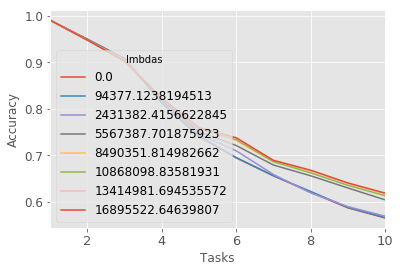

In [32]:
#fig, ax = plt.subplots(figsize=(4.5,2.5))
mpl.rcParams['figure.figsize'] = 6,4.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
df2.iloc[:,0:].plot()
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Tasks')

Text(0.5,0,'Tasks')

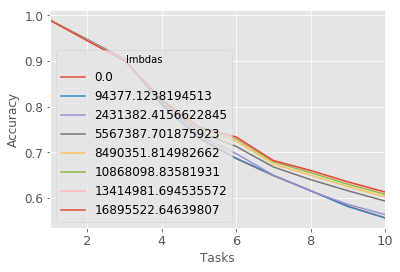

In [33]:
mpl.rcParams['figure.figsize'] = 6,4.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
df3.plot()
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Tasks')

In [34]:
Min = df1.iloc[:,7:].values[:,0]
Max = df2.iloc[:,7:].values[:,0]
Mean = df3.iloc[:,7:].values[:,0]
final_df = pd.DataFrame({'Min':Min, 'Max':Max, 'Mean':Mean})
final_df

,Max,Mean,Min
0,0.990000,0.989250,0.988000
1,0.947500,0.944333,0.942250
2,0.902333,0.900194,0.897500
3,0.822250,0.814271,0.802750
4,0.759600,0.754500,0.748000
5,0.738000,0.733514,0.730417
6,0.689500,0.681643,0.674429
7,0.668462,0.660150,0.654359
8,0.641105,0.635165,0.629651
9,0.619309,0.612846,0.604574


In [35]:
final_df.index.rename('Task', inplace=True)
final_df

,Max,Mean,Min
Task,,,
0,0.990000,0.989250,0.988000
1,0.947500,0.944333,0.942250
2,0.902333,0.900194,0.897500
3,0.822250,0.814271,0.802750
4,0.759600,0.754500,0.748000
5,0.738000,0.733514,0.730417
6,0.689500,0.681643,0.674429
7,0.668462,0.660150,0.654359
8,0.641105,0.635165,0.629651


In [36]:
task_splits

[(0, 4),
 (5, 9),
 (10, 14),
 (15, 19),
 (20, 24),
 (25, 29),
 (30, 34),
 (35, 38),
 (39, 42),
 (43, 46)]

In [37]:
final_df.index

RangeIndex(start=0, stop=10, step=1, name=u'Task')

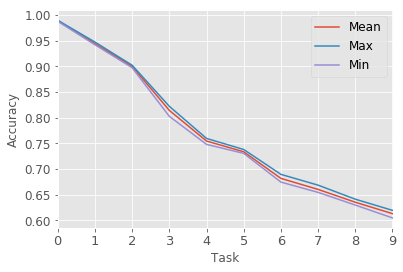

In [38]:
mpl.rcParams['figure.figsize'] = 6,4.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
ax = final_df.plot(y=['Mean','Max','Min'],x=final_df.index)
ax.set_xticks(final_df.index)
# [(0, 9), (10, 35), (36, 46)]
#ax.set_xticklabels([str(thing) for thing in task_splits])
ax.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
ax.set_ylabel('Accuracy')
#plt.savefig('../outputs/tg_mnist_results_cl/disjoint_accuracy.pdf', bbox_inches='tight')
#plt.savefig('../outputs/tg_mnist_results_cl/disjoint_accuracy.png', bbox_inches='tight')
#plt.savefig('../outputs/tg_mnist_results_cl/disjoint_accuracy.eps', bbox_inches='tight')
plt.show()

# Init the writer with  best $\lambda$s and train $10\%$ of previous samples

In [11]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/emnist/continual_learning/3sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_emnist_ar1_final_10pc_v6', sess.graph)

# Generate $\lambda$s 

In [12]:
np.random.seed(100)
n_lmbdas = 7
a = np.random.uniform(low=0.0, high=200, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e5
a = a[np.argsort(a)]
#a= a[-3:]
print(a)
print(type(a))
n_reps = 6
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[108.68098836  55.67387702  84.90351815 168.95522646   0.94377124
  24.31382416 134.14981695]
()
[   94377.12381945  2431382.41566228  5567387.70187592  8490351.81498266
 10868098.83581931 13414981.69453557 16895522.64639807]
<type 'numpy.ndarray'>
([0, 94377.1238194513, 2431382.4156622845, 5567387.701875923, 8490351.814982662, 10868098.83581931, 13414981.694535572, 16895522.64639807, 0, 94377.1238194513, 2431382.4156622845, 5567387.701875923, 8490351.814982662, 10868098.83581931, 13414981.694535572, 16895522.64639807, 0, 94377.1238194513, 2431382.4156622845, 5567387.701875923, 8490351.814982662, 10868098.83581931, 13414981.694535572, 16895522.64639807, 0, 94377.1238194513, 2431382.4156622845, 5567387.701875923, 8490351.814982662, 10868098.83581931, 13414981.694535572, 16895522.64639807, 0, 94377.1238194513, 2431382.4156622845, 5567387.701875923, 8490351.814982662, 10868098.83581931, 13414981.694535572, 16895522.64639807, 0, 94377.1238194513, 2431382.4156622845, 5567387.701875923, 8490

# Generate random weights 

In [13]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(48, 48)


In [14]:
np.array_equal(np_weights[0], np_weights[7])

True

In [15]:
np.array_equal(np_weights[0], np_weights[8])

False

In [16]:
np.array_equal(np_weights[8], np_weights[10])

True

# Splitting the dataset into tasks

In [17]:
print(labels_map)

task_splits = np.array_split(np.arange(num_classes), num_classes/4-1)

task_splits = [(item.tolist()[0], item.tolist()[-1]) for item in task_splits]
task_splits

# Commence training

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


[(0, 4),
 (5, 9),
 (10, 14),
 (15, 19),
 (20, 24),
 (25, 29),
 (30, 34),
 (35, 38),
 (39, 42),
 (43, 46)]

# Commence training

In [18]:
START_TIME = time.time()
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
all_prev_task_test_accs = []
all_prev_task_test_activs = []
all_prev_task_test_accs_extra = []
all_prev_task_test_activs_extra = []
retrain_tes_acc = []
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    frac_old_train_images = []
    frac_old_train_labels = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    #sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    sets = np.array_split(range(num_classes), int(num_classes/2))
    sets = [tuple(item.tolist()) for item in sets]
    sets = [(0, 9), (10, 35), (36, 46)]
    sets = task_splits
    test_labels_set = []
    prev_task_test_accs = []
    prev_task_test_activs = []
    prev_task_test_accs_extra = []
    prev_task_test_activs_extra = []
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 20
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==epochs-1):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)
                if(i%2==0):
                    print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                if(i%2==0):
                    print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})
                if(i%2==0):
                    print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            if(i==0):   
                                summary,_,_ = sess.run([merged,step, omega_step], 
                                                     feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                                  set1_mask:set_mask_val,eta:0.001,
                                                                  lmbda:lmbdas[l],n_tot:train_total,
                                                                 gradient_gate:1})
                            else:
                                summary,_, = sess.run([merged,step], 
                                                     feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                                  set1_mask:set_mask_val,eta:0.001,
                                                                  lmbda:lmbdas[l],n_tot:train_total,
                                                                 gradient_gate:1})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            if(i==0):
                                sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                         tau:0.5,set1_mask:set_mask_val,
                                                                         eta:0.001,lmbda:lmbdas[l],
                                                                         n_tot:train_total,
                                                                        gradient_gate:1})
                            else:
                                sess.run([step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total,
                                                            gradient_gate:1})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
        
        old_test_data.append(test_data_set)
        frac_old_train_images.append(train_images_set[0:int(len(train_images_set[0])*0.1),:])
        frac_old_train_labels.append(train_labels_set[0:int(len(train_images_set[0])*0.1),:])
        #######Method 3 ###########
        w3_set_rows = []
        offset=0
        #for item in w3_accum:
        #    w3_set_rows.append(item[:,offset:offset+2])
        #    offset+=2
        for v in range(len(w3_accum)):
            current_set = sets[v]
            w3_set_rows.append(w3_accum[v][:,offset:offset+(current_set[1]-current_set[0]+1)])
            offset+=current_set[1]-current_set[0]+1

        w3_set_row_avgs = [item.mean() for item in w3_set_rows]
        final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
        #final_w3 = np.concatenate(final_w3, axis=1)
        final_w3 = np.concatenate([item for item in final_w3]+[np.zeros((n_middle,n_out-offset))], axis=1)
        
        b3_set_rows = []
        offset=0
        #for item in b3_accum:
        #    b3_set_rows.append(item[:,offset:offset+2])
        #    offset+=2
        for v in range(len(b3_accum)):
            current_set = sets[v]
            b3_set_rows.append(b3_accum[v][:,offset:offset+(current_set[1]-current_set[0]+1)])
            offset+=current_set[1]-current_set[0]+1
            
        b3_set_row_avgs = [item.mean() for item in b3_set_rows]
        final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
        #final_b3 = np.concatenate(final_b3, axis=1)
        final_b3 = np.concatenate([item for item in final_b3]+[np.zeros((1,n_out-offset))], axis=1)
        
        #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
        #@@sess.run(set_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
        sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})
        
        for items in old_test_data:
            test_images_set, test_labels_set = items[0], items[1]
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, 
                                                  y:test_labels_set,
                                                  batch_size: len(test_images_set)})
            _,final_test_acc,final_test_activ = sess.run([predictions, acct_res, a_3],
                                      feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
            prev_task_test_accs.append(final_test_acc)
            prev_task_test_activs.append(final_test_activ)
            print('Method 3 test accuracy:{}'.format(final_test_acc))
        
        print('Extra training..')
        enlarged_train_imgs = np.concatenate(frac_old_train_images, axis=0)
        enlarged_train_lbls = np.concatenate(frac_old_train_labels, axis=0)
        extra_X, extra_y = shuffle(enlarged_train_imgs, enlarged_train_lbls, random_state=0)
        #extra_X = extra_X.astype(np.float32)
        #extra_y = extra_y.astype(np.float32)
        for rep in range(5):
            sess.run(iter.initializer, feed_dict={a_1: extra_X, y: extra_y,
                                                      batch_size: BATCH_SIZE})
            enlarged_batches = len(enlarged_train_imgs)/BATCH_SIZE
            for j in range(enlarged_batches):
                if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):        
                    sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                             tau:0.5,set1_mask:set_mask_val,
                                                             eta:0.001,lmbda:0,
                                                             n_tot:train_total,
                                                            gradient_gate:1.0})
                else:
                    print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
        
        for items in old_test_data:
            test_images_set, test_labels_set = items[0], items[1]
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, 
                                                  y:test_labels_set,
                                                  batch_size: len(test_images_set)})
            _,final_test_acc,final_test_activ = sess.run([predictions, acct_res, a_3],
                                      feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
            prev_task_test_accs_extra.append(final_test_acc)
            prev_task_test_activs_extra.append(final_test_activ)
            print('Method 3 test accuracy after extra trai:{}'.format(final_test_acc))
        
        w3_accum[-1] = w_3.eval()
        b3_accum[-1] = b_3.eval()
    
    all_prev_task_test_accs.append(prev_task_test_accs)
    all_prev_task_test_activs.append(prev_task_test_activs)
    
    all_prev_task_test_accs_extra.append(prev_task_test_accs_extra)
    all_prev_task_test_activs_extra.append(prev_task_test_activs_extra)
    
    #sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
    #                                                      batch_size: len(test_images)})
    #_,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
    #                              feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    #method3_test_accs.append(final_test_acc)
    #print('Final test accuracy before extra training:{}'.format(final_test_acc))
    
    #print('5pc training after sequential training is done')
    
    #sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
    #                                                      batch_size: len(test_images)})
    #_,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
    #                              feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    #method3_test_accs.append(final_test_acc)
    #print('Final test accuracy after extra training:{}'.format(final_test_acc))
    #retrain_tes_acc.append(final_test_acc)
                        
train_writer.close()
print('Total time:{}'.format(time.time()-START_TIME))

Training with lmbda:0, 0
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0365205183625 and training accuracy:0.992582440376
validation cost:0.0333814546466 and validation accuracy:0.991666674614
Training on :(0, 4)
training cost:0.0165944229811 and training accuracy:0.998534798622
validation cost:0.0144818034023 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0093383770436 and training accuracy:0.999542117119
validation cost:0.00829836912453 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00610721157864 and 

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.043296482414 and training accuracy:0.991483509541
validation cost:0.0541623234749 and validation accuracy:0.987962961197
Training on :(20, 24)
training cost:0.0230251550674 and training accuracy:0.996520161629
validation cost:0.0279534123838 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0140358135104 and training accuracy:0.998626351357
validation cost:0.0160389207304 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.00916942488402 and training accuracy:0.999450564384
validation cost:0.0096199484542 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.00659728283063 and training accur

Training on :(35, 38)
training cost:0.00577711965889 and training accuracy:1.0
validation cost:0.0062920562923 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00442744418979 and training accuracy:1.0
validation cost:0.00480788014829 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00356044783257 and training accuracy:1.0
validation cost:0.00385458115488 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00296079437248 and training accuracy:1.0
validation cost:0.0031983081717 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0025233279448 and training accuracy:1.0
validation cost:0.00272197369486 and validation accuracy:1.0
Training on :(35, 38)
Time taken:221.501070976
Method 3 test accuracy:0.878000020981
Method 3 test accuracy:0.903500020504
Method 3 test accuracy:0.855000019073
Method 3 test accuracy:0.67150002718
Method 3 test accuracy:0.551999986172
Method 3 test accuracy:0.702000021935
Method 3 test accuracy:0.7749

Training on :(0, 4)
training cost:0.00345107656904 and training accuracy:1.0
validation cost:0.00325590535067 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0027997365687 and training accuracy:1.0
validation cost:0.00263868784532 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00234182691202 and training accuracy:1.0
validation cost:0.00220151781105 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00200422620401 and training accuracy:1.0
validation cost:0.00187872804236 and validation accuracy:1.0
Training on :(0, 4)
Time taken:278.330226183
Method 3 test accuracy:0.987999975681
Extra training..
Method 3 test accuracy after extra trai:0.989000022411
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 363

training cost:0.00998252443969 and training accuracy:0.999816834927
validation cost:0.0105321807787 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00835175719112 and training accuracy:0.999908447266
validation cost:0.00876031443477 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00724993413314 and training accuracy:0.999908447266
validation cost:0.00757825002074 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00643814913929 and training accuracy:0.999908447266
validation cost:0.00671856151894 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00580758228898 and training accuracy:0.999908447266
validation cost:0.00606039818376 and validation accuracy:1.0
Training on :(20, 24)
Time taken:269.143920898
Method 3 test accuracy:0.886500000954
Method 3 test accuracy:0.919000029564
Method 3 test accuracy:0.861500024796
Method 3 test accuracy:0.708000004292
Method 3 test accuracy:0.503499984741
Extra training..
Method 3 test 

Method 3 test accuracy:0.787999987602
Method 3 test accuracy:0.429374992847
Extra training..
Method 3 test accuracy after extra trai:0.749000012875
Method 3 test accuracy after extra trai:0.833500027657
Method 3 test accuracy after extra trai:0.834500014782
Method 3 test accuracy after extra trai:0.769999980927
Method 3 test accuracy after extra trai:0.655499994755
Method 3 test accuracy after extra trai:0.837499976158
Method 3 test accuracy after extra trai:0.800000011921
Method 3 test accuracy after extra trai:0.830624997616
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
tra

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.054095055908 and training accuracy:0.991666674614
validation cost:0.0639397725463 and validation accuracy:0.986111104488
Training on :(5, 9)
training cost:0.0316102951765 and training accuracy:0.99642854929
validation cost:0.0378246642649 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0221576597542 and training accuracy:0.998901069164
validation cost:0.0264201741666 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0170468557626 and training accuracy:0.999633669853
validation cost:0.0201783888042 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.013856979087 and training accuracy:0.999725282192
validation cost:0.016205554828 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0116910357028 and training accuracy:0.999725282192
validation cost

Method 3 test accuracy:0.864000022411
Method 3 test accuracy:0.722500026226
Method 3 test accuracy:0.60799998045
Extra training..
Method 3 test accuracy after extra trai:0.78100001812
Method 3 test accuracy after extra trai:0.876999974251
Method 3 test accuracy after extra trai:0.855000019073
Method 3 test accuracy after extra trai:0.768000006676
Method 3 test accuracy after extra trai:0.73449999094
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0663672164083 and training accuracy:0.986446857452
validation cost:0.0718396902084 and validation accuracy:0.9814

Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0743752941489 and training accuracy:0.984203279018
validation cost:0.0849678069353 and validation accuracy:0.979166686535
Training on :(39, 42)
training cost:0.0514526702464 and training accuracy:0.990728020668
validation cost:0.0623953528702 and validation accuracy:0.986111104488
Training on :(39, 42)
training cost:0.040139939636 and training accuracy:0.992902934551
validation cost:0.049911685288 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.0330817326903 and training accuracy:0.994963347912
validation cost:0.0414881035686 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.028172839433 and training accuracy:0.99

training cost:0.0262772087008 and training accuracy:0.99761903286
validation cost:0.0312291495502 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0205901861191 and training accuracy:0.999267399311
validation cost:0.0244525354356 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0169579088688 and training accuracy:0.999633669853
validation cost:0.0200711227953 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0144264418632 and training accuracy:0.999725282192
validation cost:0.0169753357768 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0125639149919 and training accuracy:0.999725282192
validation cost:0.0146942716092 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0111504960805 and training accuracy:0.999725282192
validation cost:0.0129726883024 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.010050852783 and training accuracy:0.

Method 3 test accuracy after extra trai:0.728500008583
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0729461610317 and training accuracy:0.984706938267
validation cost:0.0781414434314 and validation accuracy:0.979629635811
Training on :(25, 29)
training cost:0.048483017832 and training accuracy:0.991208791733
validation cost:0.053361479193 and validation accuracy:0.987037062645
Training on :(25, 29)
training cost:0.0367310941219 and training accuracy:0.994047641754
validation cost:0.0406849272549 and validation accuracy:0.989814817905
Training on :(25, 29)

Training on :(39, 42)
training cost:0.0806924924254 and training accuracy:0.982257306576
validation cost:0.0904240608215 and validation accuracy:0.97685188055
Training on :(39, 42)
training cost:0.0563418157399 and training accuracy:0.989354372025
validation cost:0.0668257698417 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.0443302616477 and training accuracy:0.991872727871
validation cost:0.0538822263479 and validation accuracy:0.986111104488
Training on :(39, 42)
training cost:0.0367744602263 and training accuracy:0.993933141232
validation cost:0.0451212897897 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.031472902745 and training accuracy:0.995535731316
validation cost:0.038648430258 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.0274992007762 and training accuracy:0.996451437473
validation cost:0.0336369983852 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.024388

Training on :(5, 9)
training cost:0.0186713393778 and training accuracy:0.999358952045
validation cost:0.022176258266 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0159529745579 and training accuracy:0.999633669853
validation cost:0.0188985615969 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0139254415408 and training accuracy:0.999725282192
validation cost:0.016428142786 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0123649006709 and training accuracy:0.999725282192
validation cost:0.0145284542814 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0111332051456 and training accuracy:0.999725282192
validation cost:0.0130342161283 and validation accuracy:0.999074101448
Training on :(5, 9)
Time taken:270.280777931
Method 3 test accuracy:0.964500010014
Method 3 test accuracy:0.925000011921
Extra training..
Method 3 test accuracy after extra trai:0.963500022888
Method 3 test accur

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0754346698523 and training accuracy:0.98369961977
validation cost:0.0804931819439 and validation accuracy:0.978703677654
Training on :(25, 29)
training cost:0.0504224263132 and training accuracy:0.990659356117
validation cost:0.0552547499537 and validation accuracy:0.985185205936
Training on :(25, 29)
training cost:0.0383823513985 and training accuracy:0.993772864342
validation cost:0.0423046685755 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.0309714712203 and training accuracy:0.995329678059
validation cost:0.034138046205 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0259176734835 and training accuracy:0.996886432171
validation cost:0.0285164993256 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.0222611743957 and training accuracy:0.998076915741
v

Training on :(39, 42)
training cost:0.0458085648715 and training accuracy:0.991758227348
validation cost:0.0552140139043 and validation accuracy:0.986111104488
Training on :(39, 42)
training cost:0.038064610213 and training accuracy:0.99347525835
validation cost:0.0463036336005 and validation accuracy:0.987268507481
Training on :(39, 42)
training cost:0.0326179936528 and training accuracy:0.995077848434
validation cost:0.0397090613842 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.0285261813551 and training accuracy:0.996336996555
validation cost:0.0345916450024 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.025318281725 and training accuracy:0.997138261795
validation cost:0.0305163413286 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0227289590985 and training accuracy:0.997939586639
validation cost:0.0272176880389 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.020594

Training on :(5, 9)
training cost:0.0147254886106 and training accuracy:0.999725282192
validation cost:0.0174509249628 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0130831580609 and training accuracy:0.999725282192
validation cost:0.0154534867033 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.011780070141 and training accuracy:0.999725282192
validation cost:0.013871547766 and validation accuracy:0.999074101448
Training on :(5, 9)
Time taken:270.858745813
Method 3 test accuracy:0.959500014782
Method 3 test accuracy:0.926500022411
Extra training..
Method 3 test accuracy after extra trai:0.963500022888
Method 3 test accuracy after extra trai:0.952499985695
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid featu

Training on :(25, 29)
training cost:0.0513186827302 and training accuracy:0.990659356117
validation cost:0.0561140291393 and validation accuracy:0.985185205936
Training on :(25, 29)
training cost:0.0391400903463 and training accuracy:0.993681311607
validation cost:0.0430298596621 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.0316306762397 and training accuracy:0.995329678059
validation cost:0.0347633883357 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.026495333761 and training accuracy:0.996703267097
validation cost:0.0290593821555 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.022770954296 and training accuracy:0.997985363007
validation cost:0.024915035814 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0199484303594 and training accuracy:0.998351633549
validation cost:0.0217820648104 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.01773

Training on :(39, 42)
training cost:0.0331422798336 and training accuracy:0.995077848434
validation cost:0.0402096584439 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.0289939809591 and training accuracy:0.996336996555
validation cost:0.0350391715765 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0257396083325 and training accuracy:0.996909320354
validation cost:0.0309168323874 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.023111667484 and training accuracy:0.997939586639
validation cost:0.0275758113712 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0209444221109 and training accuracy:0.998740851879
validation cost:0.0248330980539 and validation accuracy:0.996527791023
Training on :(39, 42)
Time taken:213.415162086
Method 3 test accuracy:0.712999999523
Method 3 test accuracy:0.726999998093
Method 3 test accuracy:0.839999973774
Method 3 test accuracy:0.602999985218
Met

Training on :(5, 9)
training cost:0.0123330112547 and training accuracy:0.999725282192
validation cost:0.0145897986367 and validation accuracy:0.999074101448
Training on :(5, 9)
Time taken:270.01900506
Method 3 test accuracy:0.957499980927
Method 3 test accuracy:0.928499996662
Extra training..
Method 3 test accuracy after extra trai:0.962000012398
Method 3 test accuracy after extra trai:0.951499998569
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0833089575171 and training accuracy:0.98186814785
validation cost:0.102303057909 and validation accuracy:0.9703

Training on :(25, 29)
training cost:0.0320966430008 and training accuracy:0.995146512985
validation cost:0.0351897552609 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0269049219787 and training accuracy:0.996703267097
validation cost:0.0294288042933 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.0231335274875 and training accuracy:0.997802197933
validation cost:0.0252374950796 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0202724803239 and training accuracy:0.998260080814
validation cost:0.0220663435757 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0180284399539 and training accuracy:0.998992681503
validation cost:0.0195951443166 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0162204578519 and training accuracy:0.999358952045
validation cost:0.0176185350865 and validation accuracy:0.99722224474
Training on :(25, 29)
Time taken:270.22198

Training on :(39, 42)
training cost:0.0260552056134 and training accuracy:0.996680378914
validation cost:0.0312281399965 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0233975220472 and training accuracy:0.997825086117
validation cost:0.0278550758958 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0212054345757 and training accuracy:0.998626351357
validation cost:0.0250839702785 and validation accuracy:0.996527791023
Training on :(39, 42)
Time taken:213.427601099
Method 3 test accuracy:0.711000025272
Method 3 test accuracy:0.740999996662
Method 3 test accuracy:0.839999973774
Method 3 test accuracy:0.606999993324
Method 3 test accuracy:0.606500029564
Method 3 test accuracy:0.792999982834
Method 3 test accuracy:0.740999996662
Method 3 test accuracy:0.72000002861
Method 3 test accuracy:0.544375002384
Extra training..
Method 3 test accuracy after extra trai:0.721000015736
Method 3 test accuracy after extra trai:0.750500023365
Method

Method 3 test accuracy after extra trai:0.962000012398
Method 3 test accuracy after extra trai:0.950500011444
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0849576890469 and training accuracy:0.98131865263
validation cost:0.103988371789 and validation accuracy:0.96851849556
Training on :(10, 14)
training cost:0.057362858206 and training accuracy:0.988736271858
validation cost:0.0736155211926 and validation accuracy:0.978703677654
Training on :(10, 14)
training cost:0.04421672225 and training accuracy:0.9934065938
validation cost:0.0581245757639 and validat

Training on :(25, 29)
training cost:0.0234523564577 and training accuracy:0.997802197933
validation cost:0.0254852566868 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0205583125353 and training accuracy:0.998168468475
validation cost:0.0222844108939 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0182867255062 and training accuracy:0.99880951643
validation cost:0.019789705053 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0164553597569 and training accuracy:0.999267399311
validation cost:0.0177952460945 and validation accuracy:0.99722224474
Training on :(25, 29)
Time taken:270.325359106
Method 3 test accuracy:0.716000020504
Method 3 test accuracy:0.796000003815
Method 3 test accuracy:0.865999996662
Method 3 test accuracy:0.663999974728
Method 3 test accuracy:0.632499992847
Method 3 test accuracy:0.791999995708
Extra training..
Method 3 test accuracy after extra trai:0.787500023842
Method 3 test acc

Training on :(39, 42)
training cost:0.0214408561587 and training accuracy:0.998626351357
validation cost:0.025325961411 and validation accuracy:0.996527791023
Training on :(39, 42)
Time taken:213.139433861
Method 3 test accuracy:0.697499990463
Method 3 test accuracy:0.735000014305
Method 3 test accuracy:0.840499997139
Method 3 test accuracy:0.612999975681
Method 3 test accuracy:0.612999975681
Method 3 test accuracy:0.790499985218
Method 3 test accuracy:0.737500011921
Method 3 test accuracy:0.71875
Method 3 test accuracy:0.536249995232
Extra training..
Method 3 test accuracy after extra trai:0.720499992371
Method 3 test accuracy after extra trai:0.75150001049
Method 3 test accuracy after extra trai:0.774500012398
Method 3 test accuracy after extra trai:0.638499975204
Method 3 test accuracy after extra trai:0.643499970436
Method 3 test accuracy after extra trai:0.819999992847
Method 3 test accuracy after extra trai:0.772000014782
Method 3 test accuracy after extra trai:0.786875009537
Met

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0471216961741 and training accuracy:0.99029302597
validation cost:0.0630372166634 and validation accuracy:0.983333349228
Training on :(10, 14)
training cost:0.0220958590508 and training accuracy:0.99697804451
validation cost:0.031243423 and validation accuracy:0.992592573166
Training on :(10, 14)
training cost:0.0122863603756 and training accuracy:0.999725282192
validation cost:0.0171194411814 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.00800190214068 and training accuracy:1.0
validation cost:0.0107046822086 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00580739462748 and training accuracy:1.0
validation cost:0.00750413537025 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00450187036768 and training accuracy:1.0
validation cost:0.00569362193346 and validation accuracy

Method 3 test accuracy:0.882499992847
Method 3 test accuracy:0.648000001907
Method 3 test accuracy:0.538999974728
Method 3 test accuracy:0.463499993086
Extra training..
Method 3 test accuracy after extra trai:0.811500012875
Method 3 test accuracy after extra trai:0.857500016689
Method 3 test accuracy after extra trai:0.867999970913
Method 3 test accuracy after extra trai:0.764500021935
Method 3 test accuracy after extra trai:0.670000016689
Method 3 test accuracy after extra trai:0.841000020504
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.123553164303 and 

Method 3 test accuracy after extra trai:0.752499997616
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.0521779544652 and training accuracy:0.986149251461
validation cost:0.0583479329944 and validation accuracy:0.981481492519
Training on :(43, 46)
training cost:0.0287859607488 and training accuracy:0.99347525835
validation cost:0.0314959734678 and validation accuracy:0.990740716457
Training on :(43, 46)
training cost:0.0175185911357 and training accuracy:0.998168468475
validation cost:0.01903581433 and validation accuracy:0.997685194016
Training on :(43, 46)
trai

Training on :(10, 14)
training cost:0.00543768424541 and training accuracy:1.0
validation cost:0.00677411444485 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00491089140996 and training accuracy:1.0
validation cost:0.00606921641156 and validation accuracy:1.0
Training on :(10, 14)
Time taken:270.71413517
Method 3 test accuracy:0.936500012875
Method 3 test accuracy:0.923500001431
Method 3 test accuracy:0.855499982834
Extra training..
Method 3 test accuracy after extra trai:0.936999976635
Method 3 test accuracy after extra trai:0.92049998045
Method 3 test accuracy after extra trai:0.927500009537
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accu

Training on :(30, 34)
training cost:0.0768428221345 and training accuracy:0.978663027287
validation cost:0.0672066286206 and validation accuracy:0.979629635811
Training on :(30, 34)
training cost:0.0492085143924 and training accuracy:0.989010989666
validation cost:0.0427045747638 and validation accuracy:0.993518531322
Training on :(30, 34)
training cost:0.0340792238712 and training accuracy:0.99578756094
validation cost:0.0294033084065 and validation accuracy:0.998148143291
Training on :(30, 34)
training cost:0.0258555263281 and training accuracy:0.998076915741
validation cost:0.0220422130078 and validation accuracy:0.998148143291
Training on :(30, 34)
training cost:0.0210060030222 and training accuracy:0.999175846577
validation cost:0.017719110474 and validation accuracy:1.0
Training on :(30, 34)
training cost:0.0178002808243 and training accuracy:0.999633669853
validation cost:0.0148923946545 and validation accuracy:1.0
Training on :(30, 34)
training cost:0.0155201060697 and training

training cost:0.0178997237235 and training accuracy:0.999084234238
validation cost:0.0192882437259 and validation accuracy:0.998842597008
Training on :(43, 46)
training cost:0.0141826542094 and training accuracy:0.999771058559
validation cost:0.0153361717239 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.0118306074291 and training accuracy:1.0
validation cost:0.0128042642027 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.010236652568 and training accuracy:1.0
validation cost:0.0110747795552 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00907984189689 and training accuracy:1.0
validation cost:0.00981615670025 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00819882191718 and training accuracy:1.0
validation cost:0.00885105784982 and validation accuracy:1.0
Training on :(43, 46)
Time taken:213.673892975
Method 3 test accuracy:0.864000022411
Method 3 test accuracy:0.846499979496
Method 3 test accuracy:0.8694999814

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.0998953208327 and training accuracy:0.974542140961
validation cost:0.115220144391 and validation accuracy:0.967592597008
Training on :(15, 19)
training cost:0.0702477619052 and training accuracy:0.983150184155
validation cost:0.0825180932879 and validation accuracy:0.977777779102
Training on :(15, 19)
training cost:0.054922606796 and training accuracy:0.988003671169
validation cost:0.0655076354742 and validation accuracy:0.98425924778
Training on :(15, 19)
training cost:0.0450254939497 and training accuracy:0.990476191044
validation cost:0.0543429143727 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.038027971983 and training accuracy:0

Training on :(30, 34)
training cost:0.0675708800554 and training accuracy:0.98369961977
validation cost:0.0593603774905 and validation accuracy:0.987037062645
Training on :(30, 34)
training cost:0.0603977963328 and training accuracy:0.986630022526
validation cost:0.0530045479536 and validation accuracy:0.989814817905
Training on :(30, 34)
training cost:0.054557453841 and training accuracy:0.988919436932
validation cost:0.0478763915598 and validation accuracy:0.992592573166
Training on :(30, 34)
training cost:0.0497478209436 and training accuracy:0.991849839687
validation cost:0.0436336100101 and validation accuracy:0.995370388031
Training on :(30, 34)
Time taken:270.363607168
Method 3 test accuracy:0.741999983788
Method 3 test accuracy:0.800499975681
Method 3 test accuracy:0.820500016212
Method 3 test accuracy:0.64050000906
Method 3 test accuracy:0.502499997616
Method 3 test accuracy:0.754999995232
Method 3 test accuracy:0.706499993801
Extra training..
Method 3 test accuracy after extr

training cost:0.029435576871 and training accuracy:0.996336996555
validation cost:0.0324452780187 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0263889115304 and training accuracy:0.997367203236
validation cost:0.0290814079344 and validation accuracy:0.995370388031
Training on :(43, 46)
training cost:0.0238881651312 and training accuracy:0.998054027557
validation cost:0.0263339113444 and validation accuracy:0.997685194016
Training on :(43, 46)
Time taken:213.635047913
Method 3 test accuracy:0.774999976158
Method 3 test accuracy:0.768499970436
Method 3 test accuracy:0.840499997139
Method 3 test accuracy:0.601000010967
Method 3 test accuracy:0.489499986172
Method 3 test accuracy:0.754999995232
Method 3 test accuracy:0.739000022411
Method 3 test accuracy:0.716250002384
Method 3 test accuracy:0.598124980927
Method 3 test accuracy:0.486874997616
Extra training..
Method 3 test accuracy after extra trai:0.714500010014
Method 3 test accuracy after extra trai:0.73

training cost:0.107088953257 and training accuracy:0.972619056702
validation cost:0.12250456959 and validation accuracy:0.966666638851
Training on :(15, 19)
training cost:0.0774835050106 and training accuracy:0.98067766428
validation cost:0.0897580161691 and validation accuracy:0.975000023842
Training on :(15, 19)
training cost:0.0621766485274 and training accuracy:0.985897421837
validation cost:0.0727388560772 and validation accuracy:0.981481492519
Training on :(15, 19)
training cost:0.0521765723825 and training accuracy:0.988736271858
validation cost:0.0615920461714 and validation accuracy:0.986111104488
Training on :(15, 19)
training cost:0.0449652038515 and training accuracy:0.990476191044
validation cost:0.0534845031798 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0394950099289 and training accuracy:0.992216110229
validation cost:0.0472290739417 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0352118983865 and training a

Training on :(30, 34)
training cost:0.0658108144999 and training accuracy:0.983608067036
validation cost:0.0559525452554 and validation accuracy:0.987962961197
Training on :(30, 34)
training cost:0.0607488378882 and training accuracy:0.985714256763
validation cost:0.0515005327761 and validation accuracy:0.988888859749
Training on :(30, 34)
Time taken:270.937756062
Method 3 test accuracy:0.757000029087
Method 3 test accuracy:0.721499979496
Method 3 test accuracy:0.801999986172
Method 3 test accuracy:0.643499970436
Method 3 test accuracy:0.541499972343
Method 3 test accuracy:0.771000027657
Method 3 test accuracy:0.707000017166
Extra training..
Method 3 test accuracy after extra trai:0.753000020981
Method 3 test accuracy after extra trai:0.832499980927
Method 3 test accuracy after extra trai:0.82950001955
Method 3 test accuracy after extra trai:0.735499978065
Method 3 test accuracy after extra trai:0.647000014782
Method 3 test accuracy after extra trai:0.835500001907
Method 3 test accurac

Training on :(43, 46)
training cost:0.0270594954491 and training accuracy:0.997596144676
validation cost:0.0291843768209 and validation accuracy:0.995370388031
Training on :(43, 46)
Time taken:213.853641987
Method 3 test accuracy:0.791999995708
Method 3 test accuracy:0.670000016689
Method 3 test accuracy:0.816500008106
Method 3 test accuracy:0.592000007629
Method 3 test accuracy:0.52999997139
Method 3 test accuracy:0.769500017166
Method 3 test accuracy:0.743499994278
Method 3 test accuracy:0.738125026226
Method 3 test accuracy:0.616249978542
Method 3 test accuracy:0.519999980927
Extra training..
Method 3 test accuracy after extra trai:0.714500010014
Method 3 test accuracy after extra trai:0.72000002861
Method 3 test accuracy after extra trai:0.785499989986
Method 3 test accuracy after extra trai:0.653500020504
Method 3 test accuracy after extra trai:0.635500013828
Method 3 test accuracy after extra trai:0.797500014305
Method 3 test accuracy after extra trai:0.77999997139
Method 3 test 

Training on :(15, 19)
training cost:0.0650282278657 and training accuracy:0.984523832798
validation cost:0.075365036726 and validation accuracy:0.981481492519
Training on :(15, 19)
training cost:0.0549745447934 and training accuracy:0.988278388977
validation cost:0.0641745850444 and validation accuracy:0.986111104488
Training on :(15, 19)
training cost:0.0477014407516 and training accuracy:0.989652037621
validation cost:0.0560477301478 and validation accuracy:0.986111104488
Training on :(15, 19)
training cost:0.0421576313674 and training accuracy:0.991300344467
validation cost:0.0497876890004 and validation accuracy:0.988888859749
Training on :(15, 19)
training cost:0.0377796888351 and training accuracy:0.992673993111
validation cost:0.0447805523872 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0342449583113 and training accuracy:0.994047641754
validation cost:0.0406725145876 and validation accuracy:0.992592573166
Training on :(15, 19)
training cost:0.031

training cost:0.063938729465 and training accuracy:0.984157502651
validation cost:0.0533613227308 and validation accuracy:0.988888859749
Training on :(30, 34)
Time taken:269.911178827
Method 3 test accuracy:0.755500018597
Method 3 test accuracy:0.75
Method 3 test accuracy:0.808499991894
Method 3 test accuracy:0.649500012398
Method 3 test accuracy:0.549499988556
Method 3 test accuracy:0.768000006676
Method 3 test accuracy:0.690500020981
Extra training..
Method 3 test accuracy after extra trai:0.75150001049
Method 3 test accuracy after extra trai:0.832499980927
Method 3 test accuracy after extra trai:0.82950001955
Method 3 test accuracy after extra trai:0.731999993324
Method 3 test accuracy after extra trai:0.647000014782
Method 3 test accuracy after extra trai:0.82950001955
Method 3 test accuracy after extra trai:0.801500022411
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test

Method 3 test accuracy:0.815999984741
Method 3 test accuracy:0.59350001812
Method 3 test accuracy:0.536499977112
Method 3 test accuracy:0.763999998569
Method 3 test accuracy:0.73400002718
Method 3 test accuracy:0.747500002384
Method 3 test accuracy:0.617500007153
Method 3 test accuracy:0.509999990463
Extra training..
Method 3 test accuracy after extra trai:0.712499976158
Method 3 test accuracy after extra trai:0.719500005245
Method 3 test accuracy after extra trai:0.783500015736
Method 3 test accuracy after extra trai:0.649999976158
Method 3 test accuracy after extra trai:0.634999990463
Method 3 test accuracy after extra trai:0.794499993324
Method 3 test accuracy after extra trai:0.779500007629
Method 3 test accuracy after extra trai:0.796875
Method 3 test accuracy after extra trai:0.660624980927
Method 3 test accuracy after extra trai:0.660000026226
Training with lmbda:10868098.8358, 13
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

Training on :(15, 19)
training cost:0.0489978119731 and training accuracy:0.9891025424
validation cost:0.0571870282292 and validation accuracy:0.986111104488
Training on :(15, 19)
training cost:0.0434167161584 and training accuracy:0.991025626659
validation cost:0.050919432193 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0390035994351 and training accuracy:0.992124557495
validation cost:0.0459052547812 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0354292467237 and training accuracy:0.993223428726
validation cost:0.0417901091278 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0324811451137 and training accuracy:0.994505465031
validation cost:0.0383500307798 and validation accuracy:0.993518531322
Training on :(15, 19)
Time taken:270.856051922
Method 3 test accuracy:0.85949999094
Method 3 test accuracy:0.84249997139
Method 3 test accuracy:0.875500023365
Method 3 test accuracy:0.693499982357
Extra 

Method 3 test accuracy:0.690500020981
Extra training..
Method 3 test accuracy after extra trai:0.75150001049
Method 3 test accuracy after extra trai:0.832499980927
Method 3 test accuracy after extra trai:0.82800000906
Method 3 test accuracy after extra trai:0.731500029564
Method 3 test accuracy after extra trai:0.644999980927
Method 3 test accuracy after extra trai:0.82849997282
Method 3 test accuracy after extra trai:0.800999999046
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0715955942869 and training accuracy:0.983173072338
validation cost:0.0786964297295 

Method 3 test accuracy after extra trai:0.712000012398
Method 3 test accuracy after extra trai:0.717000007629
Method 3 test accuracy after extra trai:0.78100001812
Method 3 test accuracy after extra trai:0.647000014782
Method 3 test accuracy after extra trai:0.635999977589
Method 3 test accuracy after extra trai:0.794000029564
Method 3 test accuracy after extra trai:0.778500020504
Method 3 test accuracy after extra trai:0.795000016689
Method 3 test accuracy after extra trai:0.660624980927
Method 3 test accuracy after extra trai:0.659375011921
Training with lmbda:13414981.6945, 14
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost

Training on :(15, 19)
training cost:0.0398911312222 and training accuracy:0.992032945156
validation cost:0.0466926544905 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0362902730703 and training accuracy:0.992765545845
validation cost:0.0425719209015 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0333161354065 and training accuracy:0.994047641754
validation cost:0.0391155779362 and validation accuracy:0.991666674614
Training on :(15, 19)
Time taken:270.759363174
Method 3 test accuracy:0.852500021458
Method 3 test accuracy:0.851499974728
Method 3 test accuracy:0.87650001049
Method 3 test accuracy:0.688000023365
Extra training..
Method 3 test accuracy after extra trai:0.873000025749
Method 3 test accuracy after extra trai:0.879499971867
Method 3 test accuracy after extra trai:0.864499986172
Method 3 test accuracy after extra trai:0.805499970913
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Method 3 test accuracy after extra trai:0.646499991417
Method 3 test accuracy after extra trai:0.826499998569
Method 3 test accuracy after extra trai:0.800499975681
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0721077397466 and training accuracy:0.983173072338
validation cost:0.0791542083025 and validation accuracy:0.979142546654
Training on :(35, 38)
training cost:0.0495924465358 and training accuracy:0.989812254906
validation cost:0.0543982870877 and validation accuracy:0.987253785133
Training on :(35, 38)
training cost:0.0384005643427 and training accuracy

Method 3 test accuracy after extra trai:0.659375011921
Method 3 test accuracy after extra trai:0.658749997616
Training with lmbda:16895522.6464, 15
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0355046316981 and training accuracy:0.993589758873
validation cost:0.0335519351065 and validation accuracy:0.992592573166
Training on :(0, 4)
training cost:0.0164138730615 and training accuracy:0.997985363007
validation cost:0.0156665090472 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.00932078622282 and training accur

Training on :(15, 19)
Time taken:272.112866163
Method 3 test accuracy:0.847000002861
Method 3 test accuracy:0.856999993324
Method 3 test accuracy:0.877499997616
Method 3 test accuracy:0.683000028133
Extra training..
Method 3 test accuracy after extra trai:0.872500002384
Method 3 test accuracy after extra trai:0.878499984741
Method 3 test accuracy after extra trai:0.864000022411
Method 3 test accuracy after extra trai:0.804499983788
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0837417542934 and training accuracy:0.982142865658
validation cost:0.09449535608

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0725680068135 and training accuracy:0.982715189457
validation cost:0.0795611292124 and validation accuracy:0.979142546654
Training on :(35, 38)
training cost:0.0499466843903 and training accuracy:0.989812254906
validation cost:0.0546957552433 and validation accuracy:0.987253785133
Training on :(35, 38)
training cost:0.0386973358691 and training accuracy:0.992559552193
validation cost:0.0419218726456 and validation accuracy:0.990729987621
Training on :(35, 38)
training cost:0.0315667949617 and training accuracy:0.994619965553
validation cost:0.0339264720678 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0265702940524 and training accuracy:0.996451437473
validation cost:0.0284783951938 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0228710062802 and training accuracy:0.997825086117

training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0364198386669 and training accuracy:0.993681311607
validation cost:0.0359098501503 and validation accuracy:0.992592573166
Training on :(0, 4)
training cost:0.0165302548558 and training accuracy:0.997893750668
validation cost:0.015737131238 and validation accuracy:0.996296286583
Training on :(0, 4)
training cost:0.00927482172847 and training accuracy:0.999725282192
validation cost:0.00873152259737 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00603256095201 and training accuracy:1.0
validation cost:0.00575694767758 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.004366743844 and training accuracy:1.0
validation cost:0.00420594774187 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00338846398517 and training accuracy:1.0
validation cost:0.00327685847878 and validation accu

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0434826761484 and training accuracy:0.992032945156
validation cost:0.0565259754658 and validation accuracy:0.987037062645
Training on :(20, 24)
training cost:0.0235288348049 and training accuracy:0.997069597244
validation cost:0.029616849497 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0140240220353 and training accuracy:0.998351633549
validation cost:0.0156988017261 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.00913453288376 and training accuracy:0.999358952045
validation cost:0.00936664175242 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.006664655637 and training accuracy:0.999908447266
validation cost:0.00664290832356 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00517068710178 and training accuracy:0.999908447266
validation cost:0.00

Training on :(35, 38)
training cost:0.00352971325628 and training accuracy:1.0
validation cost:0.00396224763244 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00294431392103 and training accuracy:1.0
validation cost:0.00330255576409 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00251388200559 and training accuracy:1.0
validation cost:0.00282164500095 and validation accuracy:1.0
Training on :(35, 38)
Time taken:213.545009136
Method 3 test accuracy:0.898999989033
Method 3 test accuracy:0.886500000954
Method 3 test accuracy:0.869000017643
Method 3 test accuracy:0.677500009537
Method 3 test accuracy:0.511500000954
Method 3 test accuracy:0.678499996662
Method 3 test accuracy:0.782999992371
Method 3 test accuracy:0.398750007153
Extra training..
Method 3 test accuracy after extra trai:0.743499994278
Method 3 test accuracy after extra trai:0.824000000954
Method 3 test accuracy after extra trai:0.851999998093
Method 3 test accuracy after extra trai:0.77600

Training on :(0, 4)
training cost:0.00230149016716 and training accuracy:1.0
validation cost:0.00222453498282 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00197135494091 and training accuracy:1.0
validation cost:0.00190164404921 and validation accuracy:1.0
Training on :(0, 4)
Time taken:270.244242907
Method 3 test accuracy:0.990000009537
Extra training..
Method 3 test accuracy after extra trai:0.989499986172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0414115190506 and training accuracy:0.993315041065
validation cost:0.0510199069977 and 

Training on :(20, 24)
training cost:0.00754097476602 and training accuracy:0.999908447266
validation cost:0.00754506140947 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00668725930154 and training accuracy:0.999908447266
validation cost:0.00665764790028 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00601840857416 and training accuracy:1.0
validation cost:0.00597255304456 and validation accuracy:1.0
Training on :(20, 24)
Time taken:270.308980942
Method 3 test accuracy:0.912999987602
Method 3 test accuracy:0.90499997139
Method 3 test accuracy:0.85900002718
Method 3 test accuracy:0.717999994755
Method 3 test accuracy:0.471500009298
Extra training..
Method 3 test accuracy after extra trai:0.774500012398
Method 3 test accuracy after extra trai:0.893499970436
Method 3 test accuracy after extra trai:0.875
Method 3 test accuracy after extra trai:0.78149998188
Method 3 test accuracy after extra trai:0.757000029087
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 

Method 3 test accuracy after extra trai:0.648000001907
Method 3 test accuracy after extra trai:0.82800000906
Method 3 test accuracy after extra trai:0.805999994278
Method 3 test accuracy after extra trai:0.84249997139
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0461162663996 and training accuracy:0.990499079227
validation cost:0.0614338256419 and validation accuracy:0.979166686535
Training on :(39, 42)
training cost:0.02813038975 and training accuracy:0.995306789875
validation cost:0.0383207537234 and validation accuracy:0.989583313465
Training on :(39, 42)


Training on :(5, 9)
training cost:0.0303704291582 and training accuracy:0.996520161629
validation cost:0.0365150496364 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0213869567961 and training accuracy:0.998534798622
validation cost:0.0254638977349 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0165701024234 and training accuracy:0.999450564384
validation cost:0.0195090938359 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0135966259986 and training accuracy:0.999633669853
validation cost:0.0158538874239 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.011590603739 and training accuracy:0.999816834927
validation cost:0.0134319812059 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0101494342089 and training accuracy:0.999816834927
validation cost:0.0117238266394 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00906004570425 and training accuracy:0.

Method 3 test accuracy after extra trai:0.730499982834
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0671800076962 and training accuracy:0.986355304718
validation cost:0.0715774297714 and validation accuracy:0.986111104488
Training on :(25, 29)
training cost:0.0441619828343 and training accuracy:0.992673993111
validation cost:0.0478886589408 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.0332154594362 and training accuracy:0.995695948601
validation cost:0.0359519980848 and validation accuracy:0.990740716457
Training on :(25, 2

Training on :(39, 42)
training cost:0.0734081417322 and training accuracy:0.9840888381
validation cost:0.0891092270613 and validation accuracy:0.975694417953
Training on :(39, 42)
training cost:0.0512998402119 and training accuracy:0.990270137787
validation cost:0.0654755830765 and validation accuracy:0.981481492519
Training on :(39, 42)
training cost:0.0406159088016 and training accuracy:0.993933141232
validation cost:0.052694991231 and validation accuracy:0.989583313465
Training on :(39, 42)
training cost:0.0337787047029 and training accuracy:0.995192289352
validation cost:0.0440242439508 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.0288986694068 and training accuracy:0.995993614197
validation cost:0.0376029312611 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0252256114036 and training accuracy:0.996680378914
validation cost:0.0326364673674 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.022367

Training on :(5, 9)
training cost:0.0165445599705 and training accuracy:0.999450564384
validation cost:0.0195713974535 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0141623783857 and training accuracy:0.999633669853
validation cost:0.0166651513427 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.012421425432 and training accuracy:0.999816834927
validation cost:0.0145593285561 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0110923303291 and training accuracy:0.999816834927
validation cost:0.0129689089954 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0100433798507 and training accuracy:0.999816834927
validation cost:0.0117251994088 and validation accuracy:1.0
Training on :(5, 9)
Time taken:271.301599026
Method 3 test accuracy:0.961499989033
Method 3 test accuracy:0.919499993324
Extra training..
Method 3 test accuracy after extra trai:0.962000012398
Method 3 test accuracy after extra trai:0.948499977

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0739644020796 and training accuracy:0.984706938267
validation cost:0.0779815092683 and validation accuracy:0.983333349228
Training on :(25, 29)
training cost:0.0496940203011 and training accuracy:0.990842461586
validation cost:0.0533016882837 and validation accuracy:0.988888859749
Training on :(25, 29)
training cost:0.0380283482373 and training accuracy:0.993772864342
validation cost:0.0407106466591 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.0308844354004 and training accuracy:0.99642854929
validation cost:0.0328586362302 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0259991269559 and training accuracy:0.997344315052
validation cost:0.0275347661227 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0224288217723 and training accuracy:0.997710645199


training cost:0.0452608689666 and training accuracy:0.992216110229
validation cost:0.0575819090009 and validation accuracy:0.987268507481
Training on :(39, 42)
training cost:0.0379335507751 and training accuracy:0.994391024113
validation cost:0.0484021157026 and validation accuracy:0.989583313465
Training on :(39, 42)
training cost:0.032677963376 and training accuracy:0.995306789875
validation cost:0.0415961816907 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0286840572953 and training accuracy:0.995993614197
validation cost:0.0363073907793 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0255420915782 and training accuracy:0.996909320354
validation cost:0.0320806391537 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0230050943792 and training accuracy:0.997939586639
validation cost:0.0286338496953 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0209108889103 and training

Training on :(5, 9)
training cost:0.0136717101559 and training accuracy:0.999542117119
validation cost:0.0161165501922 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0122125195339 and training accuracy:0.999816834927
validation cost:0.014351259917 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.011055408977 and training accuracy:0.999816834927
validation cost:0.0129645615816 and validation accuracy:1.0
Training on :(5, 9)
Time taken:270.915651083
Method 3 test accuracy:0.955999970436
Method 3 test accuracy:0.925999999046
Extra training..
Method 3 test accuracy after extra trai:0.960500001907
Method 3 test accuracy after extra trai:0.949999988079
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Lengt

Training on :(25, 29)
training cost:0.0516500063241 and training accuracy:0.990567743778
validation cost:0.0552055984735 and validation accuracy:0.987962961197
Training on :(25, 29)
training cost:0.0397173203528 and training accuracy:0.993131875992
validation cost:0.0423526465893 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.0323720276356 and training accuracy:0.995970666409
validation cost:0.0342786349356 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0273198802024 and training accuracy:0.997161149979
validation cost:0.02876496315 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0236091390252 and training accuracy:0.997527480125
validation cost:0.0247838627547 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.02076311782 and training accuracy:0.998076915741
validation cost:0.0217790473253 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.018510

Training on :(39, 42)
training cost:0.0338938087225 and training accuracy:0.995192289352
validation cost:0.0427816212177 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0297878105193 and training accuracy:0.995650172234
validation cost:0.037380553782 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0265497732908 and training accuracy:0.996794879436
validation cost:0.03305676952 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0239296685904 and training accuracy:0.997252762318
validation cost:0.0295275356621 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0217641368508 and training accuracy:0.998282968998
validation cost:0.026601722464 and validation accuracy:0.995370388031
Training on :(39, 42)
Time taken:213.928644896
Method 3 test accuracy:0.763499975204
Method 3 test accuracy:0.772499978542
Method 3 test accuracy:0.840499997139
Method 3 test accuracy:0.59399998188
Method 

Training on :(5, 9)
training cost:0.0116631193087 and training accuracy:0.999816834927
validation cost:0.0136979874223 and validation accuracy:1.0
Training on :(5, 9)
Time taken:270.203574896
Method 3 test accuracy:0.952499985695
Method 3 test accuracy:0.927999973297
Extra training..
Method 3 test accuracy after extra trai:0.959999978542
Method 3 test accuracy after extra trai:0.949500024319
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0806899219751 and training accuracy:0.982234418392
validation cost:0.0954759269953 and validation accuracy:0.975000023842

Training on :(25, 29)
training cost:0.0330660268664 and training accuracy:0.995421230793
validation cost:0.034953225404 and validation accuracy:0.990740716457
Training on :(25, 29)
training cost:0.0279369335622 and training accuracy:0.997069597244
validation cost:0.0293471962214 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0241611599922 and training accuracy:0.997527480125
validation cost:0.0252903811634 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0212592426687 and training accuracy:0.997985363007
validation cost:0.0222226381302 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0189581625164 and training accuracy:0.998626351357
validation cost:0.0198218282312 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0170877482742 and training accuracy:0.998992681503
validation cost:0.0178921408951 and validation accuracy:0.998148143291
Training on :(25, 29)
Time taken:270.23162

Training on :(39, 42)
training cost:0.0270335227251 and training accuracy:0.996451437473
validation cost:0.0335172861814 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0243729315698 and training accuracy:0.997138261795
validation cost:0.0299469511956 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0221729241312 and training accuracy:0.998168468475
validation cost:0.0269864052534 and validation accuracy:0.995370388031
Training on :(39, 42)
Time taken:213.130361795
Method 3 test accuracy:0.763000011444
Method 3 test accuracy:0.780499994755
Method 3 test accuracy:0.826499998569
Method 3 test accuracy:0.606000006199
Method 3 test accuracy:0.544499993324
Method 3 test accuracy:0.757000029087
Method 3 test accuracy:0.759999990463
Method 3 test accuracy:0.756874978542
Method 3 test accuracy:0.548749983311
Extra training..
Method 3 test accuracy after extra trai:0.717000007629
Method 3 test accuracy after extra trai:0.751999974251
Meth

Method 3 test accuracy after extra trai:0.959999978542
Method 3 test accuracy after extra trai:0.949000000954
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.082174025476 and training accuracy:0.981684982777
validation cost:0.096995010972 and validation accuracy:0.974074065685
Training on :(10, 14)
training cost:0.0560805760324 and training accuracy:0.989010989666
validation cost:0.0674994364381 and validation accuracy:0.981481492519
Training on :(10, 14)
training cost:0.0433432273567 and training accuracy:0.992216110229
validation cost:0.0522865690291 and v

Training on :(25, 29)
training cost:0.0245428197086 and training accuracy:0.997435867786
validation cost:0.0256276708096 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0216029249132 and training accuracy:0.997985363007
validation cost:0.0225201305002 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0192694496363 and training accuracy:0.998534798622
validation cost:0.0200862027705 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0173714458942 and training accuracy:0.998901069164
validation cost:0.0181284826249 and validation accuracy:0.998148143291
Training on :(25, 29)
Time taken:270.340965986
Method 3 test accuracy:0.788999974728
Method 3 test accuracy:0.840499997139
Method 3 test accuracy:0.861999988556
Method 3 test accuracy:0.668500006199
Method 3 test accuracy:0.572000026703
Method 3 test accuracy:0.757000029087
Extra training..
Method 3 test accuracy after extra trai:0.790000021458
Method 3 test

Training on :(39, 42)
training cost:0.0224472116679 and training accuracy:0.998168468475
validation cost:0.0272259954363 and validation accuracy:0.995370388031
Training on :(39, 42)
Time taken:213.77342701
Method 3 test accuracy:0.759999990463
Method 3 test accuracy:0.776499986649
Method 3 test accuracy:0.832499980927
Method 3 test accuracy:0.602500021458
Method 3 test accuracy:0.54549998045
Method 3 test accuracy:0.758499979973
Method 3 test accuracy:0.753000020981
Method 3 test accuracy:0.759374976158
Method 3 test accuracy:0.551249980927
Extra training..
Method 3 test accuracy after extra trai:0.716499984264
Method 3 test accuracy after extra trai:0.75150001049
Method 3 test accuracy after extra trai:0.796000003815
Method 3 test accuracy after extra trai:0.634000003338
Method 3 test accuracy after extra trai:0.629999995232
Method 3 test accuracy after extra trai:0.799000024796
Method 3 test accuracy after extra trai:0.790000021458
Method 3 test accuracy after extra trai:0.8206250071

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0836277157068 and training accuracy:0.981135547161
validation cost:0.0984525904059 and validation accuracy:0.974074065685
Training on :(10, 14)
training cost:0.0572740323842 and training accuracy:0.988553106785
validation cost:0.0687478780746 and validation accuracy:0.980555534363
Training on :(10, 14)
training cost:0.0443966016173 and training accuracy:0.991758227348
validation cost:0.053397372365 and validation accuracy:0.987037062645
Training on :(10, 14)
training cost:0.0363059677184 and training accuracy:0.994139194489
validation cost:0.0436023660004 and validation accuracy:0.989814817905
Training on :(10, 14)
training cost:0.0306626372039 and training accuracy:0.995695948601
validation cost:0.0367513038218 and validation accuracy:0.992592573166
Training on :(10, 14)
training cost:0.0264912527055 and training accuracy:0.99697804451
v

training cost:0.0195514187217 and training accuracy:0.998534798622
validation cost:0.0203223396093 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0176285207272 and training accuracy:0.99880951643
validation cost:0.0183390993625 and validation accuracy:0.99722224474
Training on :(25, 29)
Time taken:270.992166996
Method 3 test accuracy:0.783500015736
Method 3 test accuracy:0.838999986649
Method 3 test accuracy:0.861999988556
Method 3 test accuracy:0.663500010967
Method 3 test accuracy:0.578999996185
Method 3 test accuracy:0.760999977589
Extra training..
Method 3 test accuracy after extra trai:0.790499985218
Method 3 test accuracy after extra trai:0.851499974728
Method 3 test accuracy after extra trai:0.856999993324
Method 3 test accuracy after extra trai:0.73400002718
Method 3 test accuracy after extra trai:0.660000026226
Method 3 test accuracy after extra trai:0.819999992847
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

Method 3 test accuracy:0.754000008106
Method 3 test accuracy:0.76437497139
Method 3 test accuracy:0.453125
Extra training..
Method 3 test accuracy after extra trai:0.716499984264
Method 3 test accuracy after extra trai:0.754499971867
Method 3 test accuracy after extra trai:0.79549998045
Method 3 test accuracy after extra trai:0.635999977589
Method 3 test accuracy after extra trai:0.632000029087
Method 3 test accuracy after extra trai:0.799000024796
Method 3 test accuracy after extra trai:0.788500010967
Method 3 test accuracy after extra trai:0.819374978542
Method 3 test accuracy after extra trai:0.709999978542
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.

Training on :(10, 14)
training cost:0.0123443109915 and training accuracy:0.999633669853
validation cost:0.0152000440285 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.00808010064065 and training accuracy:0.999816834927
validation cost:0.00997849553823 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00583757460117 and training accuracy:1.0
validation cost:0.00715724984184 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00451755430549 and training accuracy:1.0
validation cost:0.00546770077199 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00365406717174 and training accuracy:1.0
validation cost:0.00437404029071 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00304906489328 and training accuracy:1.0
validation cost:0.00361822452396 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00260410783812 and training accuracy:1.0
validation cost:0.00306967180222 and validation ac

Method 3 test accuracy after extra trai:0.684000015259
Method 3 test accuracy after extra trai:0.850000023842
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.120350465178 and training accuracy:0.964468836784
validation cost:0.114942975342 and validation accuracy:0.962962985039
Training on :(30, 34)
training cost:0.0693842172623 and training accuracy:0.98131865263
validation cost:0.0644643828273 and validation accuracy:0.982407391071
Training on :(30, 34)
training cost:0.0395248010755 and training accuracy:0.991391956806
validation cost:0.0361307933927 and va

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.0530387051404 and training accuracy:0.986950576305
validation cost:0.0655161738396 and validation accuracy:0.980324089527
Training on :(43, 46)
training cost:0.0282430015504 and training accuracy:0.993360817432
validation cost:0.0359064489603 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0165356397629 and training accuracy:0.998397409916
validation cost:0.0203987322748 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0106860389933 and training accuracy:0.999885559082
validation cost:0.0126255173236 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00752180302516 and training accuracy:1.0
validation cost:0.00857263896614 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00568102439865 and training accuracy:1.0
validation cost:0.00632601371035 and val

Training on :(10, 14)
Time taken:270.775551796
Method 3 test accuracy:0.930499970913
Method 3 test accuracy:0.930999994278
Method 3 test accuracy:0.844500005245
Extra training..
Method 3 test accuracy after extra trai:0.922500014305
Method 3 test accuracy after extra trai:0.920000016689
Method 3 test accuracy after extra trai:0.925999999046
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.0769991278648 and training accuracy:0.978113532066
validation cost:0.0964256674051 and validation accuracy:0.971296310425
Training on :(15, 19)
training cost:0.0448112078011

Training on :(30, 34)
training cost:0.0348285771906 and training accuracy:0.994505465031
validation cost:0.0327920727432 and validation accuracy:0.996296286583
Training on :(30, 34)
training cost:0.0266595240682 and training accuracy:0.997435867786
validation cost:0.0244019962847 and validation accuracy:0.996296286583
Training on :(30, 34)
training cost:0.0216820519418 and training accuracy:0.998534798622
validation cost:0.01944693923 and validation accuracy:0.998148143291
Training on :(30, 34)
training cost:0.01830024831 and training accuracy:0.999358952045
validation cost:0.0163117367774 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0158962439746 and training accuracy:0.999450564384
validation cost:0.0142109179869 and validation accuracy:0.999074101448
Training on :(30, 34)
training cost:0.0140837254003 and training accuracy:0.999725282192
validation cost:0.0126967364922 and validation accuracy:1.0
Training on :(30, 34)
Time taken:269.764720917
Method 3

Training on :(43, 46)
training cost:0.0114718275145 and training accuracy:0.999885559082
validation cost:0.0134174367413 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00999018363655 and training accuracy:0.999885559082
validation cost:0.0115631688386 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00891310814768 and training accuracy:0.999885559082
validation cost:0.010229463689 and validation accuracy:1.0
Training on :(43, 46)
training cost:0.00808900408447 and training accuracy:0.999885559082
validation cost:0.00921922549605 and validation accuracy:1.0
Training on :(43, 46)
Time taken:213.705004215
Method 3 test accuracy:0.84399998188
Method 3 test accuracy:0.831499993801
Method 3 test accuracy:0.84350001812
Method 3 test accuracy:0.669000029564
Method 3 test accuracy:0.499000012875
Method 3 test accuracy:0.70349997282
Method 3 test accuracy:0.791499972343
Method 3 test accuracy:0.583750009537
Method 3 test accuracy:0.5
Method 3 test accuracy:0.3

Training on :(15, 19)
training cost:0.0990547910333 and training accuracy:0.973626375198
validation cost:0.12035664916 and validation accuracy:0.964814841747
Training on :(15, 19)
training cost:0.0693411380053 and training accuracy:0.983150184155
validation cost:0.0862784609199 and validation accuracy:0.975000023842
Training on :(15, 19)
training cost:0.0540125630796 and training accuracy:0.988186836243
validation cost:0.0677977055311 and validation accuracy:0.985185205936
Training on :(15, 19)
training cost:0.04420119524 and training accuracy:0.991575062275
validation cost:0.0557945854962 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0373121127486 and training accuracy:0.992765545845
validation cost:0.0472737178206 and validation accuracy:0.988888859749
Training on :(15, 19)
training cost:0.0322295464575 and training accuracy:0.99459707737
validation cost:0.0408967956901 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0283357

Training on :(30, 34)
training cost:0.0573629066348 and training accuracy:0.988095223904
validation cost:0.0551631785929 and validation accuracy:0.990740716457
Training on :(30, 34)
training cost:0.0525236688554 and training accuracy:0.990018308163
validation cost:0.0502915717661 and validation accuracy:0.994444429874
Training on :(30, 34)
Time taken:271.065836906
Method 3 test accuracy:0.745999991894
Method 3 test accuracy:0.816999971867
Method 3 test accuracy:0.818000018597
Method 3 test accuracy:0.677500009537
Method 3 test accuracy:0.517499983311
Method 3 test accuracy:0.755999982357
Method 3 test accuracy:0.689499974251
Extra training..
Method 3 test accuracy after extra trai:0.737999975681
Method 3 test accuracy after extra trai:0.827000021935
Method 3 test accuracy after extra trai:0.849500000477
Method 3 test accuracy after extra trai:0.758000016212
Method 3 test accuracy after extra trai:0.665000021458
Method 3 test accuracy after extra trai:0.834999978542
Method 3 test accura

training cost:0.0233642291278 and training accuracy:0.998626351357
validation cost:0.0276945754886 and validation accuracy:0.998842597008
Training on :(43, 46)
Time taken:213.813301086
Method 3 test accuracy:0.771000027657
Method 3 test accuracy:0.791999995708
Method 3 test accuracy:0.833500027657
Method 3 test accuracy:0.62349998951
Method 3 test accuracy:0.519999980927
Method 3 test accuracy:0.750999987125
Method 3 test accuracy:0.731000006199
Method 3 test accuracy:0.71749997139
Method 3 test accuracy:0.57687497139
Method 3 test accuracy:0.495000004768
Extra training..
Method 3 test accuracy after extra trai:0.70349997282
Method 3 test accuracy after extra trai:0.731000006199
Method 3 test accuracy after extra trai:0.798500001431
Method 3 test accuracy after extra trai:0.6875
Method 3 test accuracy after extra trai:0.661000013351
Method 3 test accuracy after extra trai:0.806999981403
Method 3 test accuracy after extra trai:0.771000027657
Method 3 test accuracy after extra trai:0.796

Training on :(15, 19)
training cost:0.0512845143676 and training accuracy:0.9891025424
validation cost:0.0639888867736 and validation accuracy:0.986111104488
Training on :(15, 19)
training cost:0.0441596284509 and training accuracy:0.991300344467
validation cost:0.0553088150918 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0387906767428 and training accuracy:0.992490828037
validation cost:0.0487313382328 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0346019603312 and training accuracy:0.993681311607
validation cost:0.0435623787344 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0312392134219 and training accuracy:0.994505465031
validation cost:0.0393656417727 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.028488015756 and training accuracy:0.995421230793
validation cost:0.035893086344 and validation accuracy:0.992592573166
Training on :(15, 19)
Time taken:270.7499220

Time taken:271.013844967
Method 3 test accuracy:0.740000009537
Method 3 test accuracy:0.704999983311
Method 3 test accuracy:0.84249997139
Method 3 test accuracy:0.649500012398
Method 3 test accuracy:0.550999999046
Method 3 test accuracy:0.764999985695
Method 3 test accuracy:0.697000026703
Extra training..
Method 3 test accuracy after extra trai:0.735000014305
Method 3 test accuracy after extra trai:0.821500003338
Method 3 test accuracy after extra trai:0.845499992371
Method 3 test accuracy after extra trai:0.754499971867
Method 3 test accuracy after extra trai:0.663500010967
Method 3 test accuracy after extra trai:0.828999996185
Method 3 test accuracy after extra trai:0.797999978065
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of vali

Method 3 test accuracy:0.735000014305
Method 3 test accuracy:0.741249978542
Method 3 test accuracy:0.596249997616
Method 3 test accuracy:0.525624990463
Extra training..
Method 3 test accuracy after extra trai:0.694999992847
Method 3 test accuracy after extra trai:0.730499982834
Method 3 test accuracy after extra trai:0.79549998045
Method 3 test accuracy after extra trai:0.680000007153
Method 3 test accuracy after extra trai:0.655499994755
Method 3 test accuracy after extra trai:0.800999999046
Method 3 test accuracy after extra trai:0.771499991417
Method 3 test accuracy after extra trai:0.792500019073
Method 3 test accuracy after extra trai:0.641250014305
Method 3 test accuracy after extra trai:0.651875019073
Training with lmbda:8490351.81498, 28
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Leng

Training on :(15, 19)
training cost:0.0414355657995 and training accuracy:0.991666674614
validation cost:0.0515942461789 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0371461622417 and training accuracy:0.992765545845
validation cost:0.0463686026633 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.033683847636 and training accuracy:0.993589758873
validation cost:0.042109683156 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0308345314115 and training accuracy:0.994780242443
validation cost:0.038568533957 and validation accuracy:0.992592573166
Training on :(15, 19)
Time taken:280.364937067
Method 3 test accuracy:0.835500001907
Method 3 test accuracy:0.816500008106
Method 3 test accuracy:0.891499996185
Method 3 test accuracy:0.70450001955
Extra training..
Method 3 test accuracy after extra trai:0.852500021458
Method 3 test accuracy after extra trai:0.882000029087
Method 3 test accuracy after extra tra

Method 3 test accuracy after extra trai:0.664499998093
Method 3 test accuracy after extra trai:0.826499998569
Method 3 test accuracy after extra trai:0.800000011921
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0745916292071 and training accuracy:0.982371807098
validation cost:0.0749992281199 and validation accuracy:0.980301260948
Training on :(35, 38)
training cost:0.0517620481551 and training accuracy:0.989010989666
validation cost:0.0509216450155 and validation accuracy:0.987253785133
Training on :(35, 38)
training cost:0.0403792671859 and training accuracy

Method 3 test accuracy after extra trai:0.638750016689
Method 3 test accuracy after extra trai:0.651250004768
Training with lmbda:10868098.8358, 29
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0367122776806 and training accuracy:0.991941392422
validation cost:0.03256508708 and validation accuracy:0.994444429874
Training on :(0, 4)
training cost:0.0169109310955 and training accuracy:0.998168468475
validation cost:0.0150993224233 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.00957615952939 and training accurac

Training on :(15, 19)
Time taken:273.545927048
Method 3 test accuracy:0.834500014782
Method 3 test accuracy:0.814999997616
Method 3 test accuracy:0.891499996185
Method 3 test accuracy:0.70450001955
Extra training..
Method 3 test accuracy after extra trai:0.851000010967
Method 3 test accuracy after extra trai:0.882000029087
Method 3 test accuracy after extra trai:0.87650001049
Method 3 test accuracy after extra trai:0.806500017643
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0794769376516 and training accuracy:0.983424901962
validation cost:0.0920208990574

Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0757610946894 and training accuracy:0.981799423695
validation cost:0.0759354904294 and validation accuracy:0.979142546654
Training on :(35, 38)
training cost:0.0526573881507 and training accuracy:0.988896548748
validation cost:0.0516243949533 and validation accuracy:0.987253785133
Training on :(35, 38)
training cost:0.0411256328225 and training accuracy:0.991872727871
validation cost:0.0396613627672 and validation accuracy:0.988412499428
Training on :(35, 38)
training cost:0.0338290147483 and training accuracy:0.995192289352
validation cost:0.0323085337877 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0287124086171 and training accuracy:0.996336996555
validation cost:0.0273325033486 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0249011553824 and training accuracy:0.997

training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0367122776806 and training accuracy:0.991941392422
validation cost:0.03256508708 and validation accuracy:0.994444429874
Training on :(0, 4)
training cost:0.0169109310955 and training accuracy:0.998168468475
validation cost:0.0150993224233 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.00957615952939 and training accuracy:0.999633669853
validation cost:0.00869818683714 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00622358359396 and training accuracy:0.999908447266
validation cost:0.00579908443615 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00449550664052 and training accuracy:1.0
validation cost:0.004258279223 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00347807537764 and training accuracy:1.0
validation cost:0.00332393823192 and valid

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.080263659358 and training accuracy:0.983241736889
validation cost:0.0928238779306 and validation accuracy:0.975925922394
Training on :(20, 24)
training cost:0.0554787106812 and training accuracy:0.989285707474
validation cost:0.0643299594522 and validation accuracy:0.985185205936
Training on :(20, 24)
training cost:0.0434870272875 and training accuracy:0.992673993111
validation cost:0.0502663366497 and validation accuracy:0.988888859749
Training on :(20, 24)
training cost:0.0359186343849 and training accuracy:0.994963347912
validation cost:0.0411454737186 and validation accuracy:0.992592573166
Training on :(20, 24)
training cost:0.0305454917252 and training accurac

Training on :(35, 38)
training cost:0.0340577624738 and training accuracy:0.995077848434
validation cost:0.0324595868587 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0289165135473 and training accuracy:0.996451437473
validation cost:0.0274654217064 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0250833500177 and training accuracy:0.996794879436
validation cost:0.0238590110093 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0221044626087 and training accuracy:0.997939586639
validation cost:0.0211144369096 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0197205524892 and training accuracy:0.998626351357
validation cost:0.0189385525882 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0177747290581 and training accuracy:0.99896979332
validation cost:0.0171617139131 and validation accuracy:1.0
Training on :(35, 38)
Time taken:213.602895975
Method 3 test ac

Training on :(0, 4)
training cost:0.00957615952939 and training accuracy:0.999633669853
validation cost:0.00869818683714 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00622358359396 and training accuracy:0.999908447266
validation cost:0.00579908443615 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00449550664052 and training accuracy:1.0
validation cost:0.004258279223 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00347807537764 and training accuracy:1.0
validation cost:0.00332393823192 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00281492667273 and training accuracy:1.0
validation cost:0.00270048133098 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00235156016424 and training accuracy:1.0
validation cost:0.00225831614807 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00201118551195 and training accuracy:1.0
validation cost:0.00193108455278 and validation accuracy:1.0
Training on :(

Training on :(20, 24)
training cost:0.0812940374017 and training accuracy:0.98305863142
validation cost:0.0939218848944 and validation accuracy:0.975925922394
Training on :(20, 24)
training cost:0.0562385432422 and training accuracy:0.989194154739
validation cost:0.065098285675 and validation accuracy:0.985185205936
Training on :(20, 24)
training cost:0.0441179797053 and training accuracy:0.992124557495
validation cost:0.050888441503 and validation accuracy:0.988888859749
Training on :(20, 24)
training cost:0.0364616438746 and training accuracy:0.994688630104
validation cost:0.0416777394712 and validation accuracy:0.992592573166
Training on :(20, 24)
training cost:0.0310266651213 and training accuracy:0.996153831482
validation cost:0.0349733494222 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0269069243222 and training accuracy:0.996886432171
validation cost:0.0298204701394 and validation accuracy:0.995370388031
Training on :(20, 24)
training cost:0.02366

Training on :(35, 38)
training cost:0.025394000113 and training accuracy:0.996794879436
validation cost:0.0240325536579 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0223806779832 and training accuracy:0.997939586639
validation cost:0.0212582461536 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0199688971043 and training accuracy:0.998626351357
validation cost:0.0190607849509 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0179995540529 and training accuracy:0.998855292797
validation cost:0.0172683894634 and validation accuracy:1.0
Training on :(35, 38)
Time taken:213.285921097
Method 3 test accuracy:0.779500007629
Method 3 test accuracy:0.742999970913
Method 3 test accuracy:0.867500007153
Method 3 test accuracy:0.659500002861
Method 3 test accuracy:0.568499982357
Method 3 test accuracy:0.763499975204
Method 3 test accuracy:0.74849998951
Method 3 test accuracy:0.599375009537
Extra training..
Method 3 test ac

Training on :(0, 4)
training cost:0.00337792816572 and training accuracy:1.0
validation cost:0.00324006634764 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00274169724435 and training accuracy:1.0
validation cost:0.00263653299771 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00229549547657 and training accuracy:1.0
validation cost:0.00220854463987 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00196654186584 and training accuracy:1.0
validation cost:0.00189083244186 and validation accuracy:1.0
Training on :(0, 4)
Time taken:271.083646774
Method 3 test accuracy:0.990000009537
Extra training..
Method 3 test accuracy after extra trai:0.990499973297
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 36

Training on :(20, 24)
training cost:0.00515934498981 and training accuracy:0.999908447266
validation cost:0.00488807121292 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00414569023997 and training accuracy:1.0
validation cost:0.00395412510261 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00337303220294 and training accuracy:1.0
validation cost:0.00327084749006 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.00279071042314 and training accuracy:1.0
validation cost:0.00276975217275 and validation accuracy:1.0
Training on :(20, 24)
Time taken:270.899036884
Method 3 test accuracy:0.910499989986
Method 3 test accuracy:0.914499998093
Method 3 test accuracy:0.883000016212
Method 3 test accuracy:0.677999973297
Method 3 test accuracy:0.425500005484
Extra training..
Method 3 test accuracy after extra trai:0.741999983788
Method 3 test accuracy after extra trai:0.884999990463
Method 3 test accuracy after extra trai:0.879000008106
Method 3 t

Method 3 test accuracy after extra trai:0.651000022888
Method 3 test accuracy after extra trai:0.832499980927
Method 3 test accuracy after extra trai:0.810000002384
Method 3 test accuracy after extra trai:0.850624978542
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0405725538731 and training accuracy:0.99061357975
validation cost:0.0553513467312 and validation accuracy:0.980324089527
Training on :(39, 42)
training cost:0.022009473294 and training accuracy:0.996336996555
validation cost:0.0289809368551 and validation accuracy:0.990740716457
Training on :(39, 42

Training on :(5, 9)
training cost:0.0205460488796 and training accuracy:0.998443245888
validation cost:0.0273588076234 and validation accuracy:0.99722224474
Training on :(5, 9)
training cost:0.0125268986449 and training accuracy:0.999542117119
validation cost:0.0168475788087 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00868034921587 and training accuracy:0.999725282192
validation cost:0.0113013274968 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00659531261772 and training accuracy:0.999908447266
validation cost:0.00815274287015 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0053592142649 and training accuracy:1.0
validation cost:0.00643911957741 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00454817106947 and training accuracy:1.0
validation cost:0.0053878147155 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00397465890273 and training accuracy:1.0
validation cost:0.00466740

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0439091101289 and training accuracy:0.991666674614
validation cost:0.0499438904226 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.0229924041778 and training accuracy:0.996703267097
validation cost:0.0265816412866 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0145907951519 and training accuracy:0.998717963696
validation cost:0.016713725403 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0106452461332 and training accuracy:0.999816834927
validation cost:0.0120801851153 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00845693331212 and training accuracy:0.999908447266
validation cost:0.00953546725214 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00707642827183 and training accuracy:0.999908447266
validation cost:0.0

training cost:0.0137731004506 and training accuracy:0.999313175678
validation cost:0.0177505947649 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.0110611505806 and training accuracy:0.999542117119
validation cost:0.0141069116071 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00930438470095 and training accuracy:0.999885559082
validation cost:0.0118354270235 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00805818848312 and training accuracy:0.999885559082
validation cost:0.0102815069258 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.00712231174111 and training accuracy:0.999885559082
validation cost:0.00914130918682 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.0064064967446 and training accuracy:0.999885559082
validation cost:0.00826556235552 and validation accuracy:1.0
Training on :(39, 42)
Time taken:213.595160961
Method 3 test accuracy:0.84500002861
Method 3 test accuracy:0.834500014782
M

Training on :(5, 9)
training cost:0.00799378752708 and training accuracy:0.999908447266
validation cost:0.00986586883664 and validation accuracy:1.0
Training on :(5, 9)
Time taken:270.443104982
Method 3 test accuracy:0.952499985695
Method 3 test accuracy:0.9375
Extra training..
Method 3 test accuracy after extra trai:0.963999986649
Method 3 test accuracy after extra trai:0.948000013828
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0669873058796 and training accuracy:0.98727107048
validation cost:0.0772943794727 and validation accuracy:0.981481492519
Traini

Training on :(25, 29)
training cost:0.0263535603881 and training accuracy:0.99697804451
validation cost:0.0297875013202 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0219584684819 and training accuracy:0.998168468475
validation cost:0.025000769645 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0188151970506 and training accuracy:0.998534798622
validation cost:0.0215407107025 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0164572428912 and training accuracy:0.998992681503
validation cost:0.0189234185964 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0146222533658 and training accuracy:0.999450564384
validation cost:0.016880877316 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0131559558213 and training accuracy:0.999633669853
validation cost:0.015248852782 and validation accuracy:0.999074101448
Training on :(25, 29)
Time taken:270.57139611

Training on :(39, 42)
training cost:0.0215982664376 and training accuracy:0.998054027557
validation cost:0.0291049852967 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0193872302771 and training accuracy:0.998626351357
validation cost:0.0259326826781 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0175818689167 and training accuracy:0.99896979332
validation cost:0.0233670976013 and validation accuracy:0.997685194016
Training on :(39, 42)
Time taken:213.843855858
Method 3 test accuracy:0.758499979973
Method 3 test accuracy:0.793500006199
Method 3 test accuracy:0.850000023842
Method 3 test accuracy:0.635500013828
Method 3 test accuracy:0.539499998093
Method 3 test accuracy:0.756500005722
Method 3 test accuracy:0.744499981403
Method 3 test accuracy:0.740625023842
Method 3 test accuracy:0.494374990463
Extra training..
Method 3 test accuracy after extra trai:0.725499987602
Method 3 test accuracy after extra trai:0.777499973774
Metho

Method 3 test accuracy after extra trai:0.963999986649
Method 3 test accuracy after extra trai:0.948000013828
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0746097415686 and training accuracy:0.985073268414
validation cost:0.084446631372 and validation accuracy:0.978703677654
Training on :(10, 14)
training cost:0.048763692379 and training accuracy:0.992490828037
validation cost:0.0578604228795 and validation accuracy:0.986111104488
Training on :(10, 14)
training cost:0.036554697901 and training accuracy:0.99578756094
validation cost:0.044007204473 and vali

Training on :(25, 29)
training cost:0.021903635934 and training accuracy:0.997985363007
validation cost:0.0248153433204 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0192096009851 and training accuracy:0.998626351357
validation cost:0.0218705311418 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.017090914771 and training accuracy:0.99880951643
validation cost:0.0195418931544 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0153807867318 and training accuracy:0.999358952045
validation cost:0.0176569167525 and validation accuracy:0.999074101448
Training on :(25, 29)
Time taken:271.093883038
Method 3 test accuracy:0.78149998188
Method 3 test accuracy:0.791000008583
Method 3 test accuracy:0.89099997282
Method 3 test accuracy:0.638999998569
Method 3 test accuracy:0.588999986649
Method 3 test accuracy:0.775499999523
Extra training..
Method 3 test accuracy after extra trai:0.792999982834
Method 3 test accura

Training on :(39, 42)
training cost:0.0198421869427 and training accuracy:0.998626351357
validation cost:0.02567467466 and validation accuracy:0.996527791023
Training on :(39, 42)
Time taken:214.418295145
Method 3 test accuracy:0.758000016212
Method 3 test accuracy:0.730499982834
Method 3 test accuracy:0.860499978065
Method 3 test accuracy:0.582000017166
Method 3 test accuracy:0.560500025749
Method 3 test accuracy:0.778999984264
Method 3 test accuracy:0.757499992847
Method 3 test accuracy:0.739374995232
Method 3 test accuracy:0.495000004768
Extra training..
Method 3 test accuracy after extra trai:0.717000007629
Method 3 test accuracy after extra trai:0.767499983311
Method 3 test accuracy after extra trai:0.802500009537
Method 3 test accuracy after extra trai:0.661000013351
Method 3 test accuracy after extra trai:0.630999982357
Method 3 test accuracy after extra trai:0.810000002384
Method 3 test accuracy after extra trai:0.790499985218
Method 3 test accuracy after extra trai:0.810625016

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0782292038202 and training accuracy:0.984065949917
validation cost:0.0877727121115 and validation accuracy:0.978703677654
Training on :(10, 14)
training cost:0.0519004166126 and training accuracy:0.991575062275
validation cost:0.0610300190747 and validation accuracy:0.985185205936
Training on :(10, 14)
training cost:0.0393380634487 and training accuracy:0.995146512985
validation cost:0.0470238476992 and validation accuracy:0.987962961197
Training on :(10, 14)
training cost:0.0317135192454 and training accuracy:0.99642854929
validation cost:0.0379460006952 and validation accuracy:0.990740716457
Training on :(10, 14)
training cost:0.0265770889819 and training accuracy:0.997710645199
validation cost:0.0316343568265 and validation accuracy:0.994444429874
Training on :(10, 14)
training cost:0.0228818375617 and training accuracy:0.998901069164


Training on :(25, 29)
training cost:0.0161916427314 and training accuracy:0.998992681503
validation cost:0.0183723140508 and validation accuracy:0.998148143291
Training on :(25, 29)
Time taken:270.440201998
Method 3 test accuracy:0.769500017166
Method 3 test accuracy:0.800999999046
Method 3 test accuracy:0.869499981403
Method 3 test accuracy:0.666000008583
Method 3 test accuracy:0.586499989033
Method 3 test accuracy:0.776000022888
Extra training..
Method 3 test accuracy after extra trai:0.792500019073
Method 3 test accuracy after extra trai:0.845499992371
Method 3 test accuracy after extra trai:0.852999985218
Method 3 test accuracy after extra trai:0.763999998569
Method 3 test accuracy after extra trai:0.661499977112
Method 3 test accuracy after extra trai:0.809499979019
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train f

Method 3 test accuracy:0.760999977589
Method 3 test accuracy:0.739374995232
Method 3 test accuracy:0.496874988079
Extra training..
Method 3 test accuracy after extra trai:0.712000012398
Method 3 test accuracy after extra trai:0.767499983311
Method 3 test accuracy after extra trai:0.796000003815
Method 3 test accuracy after extra trai:0.658999979496
Method 3 test accuracy after extra trai:0.629499971867
Method 3 test accuracy after extra trai:0.805999994278
Method 3 test accuracy after extra trai:0.788500010967
Method 3 test accuracy after extra trai:0.806874990463
Method 3 test accuracy after extra trai:0.690625011921
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training acc

Training on :(10, 14)
training cost:0.0408119335771 and training accuracy:0.99459707737
validation cost:0.0485525391996 and validation accuracy:0.987962961197
Training on :(10, 14)
training cost:0.0330283381045 and training accuracy:0.996245443821
validation cost:0.0393525883555 and validation accuracy:0.989814817905
Training on :(10, 14)
training cost:0.0277478862554 and training accuracy:0.997344315052
validation cost:0.0329010114074 and validation accuracy:0.993518531322
Training on :(10, 14)
training cost:0.0239305347204 and training accuracy:0.998626351357
validation cost:0.0281862597913 and validation accuracy:0.996296286583
Training on :(10, 14)
training cost:0.0210446920246 and training accuracy:0.999175846577
validation cost:0.0246228426695 and validation accuracy:0.99722224474
Training on :(10, 14)
training cost:0.0187882836908 and training accuracy:0.999358952045
validation cost:0.021843643859 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.01697

Method 3 test accuracy after extra trai:0.788999974728
Method 3 test accuracy after extra trai:0.845499992371
Method 3 test accuracy after extra trai:0.851999998093
Method 3 test accuracy after extra trai:0.762000024319
Method 3 test accuracy after extra trai:0.660499989986
Method 3 test accuracy after extra trai:0.810500025749
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.18151204288 and training accuracy:0.947527468204
validation cost:0.168167918921 and validation accuracy:0.953703701496
Training on :(30, 34)
training cost:0.139592200518 and training acc

Method 3 test accuracy after extra trai:0.68875002861
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.111793443561 and training accuracy:0.974358975887
validation cost:0.115842692554 and validation accuracy:0.973379611969
Training on :(43, 46)
training cost:0.0799465253949 and training accuracy:0.982257306576
validation cost:0.0830876752734 and validation accuracy:0.975694417953
Training on :(43, 46)
training cost:0.064006485045 and training accuracy:0.98592031002
validation cost:0.0666733235121 and validation accuracy:0.981481492519
Training on :(43, 46)
traini

Training on :(10, 14)
training cost:0.0247493088245 and training accuracy:0.998260080814
validation cost:0.0290315449238 and validation accuracy:0.996296286583
Training on :(10, 14)
training cost:0.021783169359 and training accuracy:0.999175846577
validation cost:0.0253724139184 and validation accuracy:0.99722224474
Training on :(10, 14)
training cost:0.0194576755166 and training accuracy:0.999358952045
validation cost:0.0225210487843 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0175851862878 and training accuracy:0.999358952045
validation cost:0.0202404633164 and validation accuracy:0.998148143291
Training on :(10, 14)
Time taken:271.160348892
Method 3 test accuracy:0.835500001907
Method 3 test accuracy:0.887499988079
Method 3 test accuracy:0.90750002861
Extra training..
Method 3 test accuracy after extra trai:0.927999973297
Method 3 test accuracy after extra trai:0.904500007629
Method 3 test accuracy after extra trai:0.910499989986
Current mask:[1. 1. 

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.182884097099 and training accuracy:0.947069585323
validation cost:0.169339224696 and validation accuracy:0.952777802944
Training on :(30, 34)
training cost:0.140778765082 and training accuracy:0.960531115532
validation cost:0.128504887223 and validation accuracy:0.963888883591
Training on :(30, 34)
training cost:0.118376970291 and training accuracy:0.967307686806
validation cost:0.1073256284 and validation accuracy:0.970370352268
Training on :(30, 34)
training cost:0.103386200964 and training accuracy:0.972252726555
validation cost:0.0933616757393 and validation accuracy:0.973148167133
Training on :(30, 34)
training cost:0.0923536345363 and training accuracy:0.976282060146
validation cost:0.0831711366773 and validation accuracy:0.979629635811
Training on :(30, 34)
training cost:0.0837431550026 and training accuracy:0.978754580021
validati

Training on :(43, 46)
training cost:0.0808124765754 and training accuracy:0.981456041336
validation cost:0.0838172957301 and validation accuracy:0.975694417953
Training on :(43, 46)
training cost:0.0647395476699 and training accuracy:0.986034810543
validation cost:0.0672597363591 and validation accuracy:0.982638895512
Training on :(43, 46)
training cost:0.0543856546283 and training accuracy:0.989239931107
validation cost:0.056591629982 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.046968460083 and training accuracy:0.990842461586
validation cost:0.0489472076297 and validation accuracy:0.990740716457
Training on :(43, 46)
training cost:0.0413316525519 and training accuracy:0.992902934551
validation cost:0.0431346930563 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0368738286197 and training accuracy:0.994391024113
validation cost:0.03853578493 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.033242

Training on :(10, 14)
Time taken:270.488903046
Method 3 test accuracy:0.833000004292
Method 3 test accuracy:0.893000006676
Method 3 test accuracy:0.90499997139
Extra training..
Method 3 test accuracy after extra trai:0.926500022411
Method 3 test accuracy after extra trai:0.903999984264
Method 3 test accuracy after extra trai:0.909500002861
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.114697597921 and training accuracy:0.970054924488
validation cost:0.12483561784 and validation accuracy:0.964814841747
Training on :(15, 19)
training cost:0.0834429189563 and

Training on :(30, 34)
training cost:0.119318634272 and training accuracy:0.96675825119
validation cost:0.107970803976 and validation accuracy:0.969444453716
Training on :(30, 34)
training cost:0.104265578091 and training accuracy:0.971886456013
validation cost:0.0939422473311 and validation accuracy:0.974074065685
Training on :(30, 34)
training cost:0.0931735113263 and training accuracy:0.976007342339
validation cost:0.0836971998215 and validation accuracy:0.979629635811
Training on :(30, 34)
training cost:0.0845226421952 and training accuracy:0.978479862213
validation cost:0.0757715180516 and validation accuracy:0.982407391071
Training on :(30, 34)
training cost:0.0775196254253 and training accuracy:0.981227099895
validation cost:0.0694017186761 and validation accuracy:0.987037062645
Training on :(30, 34)
training cost:0.0716924294829 and training accuracy:0.98305863142
validation cost:0.0641374289989 and validation accuracy:0.988888859749
Training on :(30, 34)
training cost:0.0667548

Training on :(43, 46)
training cost:0.0548808127642 and training accuracy:0.989010989666
validation cost:0.0569061711431 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0474047660828 and training accuracy:0.990842461586
validation cost:0.0492084734142 and validation accuracy:0.990740716457
Training on :(43, 46)
training cost:0.0417192466557 and training accuracy:0.992673993111
validation cost:0.0433546938002 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0372204221785 and training accuracy:0.994162082672
validation cost:0.0387247614563 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0335548333824 and training accuracy:0.995764672756
validation cost:0.0349576994777 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0305006746203 and training accuracy:0.996336996555
validation cost:0.0318279974163 and validation accuracy:0.996527791023
Training on :(43, 46)
Time taken:213.510

Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.076162494719 and training accuracy:0.978113532066
validation cost:0.0883028507233 and validation accuracy:0.973148167133
Training on :(15, 19)
training cost:0.0423380993307 and training accuracy:0.989194154739
validation cost:0.051667932421 and validation accuracy:0.985185205936
Training on :(15, 19)
training cost:0.0253707319498 and training accuracy:0.995421230793
validation cost:0.0318774394691 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.016143264249 and training accuracy:0.998260080814
validation cost:0.0201606247574 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0111616235226 and training accuracy:0.999358952045
validation cost:0.0136774498969 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.00827710796148 and training accuracy:0.99972

training cost:0.00632799044251 and training accuracy:1.0
validation cost:0.00618044147268 and validation accuracy:1.0
Training on :(30, 34)
training cost:0.00526492437348 and training accuracy:1.0
validation cost:0.00517286313698 and validation accuracy:1.0
Training on :(30, 34)
Time taken:270.460978985
Method 3 test accuracy:0.835500001907
Method 3 test accuracy:0.84249997139
Method 3 test accuracy:0.836000025272
Method 3 test accuracy:0.689999997616
Method 3 test accuracy:0.514999985695
Method 3 test accuracy:0.620999991894
Method 3 test accuracy:0.725000023842
Extra training..
Method 3 test accuracy after extra trai:0.763499975204
Method 3 test accuracy after extra trai:0.847999989986
Method 3 test accuracy after extra trai:0.861999988556
Method 3 test accuracy after extra trai:0.771000027657
Method 3 test accuracy after extra trai:0.67150002718
Method 3 test accuracy after extra trai:0.855000019073
Method 3 test accuracy after extra trai:0.835500001907
Current mask:[1. 1. 1. 1. 1. 

Method 3 test accuracy:0.595624983311
Method 3 test accuracy:0.436874985695
Method 3 test accuracy:0.288749992847
Extra training..
Method 3 test accuracy after extra trai:0.739000022411
Method 3 test accuracy after extra trai:0.759999990463
Method 3 test accuracy after extra trai:0.823000013828
Method 3 test accuracy after extra trai:0.693499982357
Method 3 test accuracy after extra trai:0.662000000477
Method 3 test accuracy after extra trai:0.824999988079
Method 3 test accuracy after extra trai:0.78100001812
Method 3 test accuracy after extra trai:0.831250011921
Method 3 test accuracy after extra trai:0.689374983311
Method 3 test accuracy after extra trai:0.677500009537
Training with lmbda:94377.1238195, 41
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid feature

Training on :(15, 19)
training cost:0.010522258468 and training accuracy:0.999725282192
validation cost:0.012460517697 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.00909570418298 and training accuracy:0.999908447266
validation cost:0.0106582008302 and validation accuracy:1.0
Training on :(15, 19)
training cost:0.00804720725864 and training accuracy:1.0
validation cost:0.00935530010611 and validation accuracy:1.0
Training on :(15, 19)
Time taken:269.97186017
Method 3 test accuracy:0.885999977589
Method 3 test accuracy:0.902999997139
Method 3 test accuracy:0.872500002384
Method 3 test accuracy:0.6875
Extra training..
Method 3 test accuracy after extra trai:0.878000020981
Method 3 test accuracy after extra trai:0.896000027657
Method 3 test accuracy after extra trai:0.878000020981
Method 3 test accuracy after extra trai:0.827499985695
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0441365018487 and training accuracy:0.988782048225
validation cost:0.0481887683272 and validation accuracy:0.986095011234
Training on :(35, 38)
training cost:0.0248768050224 and training accuracy:0.995993614197
validation cost:0.0266457628459 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.0163610260934 and training accuracy:0.999084234238
validation cost:0.0176961943507 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0120277144015 and training accuracy:0.999656617641
validation cost:0.0132740139961 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00960027240217 and training accuracy:0.999885559082
validation cost:0.0106873698533 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.00808450113982 and training accuracy:1.0
validation cost:0.00902497116476 and vali

Training on :(0, 4)
training cost:0.0363622158766 and training accuracy:0.992948710918
validation cost:0.0348426178098 and validation accuracy:0.990740716457
Training on :(0, 4)
training cost:0.0165978800505 and training accuracy:0.998076915741
validation cost:0.0151436245069 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.00935380719602 and training accuracy:0.999816834927
validation cost:0.00861236918718 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00609694328159 and training accuracy:0.999908447266
validation cost:0.00584448222071 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00441345153376 and training accuracy:1.0
validation cost:0.00435207365081 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00342106237076 and training accuracy:1.0
validation cost:0.00341765233316 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00277288258076 and training accuracy:1.0
validation cost:0.00278535764664 

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0666864439845 and training accuracy:0.988278388977
validation cost:0.0792949646711 and validation accuracy:0.978703677654
Training on :(20, 24)
training cost:0.0458179078996 and training accuracy:0.993040263653
validation cost:0.0538443252444 and validation accuracy:0.991666674614
Training on :(20, 24)
training cost:0.0355619490147 and training accuracy:0.995146512985
validation cost:0.0419341139495 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0290010422468 and training accuracy:0.996336996555
validation cost:0.0343612767756 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0243295934051 and training accura

Training on :(35, 38)
training cost:0.0276232846081 and training accuracy:0.996451437473
validation cost:0.030513798818 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0230709668249 and training accuracy:0.997825086117
validation cost:0.025579046458 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0197546649724 and training accuracy:0.998855292797
validation cost:0.0220632385463 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0172532759607 and training accuracy:0.99919873476
validation cost:0.0194273386151 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0153107084334 and training accuracy:0.999313175678
validation cost:0.0173639412969 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0137642556801 and training accuracy:0.999656617641
validation cost:0.0156980492175 and validation accuracy:1.0
Training on :(35, 38)
Time taken:213.706498861
Method 3 test accuracy:0.806999981403
Me

Training on :(0, 4)
training cost:0.00609694328159 and training accuracy:0.999908447266
validation cost:0.00584448222071 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00441345153376 and training accuracy:1.0
validation cost:0.00435207365081 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00342106237076 and training accuracy:1.0
validation cost:0.00341765233316 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00277288258076 and training accuracy:1.0
validation cost:0.00278535764664 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00231918483041 and training accuracy:1.0
validation cost:0.00233478005975 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00198519066907 and training accuracy:1.0
validation cost:0.00199944502674 and validation accuracy:1.0
Training on :(0, 4)
Time taken:270.433917999
Method 3 test accuracy:0.988499999046
Extra training..
Method 3 test accuracy after extra trai:0.989499986172
Curren

Training on :(20, 24)
training cost:0.0509058795869 and training accuracy:0.991300344467
validation cost:0.0595926493406 and validation accuracy:0.987962961197
Training on :(20, 24)
training cost:0.0401248857379 and training accuracy:0.993956029415
validation cost:0.0470312312245 and validation accuracy:0.992592573166
Training on :(20, 24)
training cost:0.0331880114973 and training accuracy:0.995329678059
validation cost:0.0391099601984 and validation accuracy:0.995370388031
Training on :(20, 24)
training cost:0.0281903054565 and training accuracy:0.996153831482
validation cost:0.0333935245872 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0243808031082 and training accuracy:0.996886432171
validation cost:0.0289755314589 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0214017536491 and training accuracy:0.997527480125
validation cost:0.02542501688 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0190

Training on :(35, 38)
training cost:0.0195737890899 and training accuracy:0.99896979332
validation cost:0.0216911043972 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0173847395927 and training accuracy:0.99919873476
validation cost:0.0193869806826 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0156292784959 and training accuracy:0.999313175678
validation cost:0.0175283811986 and validation accuracy:1.0
Training on :(35, 38)
Time taken:213.455149889
Method 3 test accuracy:0.791999995708
Method 3 test accuracy:0.774999976158
Method 3 test accuracy:0.862500011921
Method 3 test accuracy:0.693000018597
Method 3 test accuracy:0.550000011921
Method 3 test accuracy:0.758499979973
Method 3 test accuracy:0.760500013828
Method 3 test accuracy:0.59249997139
Extra training..
Method 3 test accuracy after extra trai:0.705500006676
Method 3 test accuracy after extra trai:0.800499975681
Method 3 test accuracy after extra trai:0.816500008106
Method 3 test accuracy 

Training on :(0, 4)
training cost:0.00277288258076 and training accuracy:1.0
validation cost:0.00278535764664 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00231918483041 and training accuracy:1.0
validation cost:0.00233478005975 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00198519066907 and training accuracy:1.0
validation cost:0.00199944502674 and validation accuracy:1.0
Training on :(0, 4)
Time taken:270.964396
Method 3 test accuracy:0.988499999046
Extra training..
Method 3 test accuracy after extra trai:0.989499986172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation a

Training on :(20, 24)
training cost:0.029594482854 and training accuracy:0.996062278748
validation cost:0.0348681882024 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0256719011813 and training accuracy:0.996520161629
validation cost:0.0303623303771 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.022582622245 and training accuracy:0.997252762318
validation cost:0.0267390608788 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0201118197292 and training accuracy:0.997710645199
validation cost:0.0237440317869 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0181110594422 and training accuracy:0.998443245888
validation cost:0.0212306343019 and validation accuracy:0.998148143291
Training on :(20, 24)
Time taken:271.382133007
Method 3 test accuracy:0.77999997139
Method 3 test accuracy:0.841000020504
Method 3 test accuracy:0.888999998569
Method 3 test accuracy:0.719500005245
Metho

Training on :(35, 38)
Time taken:213.196448088
Method 3 test accuracy:0.769500017166
Method 3 test accuracy:0.780499994755
Method 3 test accuracy:0.867500007153
Method 3 test accuracy:0.690999984741
Method 3 test accuracy:0.571500003338
Method 3 test accuracy:0.754999995232
Method 3 test accuracy:0.760500013828
Method 3 test accuracy:0.586250007153
Extra training..
Method 3 test accuracy after extra trai:0.702499985695
Method 3 test accuracy after extra trai:0.800000011921
Method 3 test accuracy after extra trai:0.81400001049
Method 3 test accuracy after extra trai:0.739499986172
Method 3 test accuracy after extra trai:0.653500020504
Method 3 test accuracy after extra trai:0.809000015259
Method 3 test accuracy after extra trai:0.788999974728
Method 3 test accuracy after extra trai:0.82937502861
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of 

Training on :(0, 4)
Time taken:269.988250017
Method 3 test accuracy:0.988499999046
Extra training..
Method 3 test accuracy after extra trai:0.989499986172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0623430460691 and training accuracy:0.988644659519
validation cost:0.0786053538322 and validation accuracy:0.981481492519
Training on :(5, 9)
training cost:0.0390661656857 and training accuracy:0.993956029415
validation cost:0.0517477914691 and validation accuracy:0.990740716457
Training on :(5, 9)
training cost:0.0287500433624 and training accuracy:0.997435867

Training on :(20, 24)
training cost:0.0231384132057 and training accuracy:0.997069597244
validation cost:0.0273241829127 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0206194985658 and training accuracy:0.997710645199
validation cost:0.0242932885885 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0185730420053 and training accuracy:0.998351633549
validation cost:0.0217420998961 and validation accuracy:0.998148143291
Training on :(20, 24)
Time taken:270.954390049
Method 3 test accuracy:0.794000029564
Method 3 test accuracy:0.855499982834
Method 3 test accuracy:0.865999996662
Method 3 test accuracy:0.73400002718
Method 3 test accuracy:0.624000012875
Extra training..
Method 3 test accuracy after extra trai:0.753000020981
Method 3 test accuracy after extra trai:0.875
Method 3 test accuracy after extra trai:0.847000002861
Method 3 test accuracy after extra trai:0.773999989033
Method 3 test accuracy after extra trai:0.750500023365
Cu

Method 3 test accuracy:0.762000024319
Method 3 test accuracy:0.604375004768
Extra training..
Method 3 test accuracy after extra trai:0.701499998569
Method 3 test accuracy after extra trai:0.801999986172
Method 3 test accuracy after extra trai:0.81400001049
Method 3 test accuracy after extra trai:0.740499973297
Method 3 test accuracy after extra trai:0.652499973774
Method 3 test accuracy after extra trai:0.805499970913
Method 3 test accuracy after extra trai:0.788999974728
Method 3 test accuracy after extra trai:0.827499985695
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
trai

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0637346282601 and training accuracy:0.98846155405
validation cost:0.0801058858633 and validation accuracy:0.981481492519
Training on :(5, 9)
training cost:0.0402448512614 and training accuracy:0.993772864342
validation cost:0.0531972497702 and validation accuracy:0.989814817905
Training on :(5, 9)
training cost:0.0297743249685 and training accuracy:0.99697804451
validation cost:0.0402486361563 and validation accuracy:0.994444429874
Training on :(5, 9)
training cost:0.0236676502973 and training accuracy:0.998351633549
validation cost:0.0324600078166 and validation accuracy:0.99722224474
Training on :(5, 9)
training cost:0.0196590218693 and training accuracy:0.998992681503
validation cost:0.0272872839123 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0168306101114 and training accuracy:0.999450564384
validation cos

Time taken:270.452831984
Method 3 test accuracy:0.789499998093
Method 3 test accuracy:0.852999985218
Method 3 test accuracy:0.871500015259
Method 3 test accuracy:0.726999998093
Method 3 test accuracy:0.622500002384
Extra training..
Method 3 test accuracy after extra trai:0.750999987125
Method 3 test accuracy after extra trai:0.87349998951
Method 3 test accuracy after extra trai:0.846499979496
Method 3 test accuracy after extra trai:0.773000001907
Method 3 test accuracy after extra trai:0.75150001049
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.07723525166

Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0840977206826 and training accuracy:0.980082392693
validation cost:0.0940030142665 and validation accuracy:0.971064805984
Training on :(39, 42)
training cost:0.0603531934321 and training accuracy:0.987179458141
validation cost:0.0690919011831 and validation accuracy:0.978009283543
Training on :(39, 42)
training cost:0.0487923771143 and training accuracy:0.989812254906
validation cost:0.0558504164219 and validation accuracy:0.982638895512
Training on :(39, 42)
training cost:0.0412931479514 and training accuracy:0.992101669312
validation cost:0.0469316653907 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.0358184203506 and training accuracy:0

Training on :(5, 9)
training cost:0.0308560989797 and training accuracy:0.996886432171
validation cost:0.0416613556445 and validation accuracy:0.994444429874
Training on :(5, 9)
training cost:0.0246203076094 and training accuracy:0.998260080814
validation cost:0.0337441079319 and validation accuracy:0.99722224474
Training on :(5, 9)
training cost:0.020496385172 and training accuracy:0.99880951643
validation cost:0.0284416861832 and validation accuracy:0.99722224474
Training on :(5, 9)
training cost:0.0175748858601 and training accuracy:0.999267399311
validation cost:0.0246353317052 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0153977861628 and training accuracy:0.999450564384
validation cost:0.0217289142311 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0137151163071 and training accuracy:0.999633669853
validation cost:0.0193961597979 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0123725077137 and tr

Method 3 test accuracy after extra trai:0.75150001049
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.078015498817 and training accuracy:0.983241736889
validation cost:0.0818799808621 and validation accuracy:0.978703677654
Training on :(25, 29)
training cost:0.0523314997554 and training accuracy:0.990018308163
validation cost:0.0557171478868 and validation accuracy:0.986111104488
Training on :(25, 29)
training cost:0.0398052707314 and training accuracy:0.993681311607
validation cost:0.0423341095448 and validation accuracy:0.993518531322
Training on :(25, 29)

Training on :(39, 42)
training cost:0.0848867744207 and training accuracy:0.979853451252
validation cost:0.0947214215994 and validation accuracy:0.971064805984
Training on :(39, 42)
training cost:0.0609392635524 and training accuracy:0.986950576305
validation cost:0.0695836767554 and validation accuracy:0.978009283543
Training on :(39, 42)
training cost:0.0492685548961 and training accuracy:0.989812254906
validation cost:0.0562415570021 and validation accuracy:0.982638895512
Training on :(39, 42)
training cost:0.0416921414435 and training accuracy:0.991987168789
validation cost:0.0472650714219 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.0361609198153 and training accuracy:0.993704199791
validation cost:0.0406283587217 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.0318796485662 and training accuracy:0.994848906994
validation cost:0.0354783609509 and validation accuracy:0.989583313465
Training on :(39, 42)
training cost:0.02

# Final accuracy

In [19]:
all_test_samples = []
for i in range(len(n_test_samples)+1):
    all_test_samples.extend(n_test_samples[0:i])
all_test_samples = [np.array(all_test_samples)]*len(all_prev_task_test_accs)
np_all_test_accs = [np.array(item) for item in all_prev_task_test_accs]
scaled_all_accs = map(lambda x,y: x*y, all_test_samples, np_all_test_accs)
indices = []
x = 0
y = 1
step_x = 1
step_y = 2
for i in range(1,11):
    indices.append([x,y])
    x+=step_x
    y+=step_y
    step_x+=1
    step_y+=1
print(indices)
sum_scaled = [thing[item[0]:item[1]].sum()/all_test_samples[0][item[0]:item[1]].sum() for thing in scaled_all_accs for item in indices]
sum_scaled = np.array(sum_scaled).reshape(48,10)

[[0, 1], [1, 3], [3, 6], [6, 10], [10, 15], [15, 21], [21, 28], [28, 36], [36, 45], [45, 55]]


In [20]:
index = pd.MultiIndex.from_arrays([lmbdas], names=['lmbdas'])
df = pd.DataFrame(columns = [i for i in range(1,11)], data=sum_scaled, index=index)
df.to_csv('spike_emnist_ar1_final_10pc_v6.csv')
df.head()

,1,2,3,4,5,6,7,8,9,10
lmbdas,,,,,,,,,,
0.000000e+00,0.988,0.95225,0.905833,0.820750,0.7694,0.736750,0.715857,0.720641,0.703547,0.685957
9.437712e+04,0.988,0.95000,0.907167,0.828250,0.7757,0.754667,0.707071,0.713718,0.697558,0.676755
2.431382e+06,0.988,0.94600,0.888500,0.819000,0.7686,0.755250,0.719500,0.727692,0.707674,0.684043
5.567388e+06,0.988,0.94375,0.871333,0.804125,0.7578,0.744583,0.713429,0.722436,0.701977,0.678617
8.490352e+06,0.988,0.94475,0.871833,0.804000,0.7595,0.745917,0.712500,0.722692,0.700523,0.678564


## Plots

In [21]:
group_by_lmbda = df.groupby(level=['lmbdas'])
df1 = group_by_lmbda.min().T
display(df1)
df2 = group_by_lmbda.max().T
display(df2)
df3 = group_by_lmbda.mean().T
display(df3)
df4 = group_by_lmbda.median().T
display(df4)
df5 = group_by_lmbda.std().T
display(df5)

lmbdas,0.0,94377.1238194513,2431382.4156622845,5567387.701875923,8490351.814982662,10868098.83581931,13414981.694535572,16895522.64639807
1,0.988000,0.988000,0.988000,0.988000,0.988000,0.988000,0.988000,0.988000
2,0.947750,0.944500,0.942750,0.931000,0.930250,0.930250,0.933500,0.932000
3,0.903333,0.902000,0.886833,0.871333,0.867000,0.865833,0.868833,0.867333
4,0.811625,0.821625,0.814500,0.804125,0.804000,0.803875,0.802375,0.802250
5,0.759800,0.765900,0.765200,0.757800,0.759500,0.757900,0.757700,0.757500
6,0.720167,0.734833,0.749167,0.743667,0.742167,0.742083,0.741750,0.741083
7,0.705286,0.699429,0.709643,0.706214,0.707286,0.707143,0.706214,0.705571
8,0.706603,0.705000,0.720641,0.719359,0.719487,0.718526,0.719744,0.719167
9,0.689419,0.691337,0.702384,0.699477,0.699477,0.700233,0.699709,0.699419
10,0.671968,0.670000,0.681489,0.676596,0.678138,0.677766,0.676915,0.677021


lmbdas,0.0,94377.1238194513,2431382.4156622845,5567387.701875923,8490351.814982662,10868098.83581931,13414981.694535572,16895522.64639807
1,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000
2,0.952500,0.950000,0.948000,0.943750,0.944750,0.943000,0.943000,0.943000
3,0.911667,0.911167,0.897333,0.888833,0.885667,0.885667,0.883000,0.880167
4,0.831000,0.837250,0.831250,0.819625,0.820500,0.820750,0.819000,0.819375
5,0.772700,0.780700,0.777400,0.768200,0.768300,0.774700,0.772700,0.773400
6,0.736750,0.754667,0.758000,0.752250,0.751667,0.756250,0.754833,0.755167
7,0.723571,0.713071,0.721929,0.716929,0.714357,0.717714,0.717143,0.717786
8,0.721026,0.713718,0.727821,0.726603,0.726218,0.729872,0.729103,0.728974
9,0.703547,0.697558,0.709128,0.706802,0.705640,0.708488,0.708023,0.708430
10,0.690000,0.676755,0.686596,0.682234,0.682500,0.683032,0.682553,0.682979


lmbdas,0.0,94377.1238194513,2431382.4156622845,5567387.701875923,8490351.814982662,10868098.83581931,13414981.694535572,16895522.64639807
1,0.989250,0.989250,0.989250,0.989250,0.989250,0.989250,0.989250,0.989250
2,0.949625,0.946583,0.945125,0.938292,0.939750,0.939500,0.940125,0.939750
3,0.908333,0.906583,0.891806,0.878806,0.877417,0.878389,0.877250,0.875000
4,0.821292,0.829750,0.822563,0.811688,0.811521,0.813000,0.811417,0.810583
5,0.765883,0.773417,0.770017,0.763100,0.763667,0.764383,0.763200,0.762683
6,0.726278,0.742278,0.752986,0.747736,0.747014,0.748125,0.747292,0.746486
7,0.714857,0.705155,0.716774,0.710917,0.711476,0.712369,0.712417,0.711917
8,0.713643,0.708109,0.724637,0.723429,0.723515,0.724412,0.723312,0.722639
9,0.698304,0.695029,0.706647,0.702936,0.702684,0.703731,0.703304,0.702355
10,0.682535,0.673324,0.684113,0.680266,0.680151,0.680656,0.680629,0.679840


lmbdas,0.0,94377.1238194513,2431382.4156622845,5567387.701875923,8490351.814982662,10868098.83581931,13414981.694535572,16895522.64639807
1,0.989500,0.989500,0.989500,0.989500,0.989500,0.989500,0.989500,0.989500
2,0.948625,0.945375,0.944875,0.939125,0.940625,0.940625,0.940750,0.940875
3,0.909000,0.906250,0.891333,0.877333,0.878250,0.880333,0.877333,0.877333
4,0.819438,0.828500,0.822125,0.812563,0.811563,0.812500,0.812437,0.811437
5,0.765550,0.772900,0.769850,0.763000,0.763550,0.763650,0.762250,0.761700
6,0.725042,0.740375,0.753083,0.747542,0.746292,0.748250,0.747750,0.746083
7,0.715429,0.705429,0.717750,0.710286,0.711429,0.712071,0.713000,0.711536
8,0.713077,0.707596,0.724840,0.723269,0.723846,0.724551,0.722724,0.721571
9,0.698779,0.695291,0.707035,0.702326,0.702413,0.702587,0.702849,0.701250
10,0.683590,0.672819,0.684096,0.681277,0.680399,0.680851,0.681197,0.680080


lmbdas,0.0,94377.1238194513,2431382.4156622845,5567387.701875923,8490351.814982662,10868098.83581931,13414981.694535572,16895522.64639807
1,0.000822,0.000822,0.000822,0.000822,0.000822,0.000822,0.000822,0.000822
2,0.002172,0.002592,0.001766,0.004380,0.005141,0.004751,0.003427,0.003962
3,0.003218,0.003171,0.004013,0.007143,0.007591,0.007126,0.005139,0.005143
4,0.007246,0.005682,0.005799,0.006291,0.005437,0.005909,0.006549,0.006986
5,0.004672,0.004830,0.004503,0.004339,0.003709,0.005824,0.005416,0.005996
6,0.005863,0.006970,0.003556,0.003876,0.003656,0.004978,0.004662,0.005072
7,0.005892,0.004919,0.004344,0.004846,0.002715,0.004920,0.004485,0.004881
8,0.006202,0.003063,0.002961,0.002810,0.002311,0.003696,0.003281,0.003679
9,0.005388,0.002237,0.002548,0.002971,0.002571,0.003361,0.003473,0.003360
10,0.006129,0.002527,0.002192,0.002186,0.001599,0.001870,0.002011,0.002101


Text(0.5,0,'Tasks')

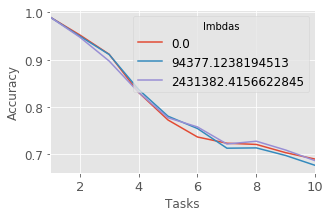

In [22]:
#fig, ax = plt.subplots(figsize=(4.5,2.5))
mpl.rcParams['figure.figsize'] = 4.75,3.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
df2.iloc[:,0:3].plot()
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Tasks')

Text(0.5,0,'Tasks')

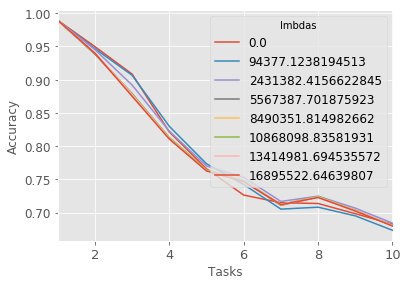

In [24]:
mpl.rcParams['figure.figsize'] = 6,4.25
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
df3.plot()
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Tasks')

In [25]:
df1.shape

(10, 8)

In [26]:
df1.iloc[:,0:5].values[:,0]

array([0.98799998, 0.94775   , 0.90333333, 0.81162499, 0.75979999,
       0.72016667, 0.70528572, 0.70660256, 0.68941859, 0.67196808])

In [27]:
Min = df1.iloc[:,0:4].values[:,0]
Max = df2.iloc[:,0:4].values[:,0]
Mean = df3.iloc[:,0:4].values[:,0]
final_df = pd.DataFrame({'Min':Min, 'Max':Max, 'Mean':Mean})
final_df

,Max,Mean,Min
0,0.990000,0.989250,0.988000
1,0.952500,0.949625,0.947750
2,0.911667,0.908333,0.903333
3,0.831000,0.821292,0.811625
4,0.772700,0.765883,0.759800
5,0.736750,0.726278,0.720167
6,0.723571,0.714857,0.705286
7,0.721026,0.713643,0.706603
8,0.703547,0.698304,0.689419
9,0.690000,0.682535,0.671968


In [28]:
final_df.index.rename('Task', inplace=True)
final_df

,Max,Mean,Min
Task,,,
0,0.990000,0.989250,0.988000
1,0.952500,0.949625,0.947750
2,0.911667,0.908333,0.903333
3,0.831000,0.821292,0.811625
4,0.772700,0.765883,0.759800
5,0.736750,0.726278,0.720167
6,0.723571,0.714857,0.705286
7,0.721026,0.713643,0.706603
8,0.703547,0.698304,0.689419


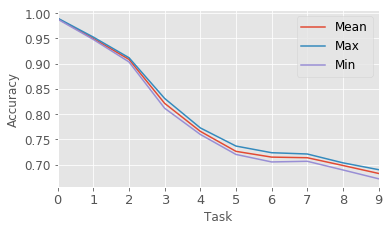

In [30]:
mpl.rcParams['figure.figsize'] = 5.75,3.250
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
ax = final_df.plot(y=['Mean','Max','Min'],x=final_df.index)
#ax.set_xticklabels([str((0,1)), str((2,3)), str((4,5)), str((6,7)), str((8,9))])
ax.set_xticks(final_df.index)
ax.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
ax.set_ylabel('Accuracy')
#plt.savefig('../outputs/tg_mnist_results_cl/buffered_accuracy.pdf', bbox_inches='tight')
#plt.savefig('../outputs/tg_mnist_results_cl/buffered_accuracy.png', bbox_inches='tight')
#plt.savefig('../outputs/tg_mnist_results_cl/buffered_accuracy.eps', bbox_inches='tight')
plt.show()